**Progetto Machine Learning**

Partecipanti
- Fiorentini Nicolò  933157
- Roncoroni Samuele 935111

In questo progetto si analizza l'impatto della contaminazione dei dati sulle prestazioni dei modelli di machine learning. Dopo aver selezionato un dataset adeguato, si esegue un’analisi esplorativa e si scelgono due modelli (per classificazione o regressione). I modelli vengono inizialmente addestrati su dati puliti per stabilire una baseline. Successivamente, si introduce contaminazione progressiva nei dati tramite tecniche controllate. Infine, si valutano le prestazioni dei modelli per identificare le feature più influenti e gli effetti del rumore.

In questa situazione, non si sta cercando di fare un modello perfetto, ma di capire quanto un modello è robusto a diverse quantità di rumore introdotte artificialmente. È quindi un esperimento comparativo e controllato.

#Dataset

In [153]:
#Diamo accesso al nostro google drive che conterrà il dataset che utilizzeremo
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sn
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from statsmodels.stats.proportion import proportion_confint
import requests
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from scipy import stats
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report
)

In [154]:
url = "https://raw.githubusercontent.com/NIKFIORE/Progetto-Machine-Learning/refs/heads/main/Dataset/Cancer_Data.csv"
# Carica il dataset direttamente da GitHub
df = pd.read_csv(url)
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

# Esplorazione dei Dati (EDA)

Analizza la distribuzione delle feature, la presenza di valori mancanti, correlazioni e altre statistiche descrittive utili.

In [155]:
print(f"Numero di istanze nel dataset: {df.shape[0]}")

Numero di istanze nel dataset: 569


 📈 Ingrandimento del dataset

L’ingrandimento del dataset non è stato effettuato, in quanto le 569 istanze originali risultano sufficienti per lo scopo dello studio, che è analizzare l’effetto progressivo del rumore sulle performance del modello. Aumentare artificialmente le istanze avrebbe introdotto variabilità non controllata, con il rischio di mascherare gli effetti del rumore stesso. Si è preferito quindi mantenere il dataset originale per garantire coerenza e semplicità nell’analisi.


In [156]:
df.drop(columns=["id"], inplace= True)
df.drop(columns=["Unnamed: 32"], inplace= True)
df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst       float64
symmetry_worst             float64
fractal_dimension_worst    float64
dtype: object

In [157]:
#controllo il numero di valori duplicati
df.duplicated().sum().item()

0

In [158]:
# Verifico se ci sono valori mancanti
missing_value = df.isnull().values.any()

# Definisco x prima di usarlo
if not missing_value:
    x = "non"
else:
    x = ""

print(f"Questo dataset {x} ha valori mancanti")

Questo dataset non ha valori mancanti


In [159]:
# Controlla i valori unici nella colonna 'diagnosis'
print(df['diagnosis'].unique())

['M' 'B']


In [160]:
# Mappatura della colonna 'diagnosis'
df["diagnosis"] = df["diagnosis"].map({'B': 0, 'M': 1})
df.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33           184.60   
1         0.1812  ...         24.99          23.41           158.80   
2         0.2069  ...         23.57          25.53           152.50   
3         0.2597  ...         14.91          26.50            98.87   
4         0.1809  ...         22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 31 columns]

In [161]:
# Rimuove la variabile target
df_features_only = df.drop(columns=['diagnosis'])

# Ottieni automaticamente tutte le features numeriche (float)
numeric_features = df_features_only.select_dtypes(include=['float64', 'float32']).columns.tolist()
target = "diagnosis"

print(f"Features numeriche trovate: {numeric_features}")
print(f"Numero di features: {len(numeric_features)}")

Features numeriche trovate: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Numero di features: 30


Rimozione della variabile target, per la matrice di corelazione, perchè in base alla codifica, della diagnosis, avrebbe influenzato il risultato

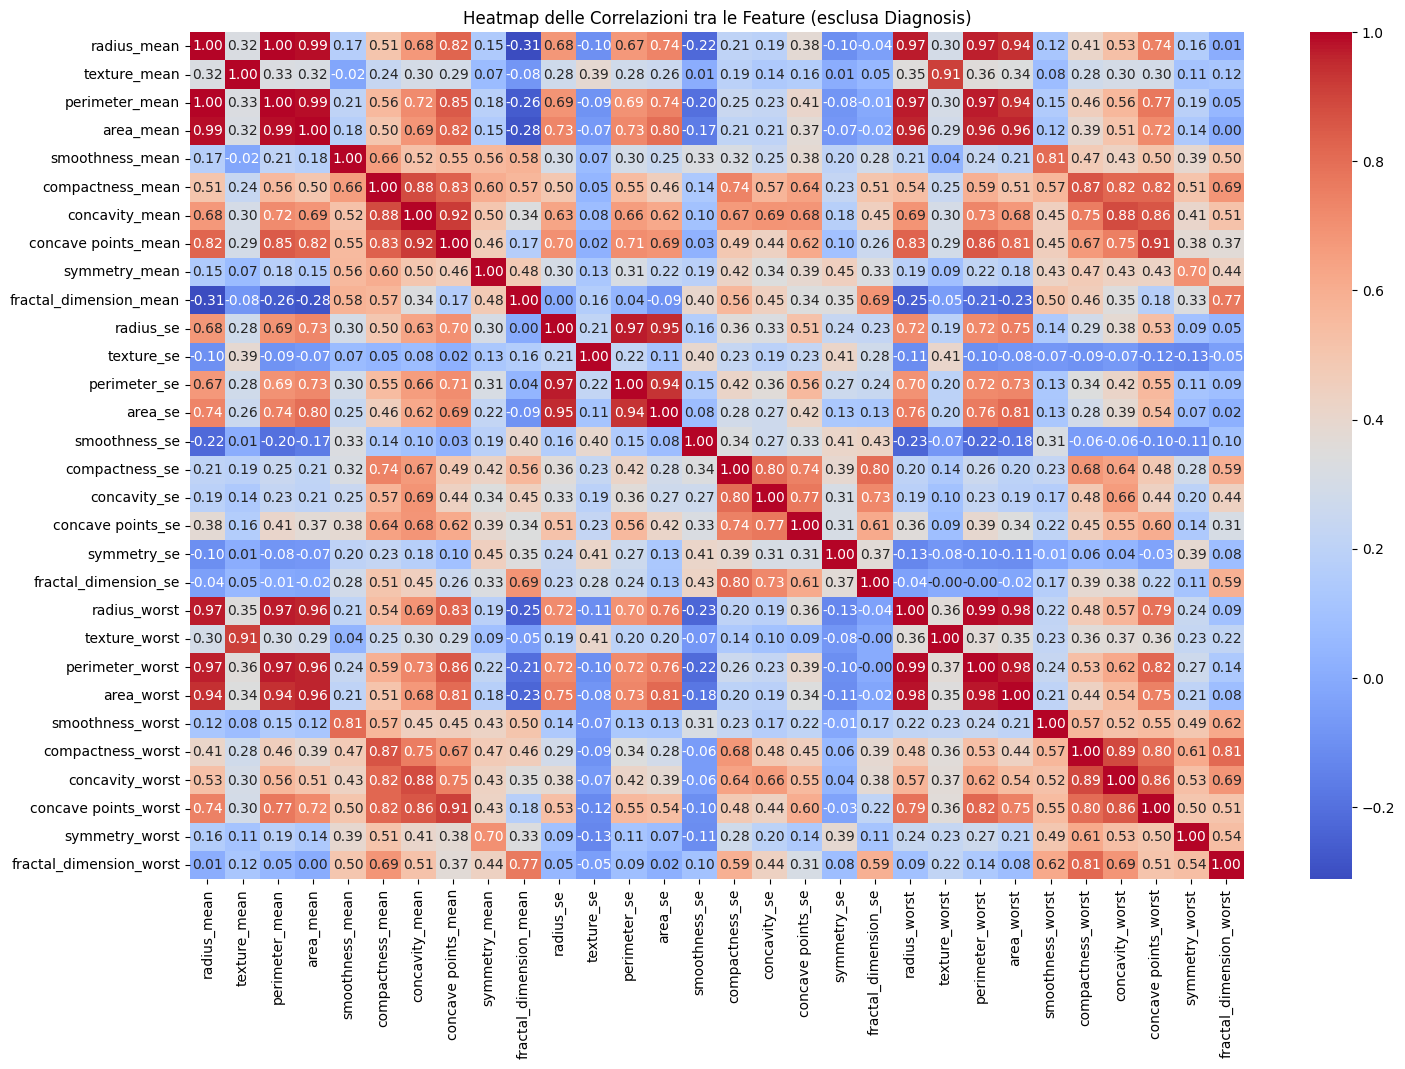

In [162]:
# Calcola la matrice di correlazione
correlation = df_features_only.corr()

# Crea la heatmap completa
plt.figure(figsize=(17, 11))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap delle Correlazioni tra le Feature (esclusa Diagnosis)')
plt.show()

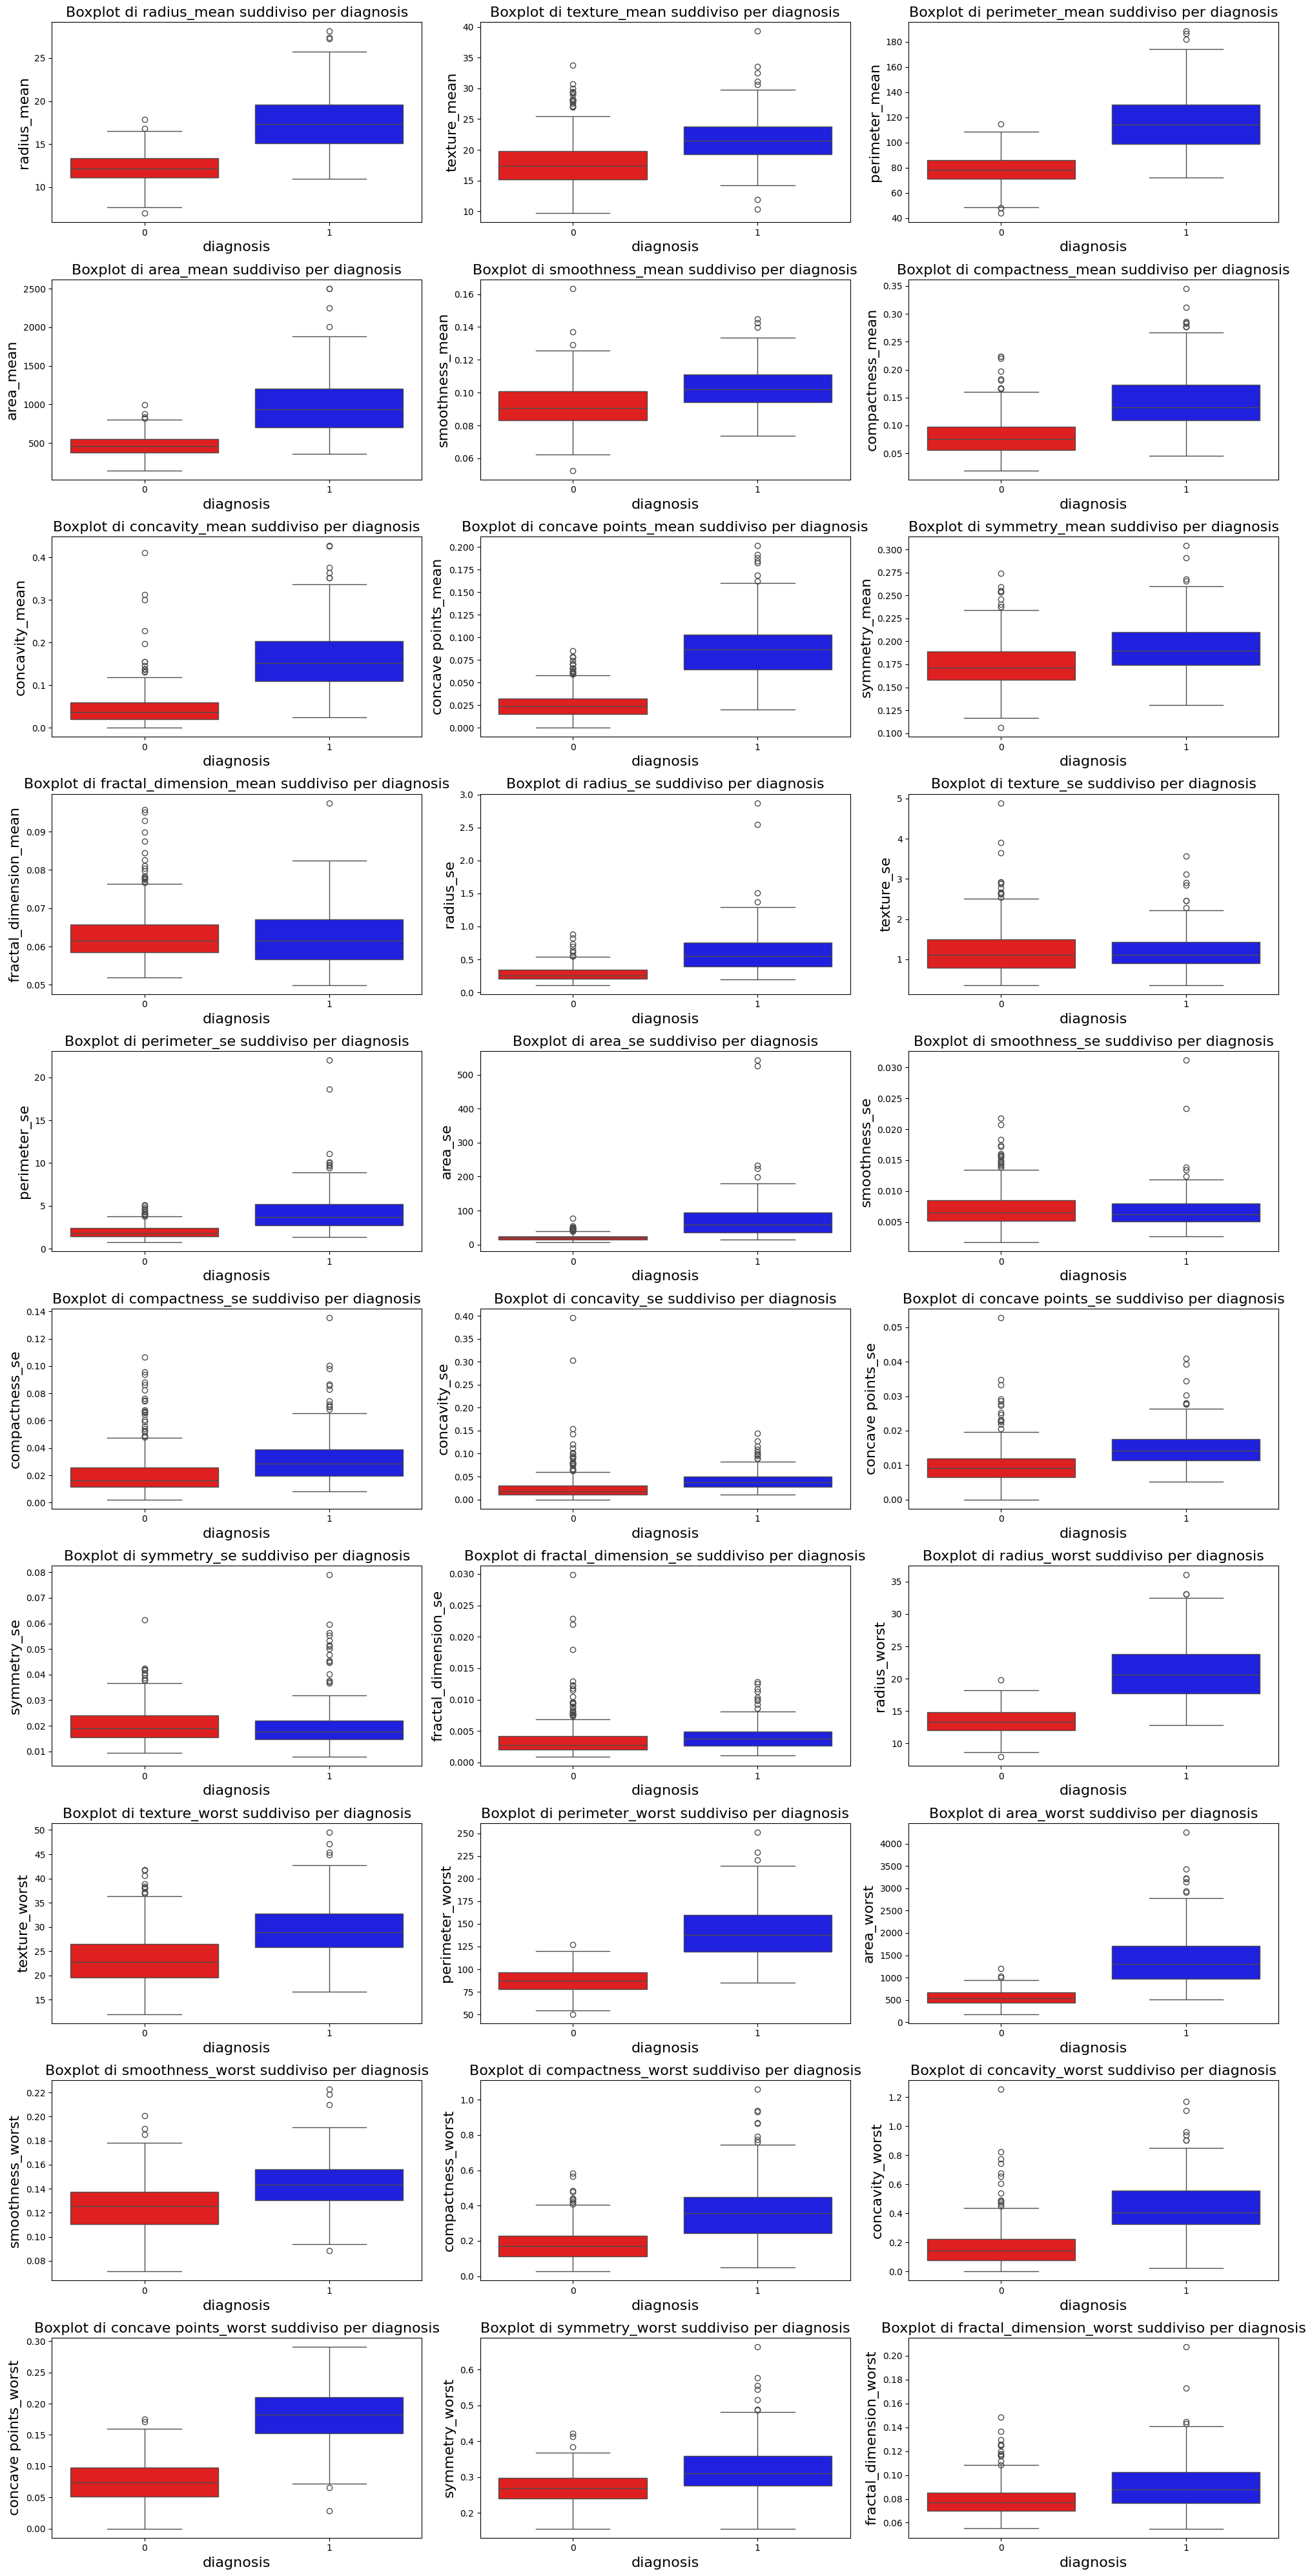

In [163]:
# Calcola il numero di righe e colonne per la griglia
n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Calcolo del numero di righe necessarie

# BOXPLOT
plt.figure(figsize=(20, 4 * n_rows))  # Altezza dinamica basata sul numero di righe
for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=target, y=feature, data=df, hue=target, palette=['red', 'blue'], legend=False)
    plt.title(f'Boxplot di {feature} suddiviso per {target}', fontsize=16)
    plt.xlabel(target, fontsize=16)
    plt.ylabel(feature, fontsize=16)

# Rimuovi subplot vuoti se presenti
for i in range(n_features, n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.axis('off')

plt.tight_layout()
plt.savefig("Boxplot_Features_Numeriche.pdf")
plt.show()

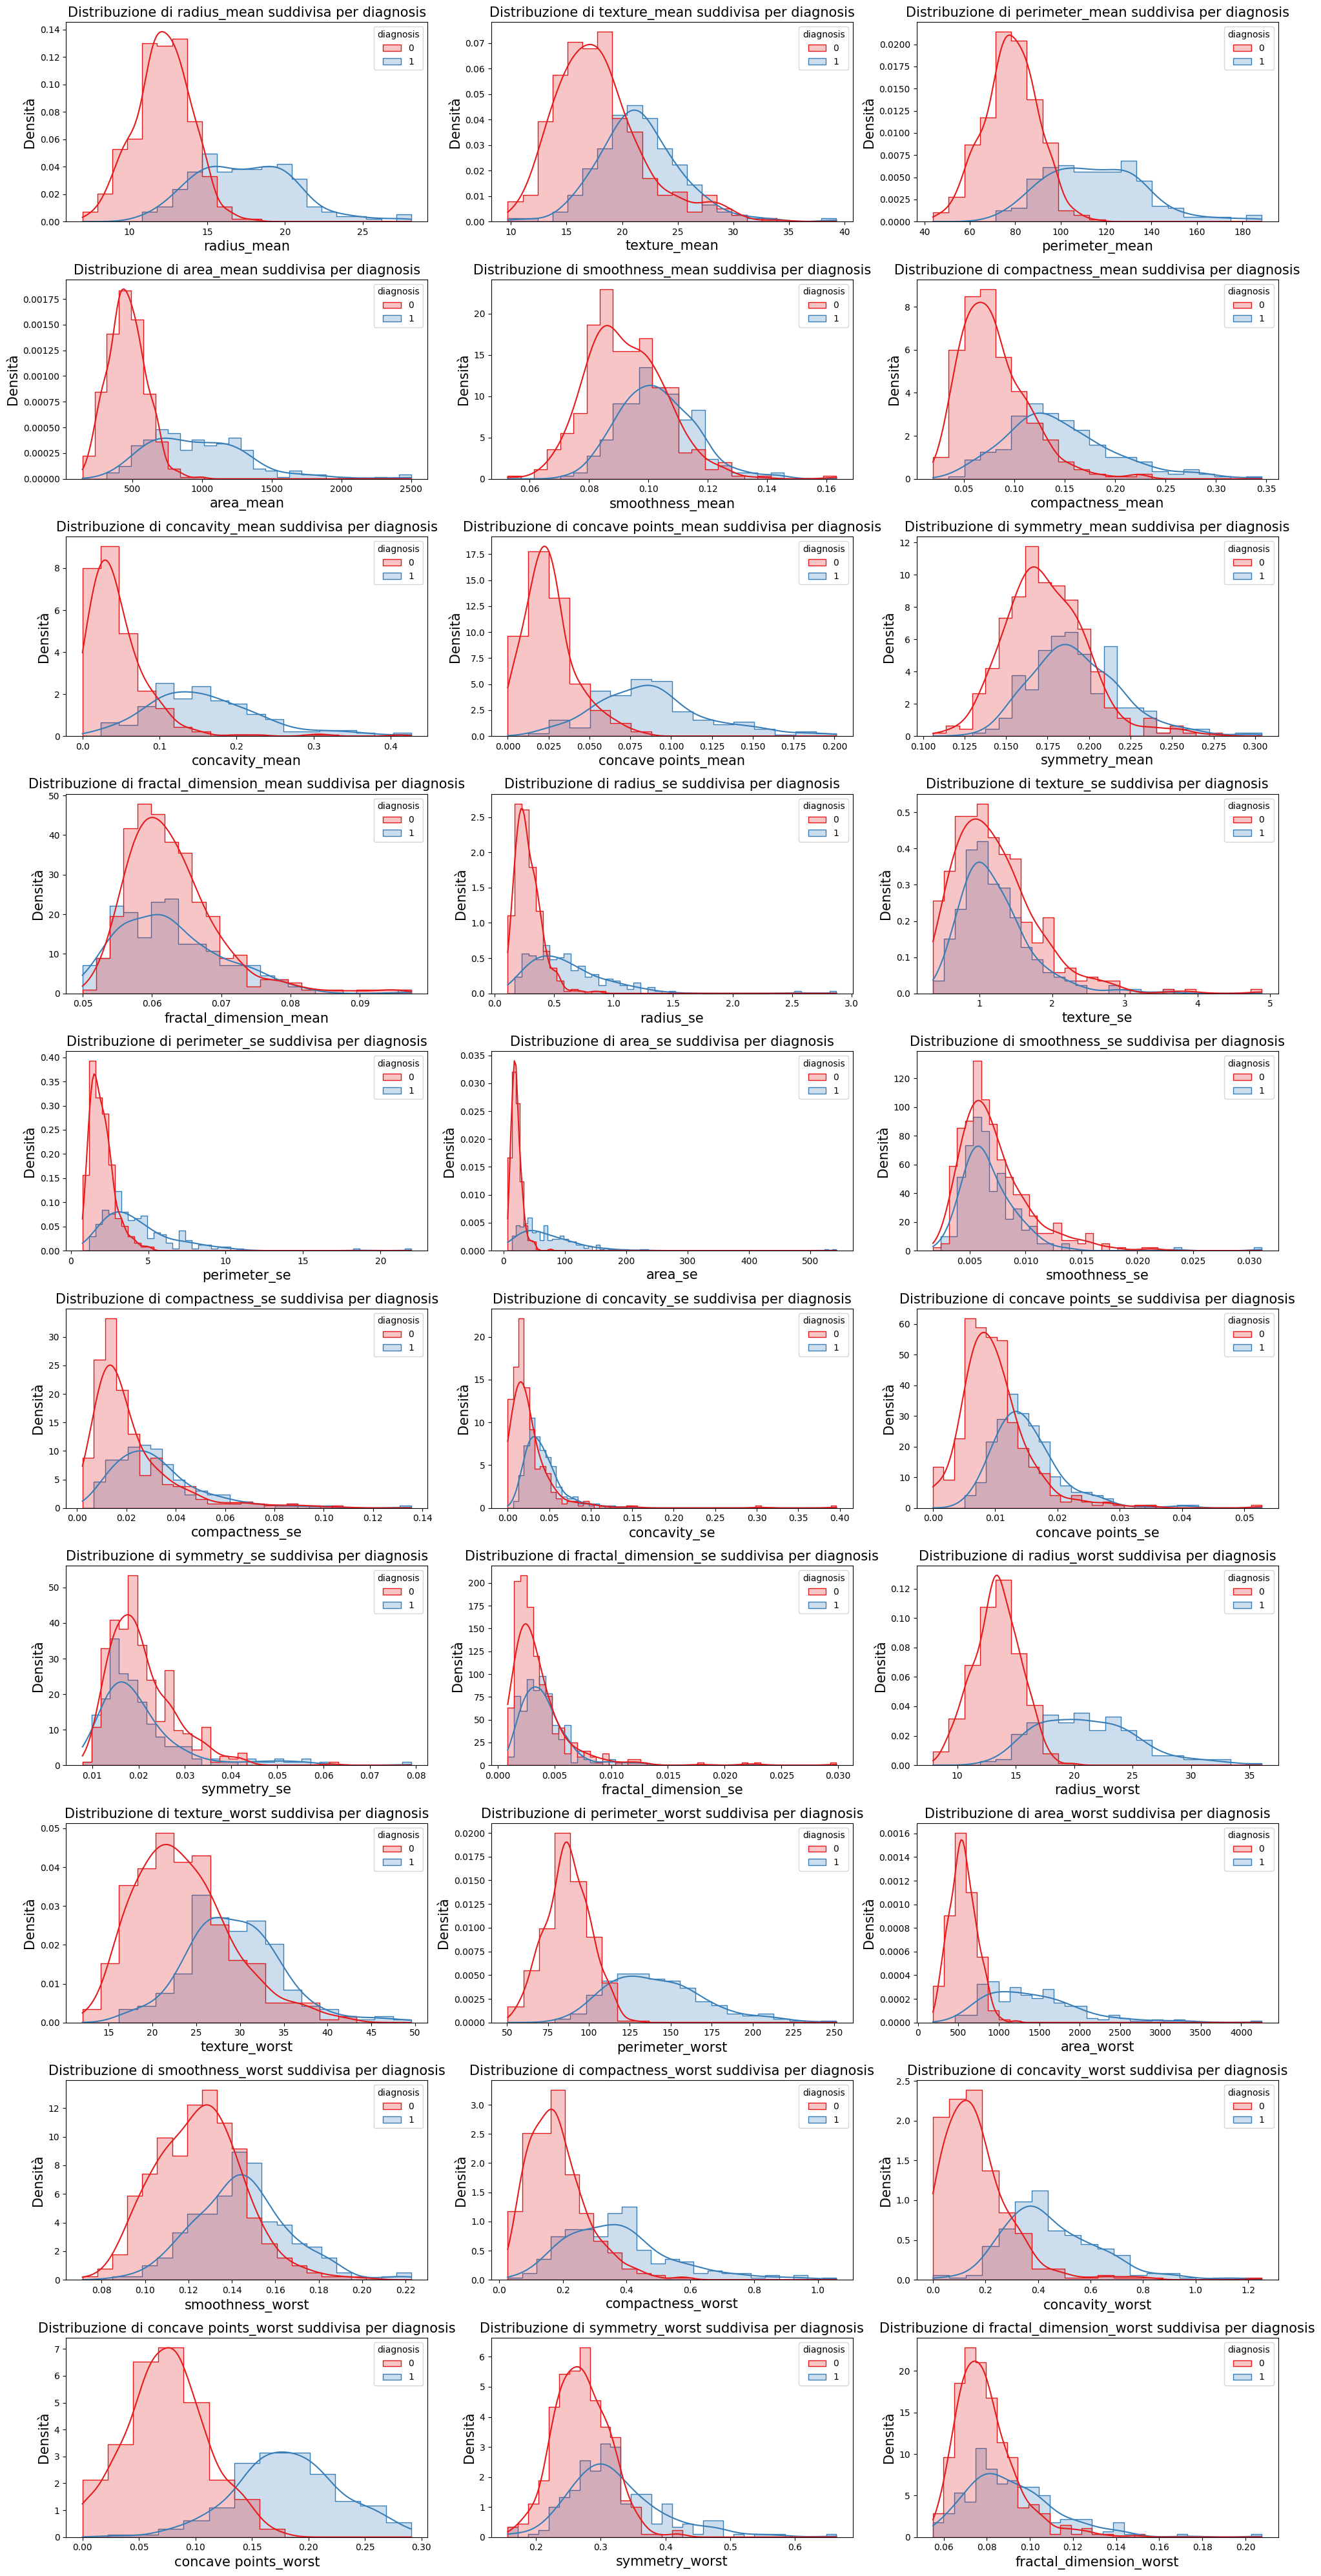

In [164]:
# GRAFICI DI DISTRIBUZIONE
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=False)

# Gestisci il caso di una sola riga
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(data=df, x=feature, hue=target, kde=True, element="step",
                palette="Set1", stat="density", ax=axes[i])
    axes[i].set_title(f"Distribuzione di {feature} suddivisa per {target}", fontsize=15)
    axes[i].set_xlabel(feature, fontsize=15)
    axes[i].set_ylabel("Densità", fontsize=15)

# Rimuovi subplot vuoti se presenti
for i in range(n_features, n_rows * n_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("Distribuzione_Features_Numeriche.pdf")
plt.show()

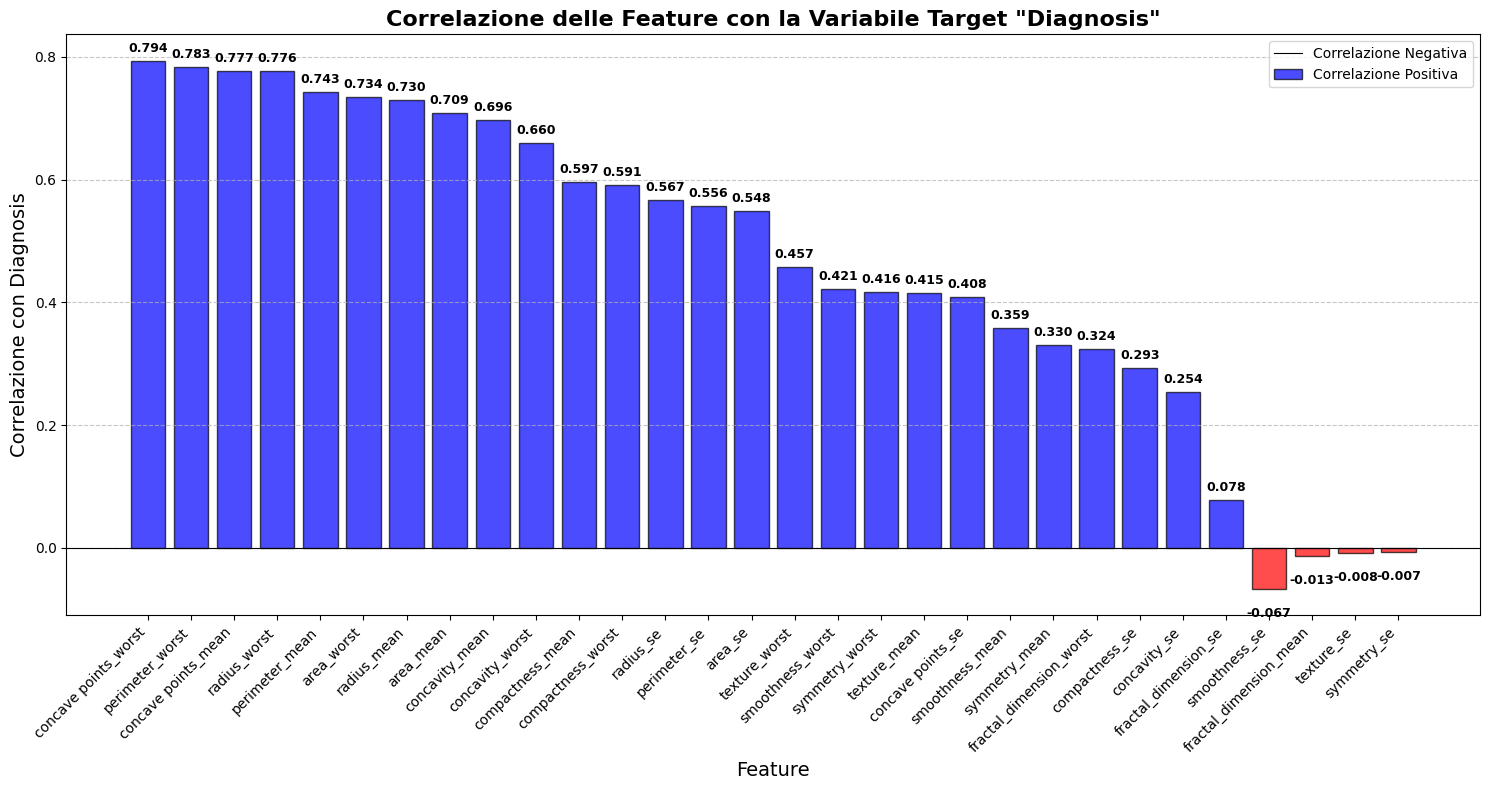


Top 10 Feature più correlate con 'Diagnosis':
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
Name: diagnosis, dtype: float64


In [165]:
# Calcola la correlazione tra tutte le feature e il target 'diagnosis'
correlations_with_target = df[numeric_features + ['diagnosis']].corr()['diagnosis'].drop('diagnosis')

# Ordina le correlazioni in valore assoluto (per vedere sia correlazioni positive che negative)
correlations_sorted = correlations_with_target.reindex(correlations_with_target.abs().sort_values(ascending=False).index)

# Crea il grafico a barre
plt.figure(figsize=(15, 8))
colors = ['red' if x < 0 else 'blue' for x in correlations_sorted.values]
bars = plt.bar(range(len(correlations_sorted)), correlations_sorted.values, color=colors, alpha=0.7, edgecolor='black')

# Personalizza il grafico
plt.title('Correlazione delle Feature con la Variabile Target "Diagnosis"', fontsize=16, fontweight='bold')
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Correlazione con Diagnosis', fontsize=14)
plt.xticks(range(len(correlations_sorted)), correlations_sorted.index, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Aggiungi una linea orizzontale a y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Aggiungi i valori sopra ogni barra
for i, (bar, value) in enumerate(zip(bars, correlations_sorted.values)):
   plt.text(bar.get_x() + bar.get_width()/2, value + (0.01 if value > 0 else -0.03),
            f'{value:.3f}', ha='center', va='bottom' if value > 0 else 'top', fontweight='bold', fontsize=9)

# Aggiungi una leggenda
plt.legend(['Correlazione Negativa', 'Correlazione Positiva'], loc='upper right')

plt.tight_layout()
plt.show()

# Stampa le top 10 correlazioni più forti (in valore assoluto)
print("\nTop 10 Feature più correlate con 'Diagnosis':")
print(correlations_sorted.head(10))

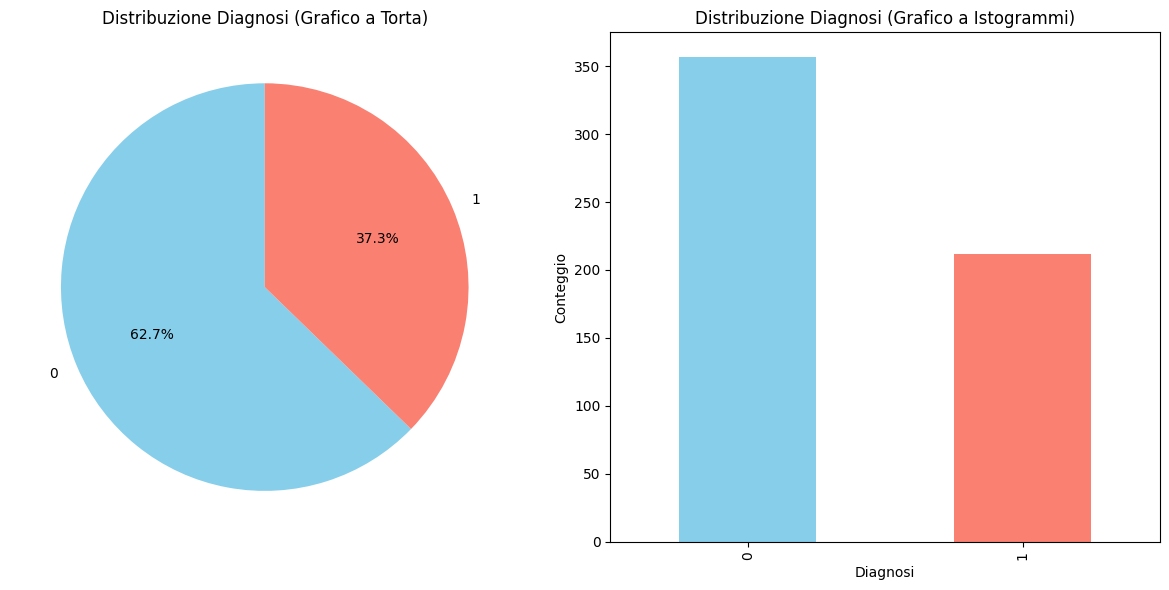

CONFRONTO DISTRIBUZIONE CLASSI:
diagnosis
0    357
1    212
Name: count, dtype: int64
Percentuale classe 0 (Benigno): 62.7%
Percentuale classe 1 (Maligno): 37.3%


In [166]:
# Plot a torta
plt.figure(figsize=(12, 6))

# Subplot 1: Grafico a torta
plt.subplot(1, 2, 1)
df['diagnosis'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi (Grafico a Torta)')
plt.ylabel('')

# Subplot 2: Grafico a istogrammi
plt.subplot(1, 2, 2)
df['diagnosis'].value_counts().plot.bar(color=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi (Grafico a Istogrammi)')
plt.xlabel('Diagnosi')
plt.ylabel('Conteggio')

# Mostra il grafico
plt.tight_layout()
plt.show()

print("CONFRONTO DISTRIBUZIONE CLASSI:")
print(df['diagnosis'].value_counts())
print(f"Percentuale classe 0 (Benigno): {df['diagnosis'].value_counts()[0]/len(df)*100:.1f}%")
print(f"Percentuale classe 1 (Maligno): {df['diagnosis'].value_counts()[1]/len(df)*100:.1f}%")

⚖️ Bilanciamento del target

Il dataset originale presenta una leggera asimmetria tra classi: circa il 62,7% delle istanze sono benigne, mentre il 37,3% sono maligne. Questo sbilanciamento può influenzare negativamente l’apprendimento del modello, portandolo a privilegiare la classe maggioritaria e falsando metriche come l'accuracy. In uno studio volto a valutare la sensibilità del modello al rumore, è fondamentale che le condizioni iniziali siano equilibrate, per evitare che il degrado delle performance sia attribuibile allo sbilanciamento piuttosto che al rumore stesso.

# Preparazione dei modelli


Come bilanciare il target (M/B)?
Tre strategie principali:

- Undersampling: riduci i benigni (B) → perdi informazione.

- Oversampling: duplichi i maligni (M) → rischio overfitting.

- SMOTE (Synthetic Minority Over-sampling Technique): genera nuovi esempi maligni interpolando tra quelli esistenti → consigliato.

Per questo, il bilanciamento del target è stato considerato un passo essenziale, realizzato tramite tecniche di oversampling come SMOTE, al fine di garantire una valutazione imparziale e significativa.




✅ Motivi per aggiungere valori (oversampling/SMOTE):
Il dataset ha una leggera asimmetria (62.7% benigni, 37.3% maligni), quindi non è gravemente sbilanciato, ma abbastanza da poter influenzare il modello.

- Rimuovere istanze (undersampling) dalla classe maggioritaria (benigni) comporterebbe una perdita di informazione utile, cosa rischiosa soprattutto se il dataset non è molto grande.

- L’obiettivo del tuo studio è valutare la sensibilità al rumore, quindi è importante partire da un dataset il più possibile equilibrato, per isolare l’effetto del rumore dallo sbilanciamento.

- Tecniche di oversampling come SMOTE permettono di generare nuovi esempi sintetici della classe minoritaria, evitando di duplicare semplicemente gli esistenti (che può portare a overfitting).

- SMOTE è particolarmente adatto in situazioni come questa, dove il leggero sbilanciamento può essere compensato senza sacrificare dati reali né introdurre troppa ridondanza.

❌ Motivi per non togliere valori (undersampling):
Rimuovere istanze dalla classe 0 (benigni) ridurrebbe la varietà dei dati disponibili.

- Potresti perdere pattern diagnostici importanti che aiutano a differenziare benigni da maligni.

- Sottocampionare è più adatto quando la classe maggioritaria è molto predominante (es. 90%-10%), cosa che non è il tuo caso.

❓ Perché il bilanciamento va fatto solo sul training?
🚫 Se lo fai su tutto il dataset prima dello split, stai commettendo data leakage:
- stai mescolando informazioni del test set nel training;

- il tuo modello impara su dati "gonfiati" artificialmente, e le metriche sul test saranno ottimistiche e falsate;

in pratica: stai barando senza volerlo.

In [167]:
# Separazione delle feature e della variabile target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Split del dataset in training (80%) e test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Numero totale di istanze nel TRAINING SET PRIMA SMOTE: 455
Distribuzione classi nel TRAINING SET prima di SMOTE:
diagnosis
0    285
1    170
Name: count, dtype: int64
Percentuale classe 0 (Benigno): 62.6%
Percentuale classe 1 (Maligno): 37.4%

Numero totale di istanze nel TRAINING SET dopo SMOTE: 570
Distribuzione classi nel TRAINING SET dopo SMOTE:
diagnosis
1    285
0    285
Name: count, dtype: int64
Percentuale classe 0 (Benigno): 50.0%
Percentuale classe 1 (Maligno): 50.0%




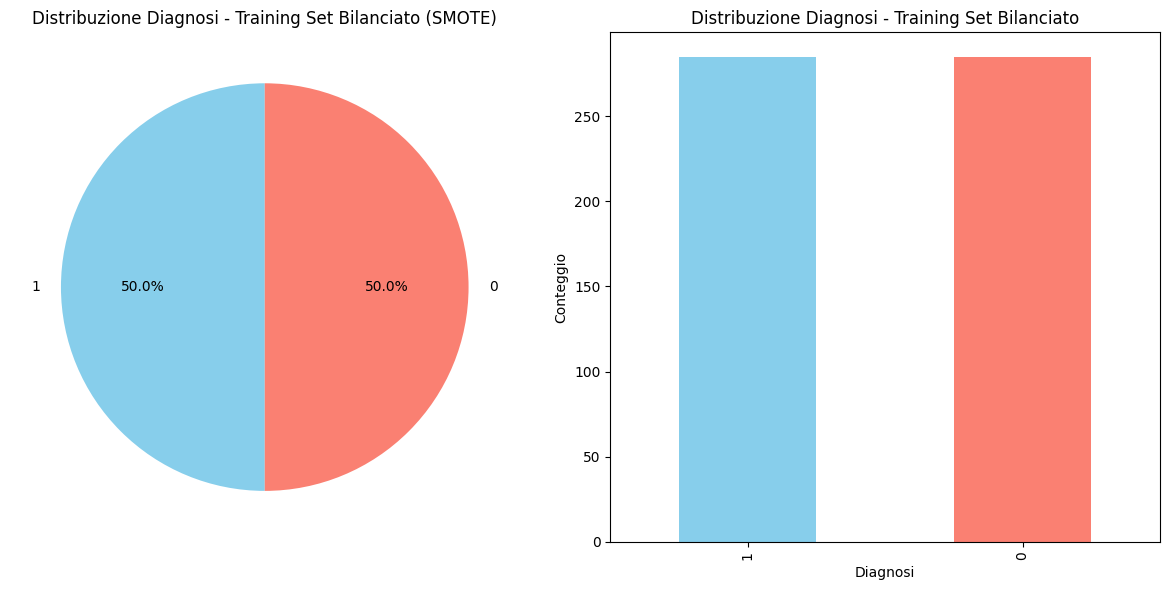

In [168]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

print(f"\nNumero totale di istanze nel TRAINING SET PRIMA SMOTE: {len(X_train)}")

# Visualizza distribuzione originale nel training set (prima del bilanciamento)
print("Distribuzione classi nel TRAINING SET prima di SMOTE:")
print(y_train.value_counts())
print(f"Percentuale classe 0 (Benigno): {y_train.value_counts()[0]/len(y_train)*100:.1f}%")
print(f"Percentuale classe 1 (Maligno): {y_train.value_counts()[1]/len(y_train)*100:.1f}%")

# Applica SMOTE solo sul training set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"\nNumero totale di istanze nel TRAINING SET dopo SMOTE: {len(X_train)}")

# Visualizza la distribuzione delle classi nel training set dopo SMOTE
print("Distribuzione classi nel TRAINING SET dopo SMOTE:")
print(pd.Series(y_train).value_counts())
print(f"Percentuale classe 0 (Benigno): {pd.Series(y_train).value_counts()[0]/len(y_train)*100:.1f}%")
print(f"Percentuale classe 1 (Maligno): {pd.Series(y_train).value_counts()[1]/len(y_train)*100:.1f}%")
print("\n")

# Grafico: distribuzione classi nel training set dopo SMOTE
plt.figure(figsize=(12, 6))

# Grafico a torta
plt.subplot(1, 2, 1)
pd.Series(y_train).value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi - Training Set Bilanciato (SMOTE)')
plt.ylabel('')

# Grafico a barre
plt.subplot(1, 2, 2)
pd.Series(y_train).value_counts().plot.bar(color=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi - Training Set Bilanciato')
plt.xlabel('Diagnosi')
plt.ylabel('Conteggio')

plt.tight_layout()
plt.show()

Funzione che crea e addestra i modelli

In [169]:
# Neural Network model
def create_neural_network_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),  # Use Input layer instead of specifying input_shape in Dense
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# SVM Model
def create_and_train_svm_model(X_train, y_train, kernel='rbf', C=1):
    model = SVC(kernel=kernel, C=C, probability=True)
    model.fit(X_train, y_train)
    return model

# Decision Tree Model
def create_and_train_decision_tree(X_train, y_train, random_state=42, **kwargs):
    model = DecisionTreeClassifier(random_state=random_state, **kwargs)
    model.fit(X_train, y_train)

    return model

Funzione per misurare e visionare le performance del modello

In [170]:
def evaluate_model_performance(y_true, y_pred, model_name):
    """
    Comprehensive model performance evaluation

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - model_name: Name of the model

    Returns:
    - Dictionary of performance metrics
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print detailed classification report
    print(f"\n{model_name} - Detailed Classification Report:")
    print(classification_report(y_true, y_pred))

    # Print formatted metrics summary
    print(f"\n{model_name} - Performance Metrics Summary:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Create compact confusion matrix plot
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'],
                cbar_kws={'shrink': 0.8})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=10, pad=10)
    plt.ylabel('True Label', fontsize=9)
    plt.xlabel('Predicted Label', fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

    # Return metrics for visualization
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'True Negatives': cm[0,0],
        'False Positives': cm[0,1],
        'False Negatives': cm[1,0],
        'True Positives': cm[1,1]
    }

Funzione per mettere a confronto graficamente le metriche dei modelli

In [171]:
def plot_model_performance_metrics(metrics_list):
    """
    Create a compact visualization of model performance metrics.
    """
    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Set up 2x4 grid
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')

    # Metrics to plot
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

    # Plot the 4 main metrics
    for i, metric in enumerate(metrics):
        ax = axs[0, i]
        bars = metrics_df.plot(kind='bar', x='Model', y=metric, ax=ax, color=colors[i],
                               edgecolor='black', linewidth=1, alpha=0.7)

        ax.set_title(f'{metric}', fontweight='bold', fontsize=11)
        ax.set_ylabel(metric)
        ax.set_xlabel('')
        ax.set_ylim(0, 1)
        ax.yaxis.grid(True, linestyle='--', alpha=0.6)

        for j, v in enumerate(metrics_df[metric]):
            ax.text(j, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Plot True Positives and True Negatives
    ax = axs[1, 0]
    true_plot = metrics_df.plot(kind='bar', x='Model', y=['True Positives', 'True Negatives'],
                                ax=ax, color=['#e74c3c', '#3498db'],
                                edgecolor='black', linewidth=1, alpha=0.7)
    ax.set_title('True Positives & True Negatives', fontweight='bold', fontsize=11)
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for container in true_plot.containers:
        true_plot.bar_label(container, fmt='%.0f', fontsize=9, fontweight='bold')

    # Plot False Positives and False Negatives
    ax = axs[1, 1]
    false_plot = metrics_df.plot(kind='bar', x='Model', y=['False Positives', 'False Negatives'],
                                 ax=ax, color=['#2ecc71', '#f39c12'],
                                 edgecolor='black', linewidth=1, alpha=0.7)
    ax.set_title('False Positives & False Negatives', fontweight='bold', fontsize=11)
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for container in false_plot.containers:
        false_plot.bar_label(container, fmt='%.0f', fontsize=9, fontweight='bold')

    # Leave the remaining 2 plots empty or use for legend/extra info
    axs[1, 2].axis('off')
    axs[1, 3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()


# **Rete neurale e Analisi delle performance**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Neural Network - Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.28      0.43        72
           1       0.45      1.00      0.62        42

    accuracy                           0.54       114
   macro avg       0.72      0.64      0.53       114
weighted avg       0.80      0.54      0.50       114


Neural Network - Performance Metrics Summary:
Accuracy:  0.5439
Precision: 0.4468
Recall:    1.0000
F1 Score:  0.6176


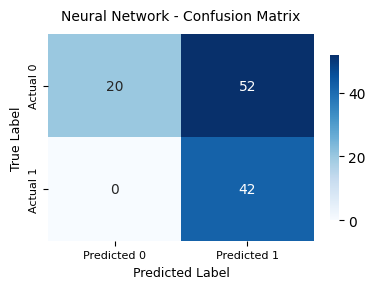

In [172]:
# Train Neural Network
input_shape = (X_train.shape[1],)
nn_model = create_neural_network_model(input_shape)
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
nn_pred = (nn_model.predict(X_test) > 0.5).astype(int).flatten()
nn_metrics = evaluate_model_performance(y_test, nn_pred, 'Neural Network')

In [173]:
nn_model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,293 (48.02 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,196 (32.02 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


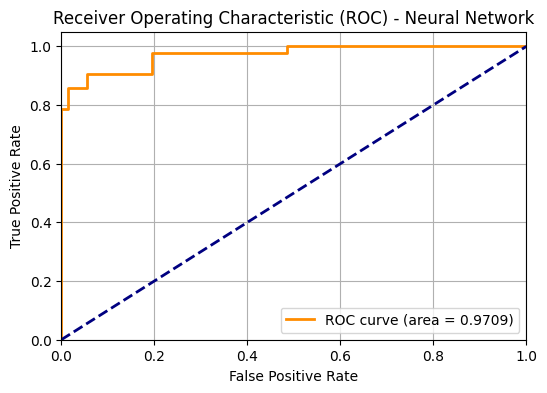

In [174]:
# Curva ROC
nn_probs = nn_model.predict(X_test).flatten()

# Calcolo curve ROC
fpr, tpr, thresholds = roc_curve(y_test, nn_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Neural Network')
plt.legend(loc="lower right")
plt.grid()
plt.show()

StratifiedKFold è preferibile a KFold quando si lavora con dataset sbilanciati, poiché garantisce che ogni fold mantenga la stessa proporzione di classi presente nel dataset originale. Questo è fondamentale per ottenere valutazioni più realistiche delle prestazioni del modello, soprattutto in problemi di classificazione binaria dove una classe può essere molto più rappresentata dell'altra. Al contrario, KFold divide i dati casualmente senza considerare le etichette, il che può portare a fold con solo esempi di una classe, distorcendo le metriche come accuracy, precision o recall.

Stratified K-Fold Cross Validation (5 folds)...
--------------------------------------------------
Fold 1/5
  Acc: 0.9474, Prec: 0.9474, Rec: 0.9474, F1: 0.9474
Fold 2/5
  Acc: 0.8509, Prec: 0.8125, Rec: 0.9123, F1: 0.8595
Fold 3/5
  Acc: 0.9211, Prec: 0.9286, Rec: 0.9123, F1: 0.9204
Fold 4/5
  Acc: 0.9123, Prec: 0.9608, Rec: 0.8596, F1: 0.9074
Fold 5/5
  Acc: 0.9211, Prec: 0.8871, Rec: 0.9649, F1: 0.9244
--------------------------------------------------
RISULTATI CON INTERVALLI DI CONFIDENZA (95%):
--------------------------------------------------
ACCURACY: 0.9105 [0.8660, 0.9550]
PRECISION: 0.9073 [0.8330, 0.9815]
RECALL: 0.9193 [0.8691, 0.9694]
F1: 0.9118 [0.8713, 0.9523]


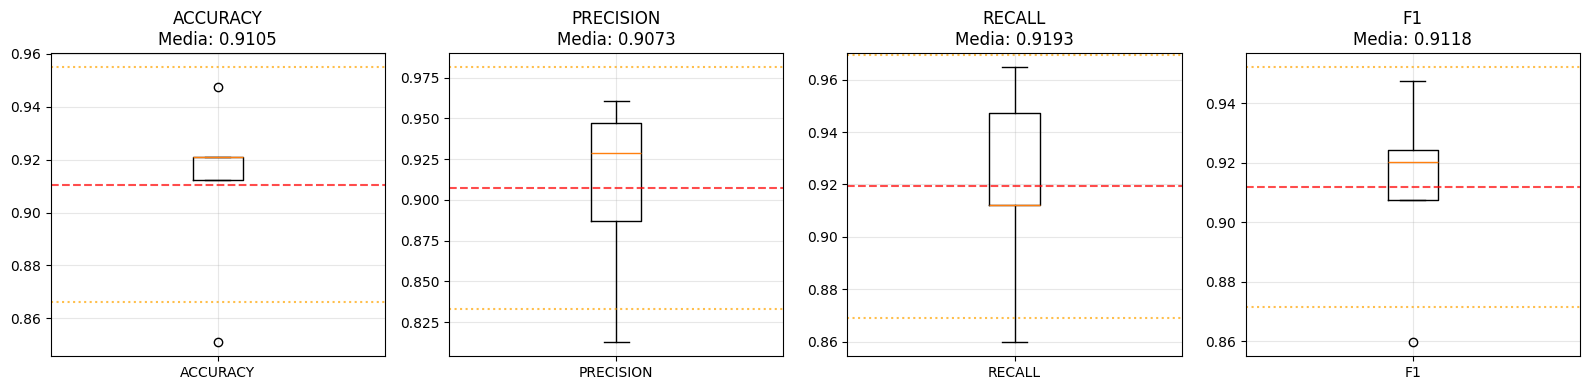


CONFRONTO CON MODELLO ORIGINALE:
--------------------------------------------------
Accuracy - Originale: 0.5439 | Cross-Val: 0.9105
F1 Score - Originale: 0.6176 | Cross-Val: 0.9118

Cross-validation completata!


In [175]:
# Stratified K-Fold Cross Validation
# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

print("Stratified K-Fold Cross Validation (5 folds)...")
print("-" * 50)

# K-fold loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}/5")

    # Split data
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train model
    fold_model = create_neural_network_model(input_shape)
    fold_model.fit(X_fold_train, y_fold_train, epochs=10, batch_size=32, verbose=0)

    # Predict and evaluate
    val_pred = (fold_model.predict(X_fold_val, verbose=0) > 0.5).astype(int).flatten()

    # Calculate metrics
    acc = accuracy_score(y_fold_val, val_pred)
    prec = precision_score(y_fold_val, val_pred)
    rec = recall_score(y_fold_val, val_pred)
    f1 = f1_score(y_fold_val, val_pred)

    # Store results
    cv_scores['accuracy'].append(acc)
    cv_scores['precision'].append(prec)
    cv_scores['recall'].append(rec)
    cv_scores['f1'].append(f1)

    print(f"  Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
    keras.backend.clear_session()

print("-" * 50)

# Calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    margin = stats.sem(data) * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - margin, mean + margin

# Results with confidence intervals
print("RISULTATI CON INTERVALLI DI CONFIDENZA (95%):")
print("-" * 50)

for metric, values in cv_scores.items():
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    print(f"{metric.upper()}: {mean_val:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")

# Simple visualization
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, (metric, values) in enumerate(cv_scores.items()):
    ax[i].boxplot(values, tick_labels=[metric.upper()])
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    ax[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7)
    ax[i].axhline(y=ci_lower, color='orange', linestyle=':', alpha=0.7)
    ax[i].axhline(y=ci_upper, color='orange', linestyle=':', alpha=0.7)
    ax[i].set_title(f'{metric.upper()}\nMedia: {mean_val:.4f}')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quick comparison with original model
print("\nCONFRONTO CON MODELLO ORIGINALE:")
print("-" * 50)
cv_mean_acc = np.mean(cv_scores['accuracy'])
original_acc = nn_metrics['Accuracy']
print(f"Accuracy - Originale: {original_acc:.4f} | Cross-Val: {cv_mean_acc:.4f}")

cv_mean_f1 = np.mean(cv_scores['f1'])
original_f1 = nn_metrics['F1 Score']
print(f"F1 Score - Originale: {original_f1:.4f} | Cross-Val: {cv_mean_f1:.4f}")

print("\nCross-validation completata!")

# **Sub vector machine e Analisi delle performance**


SVM - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93        72
           1       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114


SVM - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.9706
Recall:    0.7857
F1 Score:  0.8684


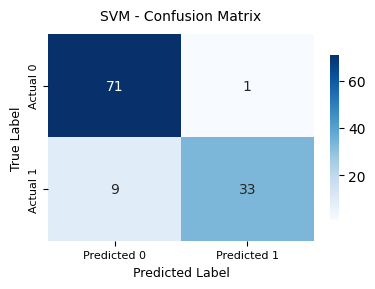

In [176]:
# Train SVM
svm_model = create_and_train_svm_model(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_metrics = evaluate_model_performance(y_test, svm_pred, 'SVM')

In [177]:
print("SVM Model parameters:")
print(svm_model.get_params())

SVM Model parameters:
{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


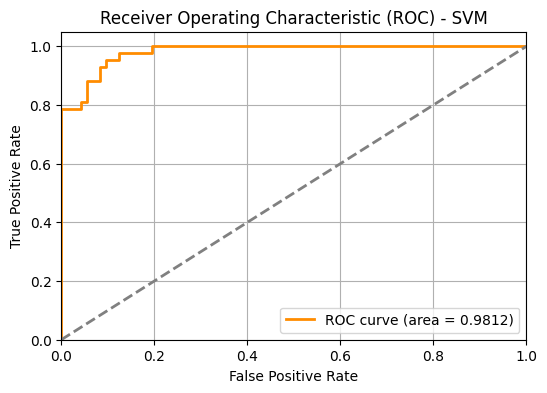

In [178]:
# Curva ROC
if hasattr(svm_model, "predict_proba"):
    svm_probs = svm_model.predict_proba(X_test)[:, 1]
else:
    # Altrimenti usa decision_function e normalizza
    svm_scores = svm_model.decision_function(X_test)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    svm_probs = scaler.fit_transform(svm_scores.reshape(-1, 1)).flatten()

# Calcolo curve ROC
fpr, tpr, thresholds = roc_curve(y_test, svm_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - SVM')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Stratified K-Fold Cross Validation (5 folds) - SVM...
--------------------------------------------------
Fold 1/5
  Acc: 0.8947, Prec: 0.8947, Rec: 0.8947, F1: 0.8947
Fold 2/5
  Acc: 0.8772, Prec: 0.9216, Rec: 0.8246, F1: 0.8704
Fold 3/5
  Acc: 0.9386, Prec: 0.9808, Rec: 0.8947, F1: 0.9358
Fold 4/5
  Acc: 0.9211, Prec: 0.9615, Rec: 0.8772, F1: 0.9174
Fold 5/5
  Acc: 0.9211, Prec: 0.9800, Rec: 0.8596, F1: 0.9159
--------------------------------------------------
RISULTATI CON INTERVALLI DI CONFIDENZA (95%):
--------------------------------------------------
ACCURACY: 0.9105 [0.8803, 0.9407]
PRECISION: 0.9477 [0.9004, 0.9951]
RECALL: 0.8702 [0.8337, 0.9066]
F1: 0.9068 [0.8757, 0.9379]


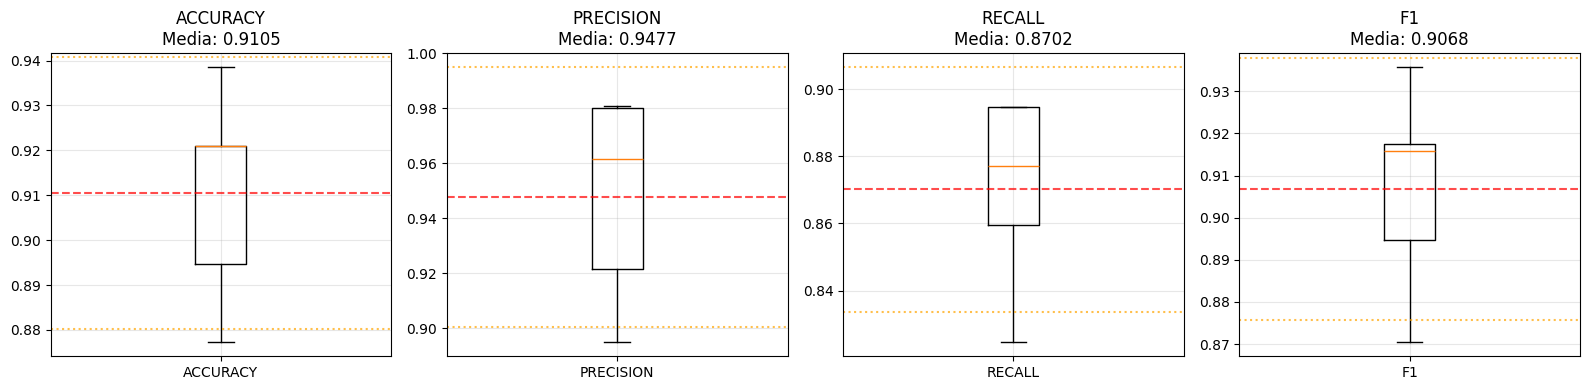


CONFRONTO CON MODELLO SVM ORIGINALE:
--------------------------------------------------
Accuracy - Originale: 0.9123 | Cross-Val: 0.9105
F1 Score - Originale: 0.8684 | Cross-Val: 0.9068

Cross-validation completata!


In [179]:
# Stratified K-Fold Cross Validation for SVM
# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

print("Stratified K-Fold Cross Validation (5 folds) - SVM...")
print("-" * 50)

# K-fold loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}/5")

    # Split data
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train SVM model
    fold_svm_model = create_and_train_svm_model(X_fold_train, y_fold_train)

    # Predict and evaluate
    val_pred = fold_svm_model.predict(X_fold_val)

    # Calculate metrics
    acc = accuracy_score(y_fold_val, val_pred)
    prec = precision_score(y_fold_val, val_pred)
    rec = recall_score(y_fold_val, val_pred)
    f1 = f1_score(y_fold_val, val_pred)

    # Store results
    cv_scores['accuracy'].append(acc)
    cv_scores['precision'].append(prec)
    cv_scores['recall'].append(rec)
    cv_scores['f1'].append(f1)

    print(f"  Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

print("-" * 50)

# Calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    margin = stats.sem(data) * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - margin, mean + margin

# Results with confidence intervals
print("RISULTATI CON INTERVALLI DI CONFIDENZA (95%):")
print("-" * 50)

for metric, values in cv_scores.items():
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    print(f"{metric.upper()}: {mean_val:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")

# Simple visualization
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, (metric, values) in enumerate(cv_scores.items()):
    ax[i].boxplot(values, tick_labels=[metric.upper()])
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    ax[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7)
    ax[i].axhline(y=ci_lower, color='orange', linestyle=':', alpha=0.7)
    ax[i].axhline(y=ci_upper, color='orange', linestyle=':', alpha=0.7)
    ax[i].set_title(f'{metric.upper()}\nMedia: {mean_val:.4f}')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quick comparison with original SVM model
print("\nCONFRONTO CON MODELLO SVM ORIGINALE:")
print("-" * 50)
cv_mean_acc = np.mean(cv_scores['accuracy'])
original_acc = svm_metrics['Accuracy']
print(f"Accuracy - Originale: {original_acc:.4f} | Cross-Val: {cv_mean_acc:.4f}")

cv_mean_f1 = np.mean(cv_scores['f1'])
original_f1 = svm_metrics['F1 Score']
print(f"F1 Score - Originale: {original_f1:.4f} | Cross-Val: {cv_mean_f1:.4f}")

print("\nCross-validation completata!")

# **Albero decisionale e Analisi delle performance**


Decision Tree - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94        72
           1       0.90      0.88      0.89        42

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114


Decision Tree - Performance Metrics Summary:
Accuracy:  0.9211
Precision: 0.9024
Recall:    0.8810
F1 Score:  0.8916


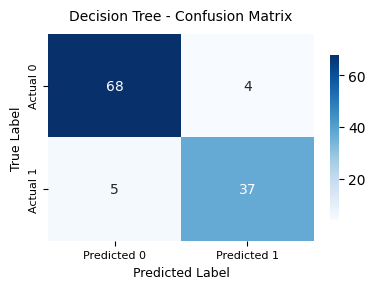

In [180]:
# Train Decision Tree
dt_model = create_and_train_decision_tree(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_metrics = evaluate_model_performance(y_test, dt_pred, 'Decision Tree')

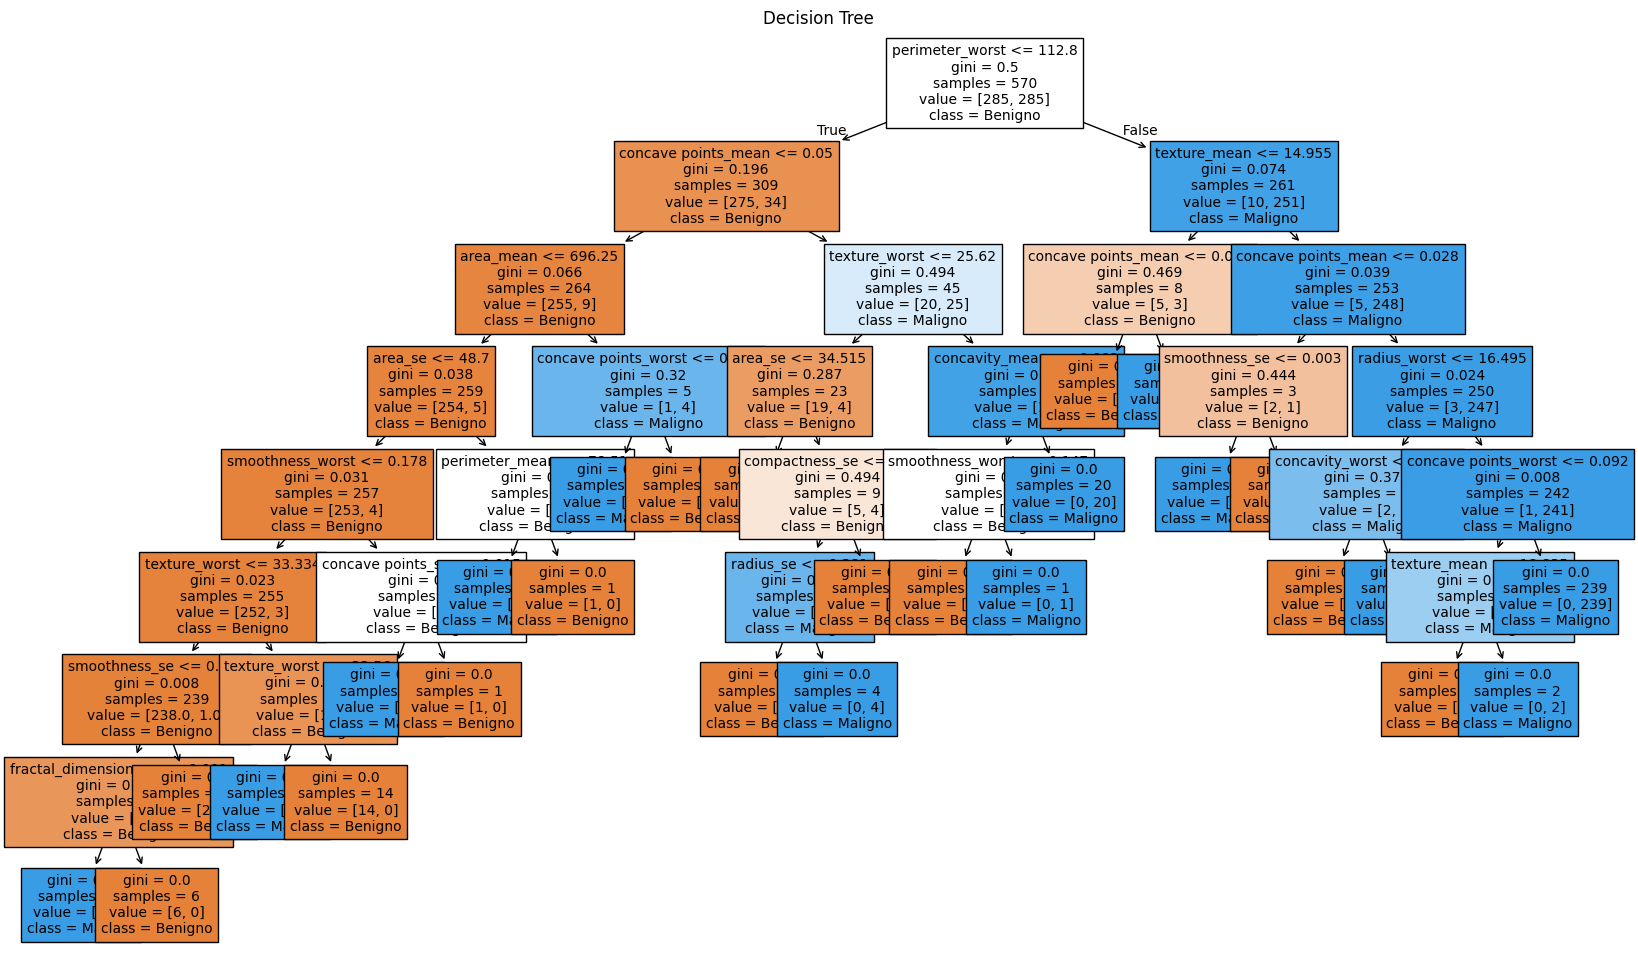

In [181]:
#Grafico rappresentativo del modello
fig, ax = plt.subplots(figsize=(20, 12))  # Dimensione più ragionevole
plot_tree(dt_model, filled=True, ax=ax, feature_names=X.columns, class_names=['Benigno', 'Maligno'], fontsize=10)
plt.title("Decision Tree")
plt.show()

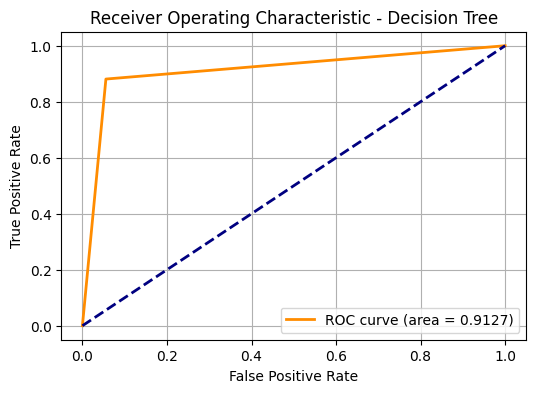

In [182]:
# Calcolo della curva ROC
y_proba = dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot della curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Stratified K-Fold Cross Validation (5 folds) - Decision Tree...
--------------------------------------------------
Fold 1/5
  Acc: 0.9386, Prec: 0.9167, Rec: 0.9649, F1: 0.9402
Fold 2/5
  Acc: 0.9298, Prec: 0.9455, Rec: 0.9123, F1: 0.9286
Fold 3/5
  Acc: 0.9298, Prec: 0.9623, Rec: 0.8947, F1: 0.9273
Fold 4/5
  Acc: 0.9561, Prec: 0.9643, Rec: 0.9474, F1: 0.9558
Fold 5/5
  Acc: 0.9211, Prec: 0.9138, Rec: 0.9298, F1: 0.9217
--------------------------------------------------
RISULTATI CON INTERVALLI DI CONFIDENZA (95%):
--------------------------------------------------
ACCURACY: 0.9351 [0.9186, 0.9516]
PRECISION: 0.9405 [0.9104, 0.9706]
RECALL: 0.9298 [0.8954, 0.9643]
F1: 0.9347 [0.9179, 0.9515]


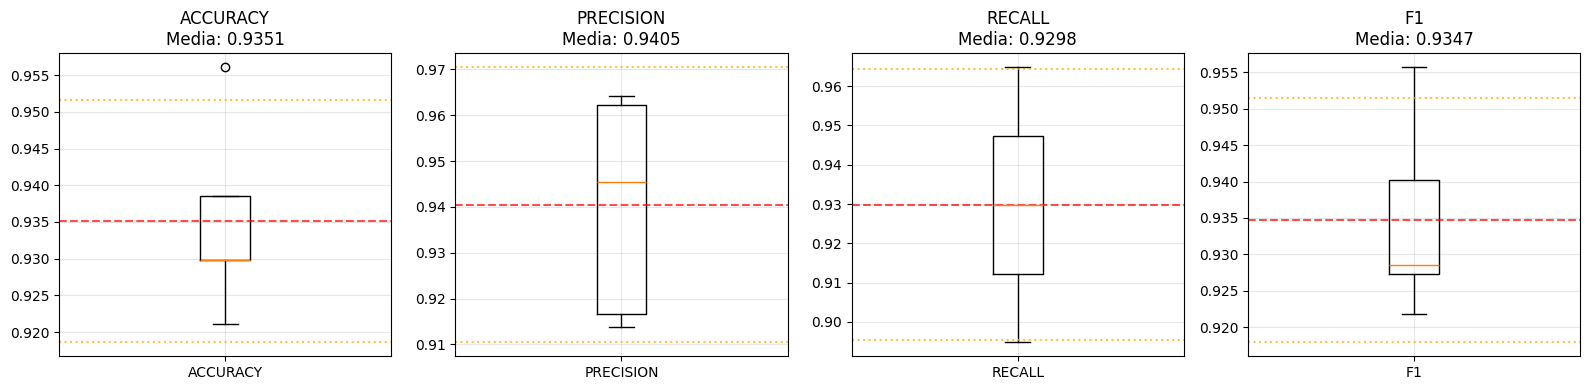


CONFRONTO CON MODELLO DECISION TREE ORIGINALE:
--------------------------------------------------
Accuracy - Originale: 0.9211 | Cross-Val: 0.9351
F1 Score - Originale: 0.8916 | Cross-Val: 0.9347

Cross-validation completata!


In [183]:
# Stratified K-Fold Cross Validation for Decision Tree
# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

print("Stratified K-Fold Cross Validation (5 folds) - Decision Tree...")
print("-" * 50)

# K-fold loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}/5")

    # Split data
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train Decision Tree model
    fold_dt_model = create_and_train_decision_tree(X_fold_train, y_fold_train)

    # Predict and evaluate
    val_pred = fold_dt_model.predict(X_fold_val)

    # Calculate metrics
    acc = accuracy_score(y_fold_val, val_pred)
    prec = precision_score(y_fold_val, val_pred)
    rec = recall_score(y_fold_val, val_pred)
    f1 = f1_score(y_fold_val, val_pred)

    # Store results
    cv_scores['accuracy'].append(acc)
    cv_scores['precision'].append(prec)
    cv_scores['recall'].append(rec)
    cv_scores['f1'].append(f1)

    print(f"  Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

print("-" * 50)

# Calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    margin = stats.sem(data) * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - margin, mean + margin

# Results with confidence intervals
print("RISULTATI CON INTERVALLI DI CONFIDENZA (95%):")
print("-" * 50)

for metric, values in cv_scores.items():
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    print(f"{metric.upper()}: {mean_val:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")

# Simple visualization
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, (metric, values) in enumerate(cv_scores.items()):
    ax[i].boxplot(values, tick_labels=[metric.upper()])
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    ax[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7)
    ax[i].axhline(y=ci_lower, color='orange', linestyle=':', alpha=0.7)
    ax[i].axhline(y=ci_upper, color='orange', linestyle=':', alpha=0.7)
    ax[i].set_title(f'{metric.upper()}\nMedia: {mean_val:.4f}')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quick comparison with original Decision Tree model
print("\nCONFRONTO CON MODELLO DECISION TREE ORIGINALE:")
print("-" * 50)
cv_mean_acc = np.mean(cv_scores['accuracy'])
original_acc = dt_metrics['Accuracy']
print(f"Accuracy - Originale: {original_acc:.4f} | Cross-Val: {cv_mean_acc:.4f}")

cv_mean_f1 = np.mean(cv_scores['f1'])
original_f1 = dt_metrics['F1 Score']
print(f"F1 Score - Originale: {original_f1:.4f} | Cross-Val: {cv_mean_f1:.4f}")

print("\nCross-validation completata!")

# Confronto tra i modelli

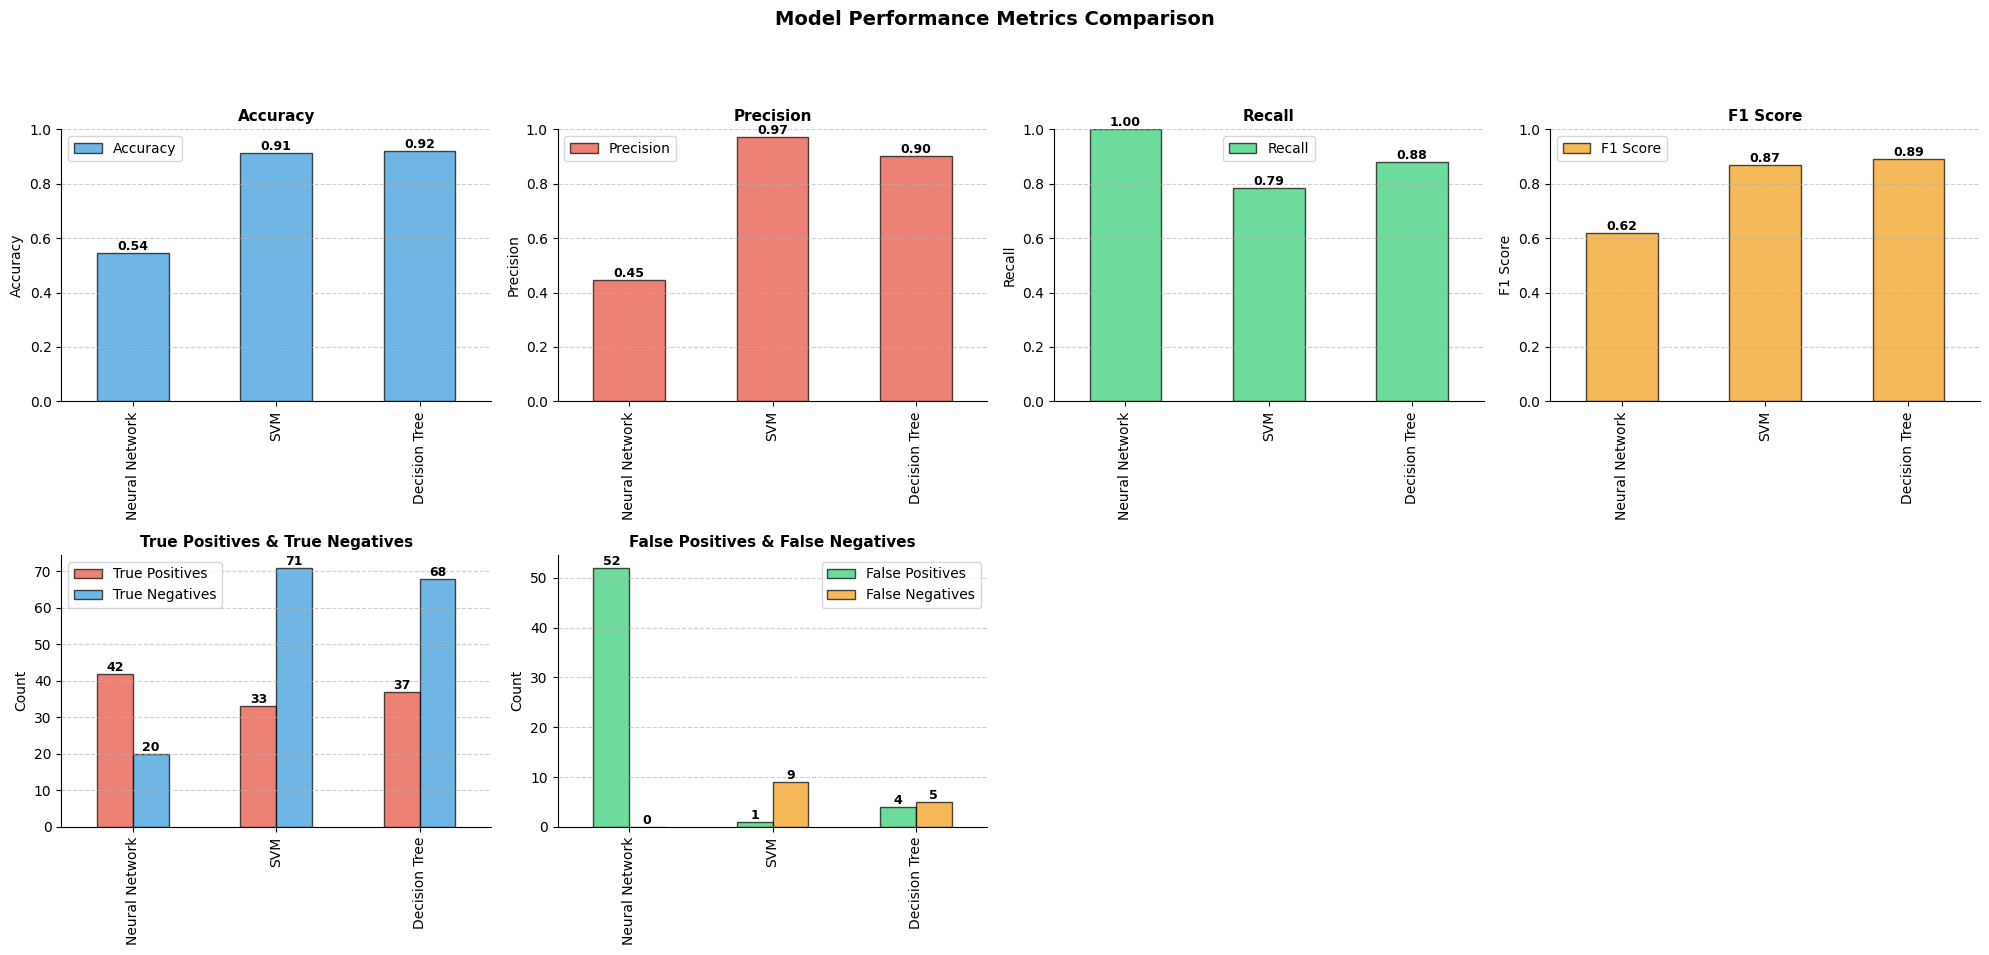

In [184]:
# Visualize Performance Metrics
plot_model_performance_metrics([nn_metrics, svm_metrics, dt_metrics])

# Sporcamento del dataset e analisi degli effetti

Operzioni da svolgere
- valori nulli
- duplicati
- outlier

fare grafici con percentuale di sporcamento, tipologia di sporcamento e tipologia di elemento su cui viene applicato.

🎯 Obiettivo dello sporcamento <br>
Hai detto che vuoi valutare come i modelli reagiscono alla contaminazione (rumore). Quindi:

🔬 Se vuoi valutare la robustezza all’apprendimento con dati rumorosi:
➡️ Sporca solo il set di training.

Perché?

In questo caso vuoi simulare un contesto in cui il modello ha a disposizione dati di addestramento imprecisi (etichette o feature sbagliate), ma viene valutato su dati puliti.

Così misuri quanto il modello riesce a generalizzare bene nonostante il rumore in input.

🧪 Esempio realistico:<br>
- In un caso reale, potresti avere errori di annotazione nei dati raccolti (es. etichette sbagliate da medici junior), ma i test vengono eseguiti su casi noti e ben verificati.

🧪 Se sporchi anche il test set: <br>
- ➡️ Stai misurando la combinazione tra apprendimento difficile + valutazione difficile.

Problemi:

- Il modello potrebbe fare errori perché ha imparato male, ma anche perché il test è “ingiusto”.

- Le performance metriche diventano meno interpretabili: non distingui se l’errore viene dall’apprendimento o dalla valutazione.

🔴 Quindi: questo approccio è sconsigliato, a meno che tu voglia studiare scenari estremi (tipo "worst-case contamination").

✅ Conclusione chiara:
- Sporca solo il set di training, non il test.
- Il test deve rimanere pulito, così puoi valutare in modo chiaro quanto il rumore in fase di apprendimento compromette la capacità predittiva del modello.

📝 Frase utile per la relazione: <br>
“Per valutare la robustezza dei modelli all’introduzione di rumore, il rumore è stato applicato esclusivamente al set di training, mentre il set di test è rimasto intatto. Questo consente di isolare l’effetto del rumore sull’apprendimento, garantendo una valutazione equa e significativa delle prestazioni.”

Il rumore è stato applicato esclusivamente al training set, preservando il test set per una valutazione imparziale delle prestazioni. Questo approccio sistematico consente di studiare l’impatto specifico del rumore sul comportamento dei modelli, garantendo un’analisi controllata e approfondita.

🤔 Devo applicare la validazione anche in questa fase?

Fare una stima robusta delle performance in presenza di missing values ➜ SÌ, dovresti rifare la validazione.
In questo caso, dovresti:

- Applicare il rumore (valori nulli) dentro ogni fold.

- Imputare i NaN dentro il ciclo.

- Addestrare e validare come hai fatto con StratifiedKFold.

In [192]:
# ====================================================================
# FUNZIONI COMUNI
# ====================================================================

def plot_performance_evolution(all_results, percentages, title_suffix=""):
    """
    Visualizza l'evoluzione delle performance dei modelli al variare della percentuale di sporcamento.
    """
    models = ['Neural Network', 'SVM', 'Decision Tree']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    performance_data = {model: {metric: [] for metric in metrics} for model in models}

    for results in all_results:
        for i, result in enumerate(results):
            model = models[i]
            for metric in metrics:
                performance_data[model][metric].append(result[metric])

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'Evoluzione delle Performance dei Modelli {title_suffix}', fontsize=16, fontweight='bold')

    colors = ['#3498db', '#e74c3c', '#2ecc71']

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        for j, model in enumerate(models):
            ax.plot(percentages, performance_data[model][metric],
                   marker='o', linewidth=2, markersize=6, label=model, color=colors[j])

        ax.set_xlabel('Percentuale Sporcamento (%)')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} vs Percentuale Sporcamento')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def create_corruption_heatmap(all_results, percentages, title_suffix=""):
    """
    Crea una heatmap per visualizzare le performance dei modelli.
    """
    models = ['Neural Network', 'SVM', 'Decision Tree']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle(f'Heatmap Performance {title_suffix}', fontsize=16, fontweight='bold')

    for i, metric in enumerate(metrics):
        data_matrix = []
        for results in all_results:
            row = [result[metric] for result in results]
            data_matrix.append(row)

        row = i // 2
        col = i % 2
        ax = axes[row, col]

        sns.heatmap(data_matrix,
                   xticklabels=models,
                   yticklabels=[f'{p:.0%}' for p in percentages],
                   annot=True, fmt='.3f', cmap='RdYlBu_r',
                   cbar_kws={'label': metric},
                   ax=ax)
        ax.set_title(f'Heatmap {metric}')
        ax.set_xlabel('Modelli')
        ax.set_ylabel('Percentuale Sporcamento')

    plt.tight_layout()
    plt.show()

def train_and_evaluate_models(X_train, X_test, y_train, y_test, corruption_type, corruption_percentage):
    """
    Addestra e valuta i modelli con dati corrotti.
    """
    metrics_list = []

    # Neural Network
    print(f"\nAddestramento Neural Network con {corruption_percentage:.0%} {corruption_type}...")
    input_shape = (X_train.shape[1],)
    nn_model = create_neural_network_model(input_shape)
    history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

    nn_pred = (nn_model.predict(X_test) > 0.5).astype(int).flatten()
    nn_metrics = evaluate_model_performance(y_test, nn_pred, f'Neural Network ({corruption_percentage:.0%} {corruption_type})')
    metrics_list.append(nn_metrics)

    # SVM
    print(f"\nAddestramento SVM con {corruption_percentage:.0%} {corruption_type}...")
    svm_model = create_and_train_svm_model(X_train, y_train)
    svm_pred = svm_model.predict(X_test)
    svm_metrics = evaluate_model_performance(y_test, svm_pred, f'SVM ({corruption_percentage:.0%} {corruption_type})')
    metrics_list.append(svm_metrics)

    # Decision Tree
    print(f"\nAddestramento Decision Tree con {corruption_percentage:.0%} {corruption_type}...")
    dt_model = create_and_train_decision_tree(X_train, y_train)
    dt_pred = dt_model.predict(X_test)
    dt_metrics = evaluate_model_performance(y_test, dt_pred, f'Decision Tree ({corruption_percentage:.0%} {corruption_type})')
    metrics_list.append(dt_metrics)

    return metrics_list

def print_statistical_analysis(all_results, corruption_type):
    """
    Stampa l'analisi statistica finale.
    """
    print(f"\n{'='*60}")
    print(f"ANALISI STATISTICA FINALE - {corruption_type.upper()}")
    print(f"{'='*60}")

    models = ['Neural Network', 'SVM', 'Decision Tree']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    for i, model in enumerate(models):
        print(f"\n{model.upper()}:")
        print("-" * 40)

        for metric in metrics:
            values = [results[i][metric] for results in all_results]
            initial_value = values[0]
            final_value = values[-1]
            degradation = initial_value - final_value
            degradation_pct = (degradation / initial_value) * 100

            print(f"{metric:12}: {initial_value:.3f} → {final_value:.3f} "
                  f"(degrado: {degradation:.3f}, {degradation_pct:.1f}%)")

# Valori nulli

In [196]:
# ====================================================================
# FUNZIONI SPORCAMENTO VALORI NULLI
# ====================================================================

def introduce_missing_data(dataset, percentage):
    """
    Introduce valori nulli in modo casuale nel dataset.
    """
    dataset_with_nulls = dataset.copy()
    num_missing = int(len(dataset_with_nulls) * dataset_with_nulls.shape[1] * percentage)

    for _ in range(num_missing):
        row_idx = np.random.randint(0, len(dataset_with_nulls))
        col_idx = np.random.randint(0, dataset_with_nulls.shape[1])
        dataset_with_nulls.iloc[row_idx, col_idx] = np.nan

    return dataset_with_nulls

def handle_missing_values(X_train, X_test, imputer_type='simple'):
    """
    Gestisce i valori mancanti utilizzando SimpleImputer.
    """
    if imputer_type == 'simple':
        imputer = SimpleImputer(strategy='mean')
    elif imputer_type == 'knn':
        imputer = KNNImputer(n_neighbors=5)

    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )

    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    return X_train_imputed, X_test_imputed

ANALISI DELL'IMPATTO DEI VALORI MANCANTI SULLE PERFORMANCE

ANALISI CON 10% VALORI MANCANTI
Valori mancanti introdotti: 1643/17100 (9.6%)

Addestramento Neural Network con 10% valori mancanti...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Neural Network (10% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        72
           1       1.00      0.40      0.58        42

    accuracy                           0.78       114
   macro avg       0.87      0.70      0.71       114
weighted avg       0.84      0.78      0.75       114


Neural Network (10% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.7807
Precision: 1.0000
Recall:    0.4048
F1 Score:  0.5763


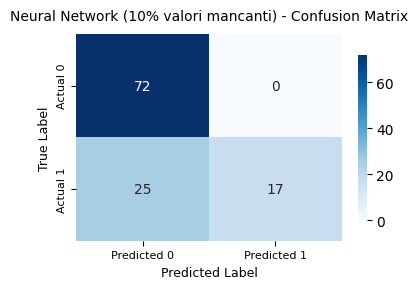


Addestramento SVM con 10% valori mancanti...

SVM (10% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        72
           1       0.94      0.76      0.84        42

    accuracy                           0.89       114
   macro avg       0.91      0.87      0.88       114
weighted avg       0.90      0.89      0.89       114


SVM (10% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8947
Precision: 0.9412
Recall:    0.7619
F1 Score:  0.8421


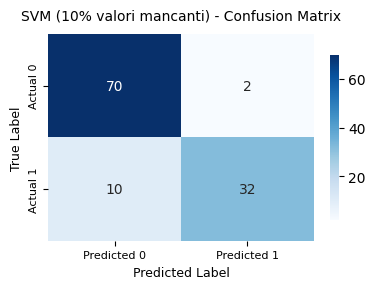


Addestramento Decision Tree con 10% valori mancanti...

Decision Tree (10% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        72
           1       0.90      0.83      0.86        42

    accuracy                           0.90       114
   macro avg       0.90      0.89      0.89       114
weighted avg       0.90      0.90      0.90       114


Decision Tree (10% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.9035
Precision: 0.8974
Recall:    0.8333
F1 Score:  0.8642


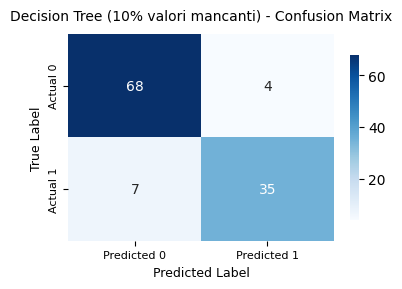


Visualizzazione performance con 10% valori mancanti:


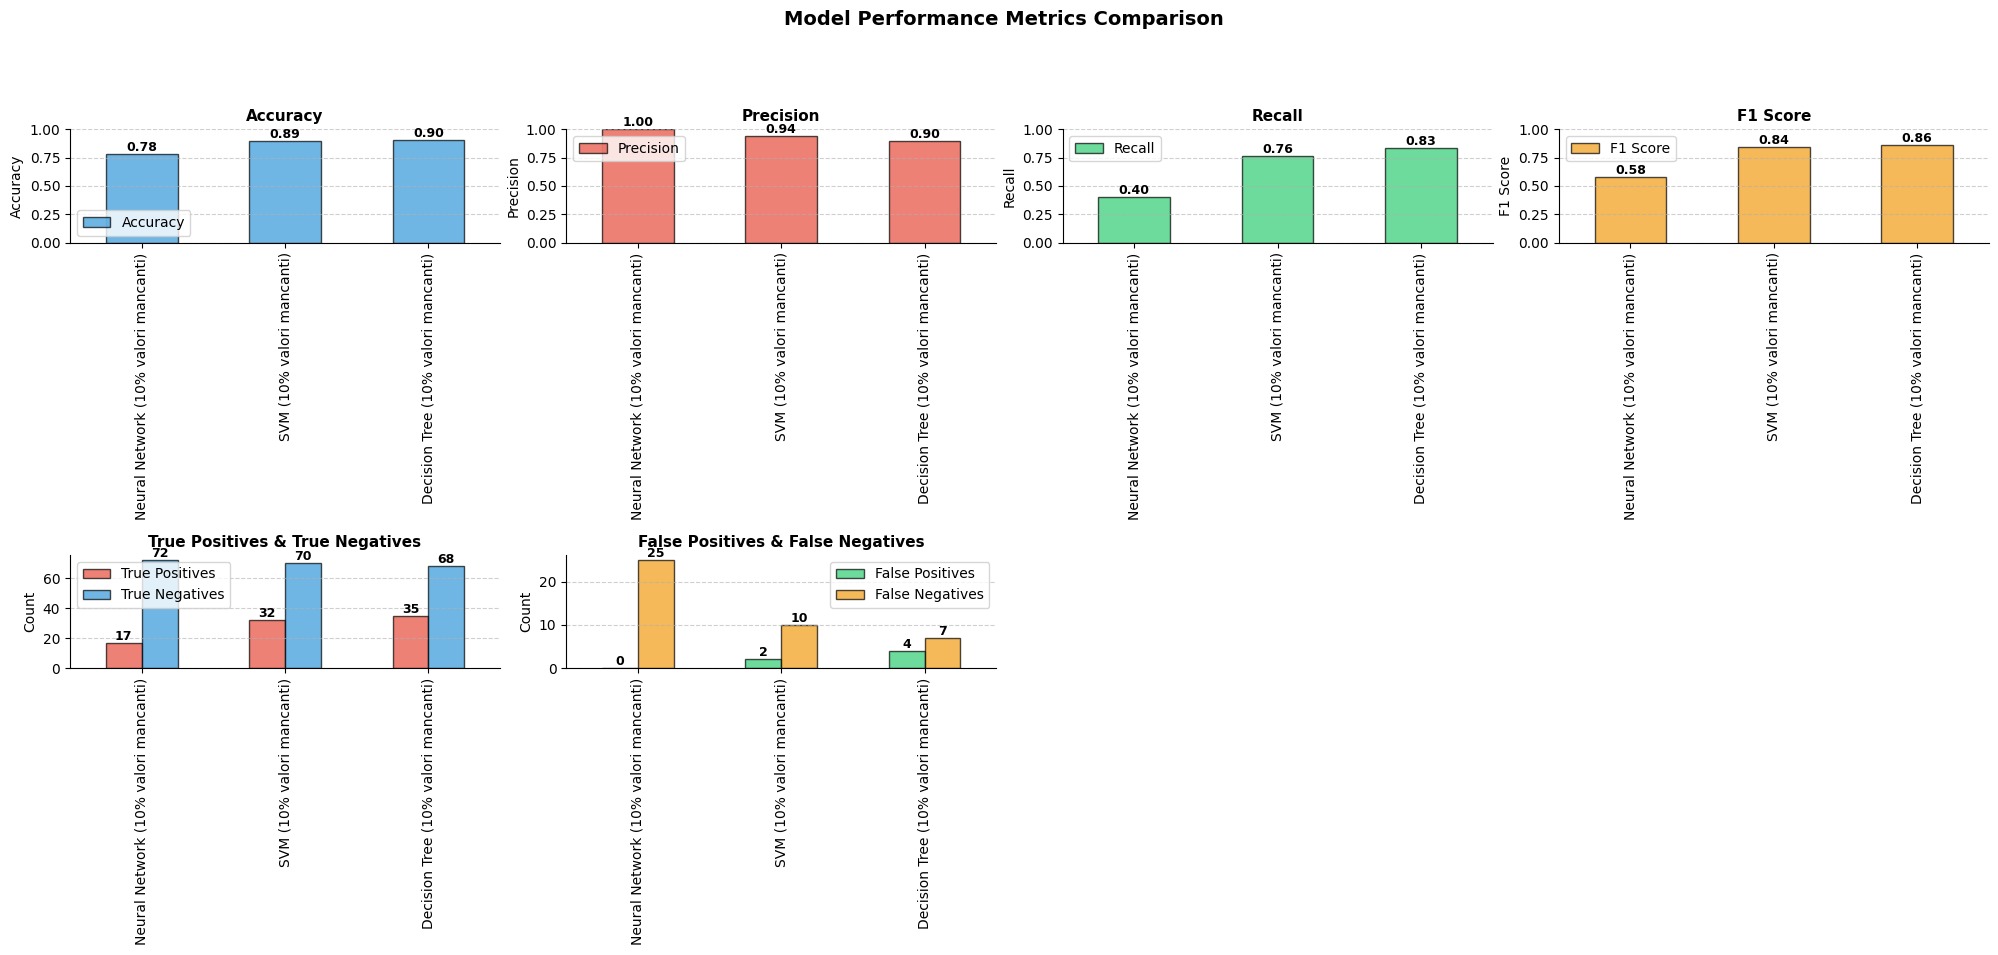


ANALISI CON 20% VALORI MANCANTI
Valori mancanti introdotti: 3117/17100 (18.2%)

Addestramento Neural Network con 20% valori mancanti...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Neural Network (20% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        72
           1       0.78      0.86      0.82        42

    accuracy                           0.86       114
   macro avg       0.85      0.86      0.85       114
weighted avg       0.86      0.86      0.86       114


Neural Network (20% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8596
Precision: 0.7826
Recall:    0.8571
F1 Score:  0.8182


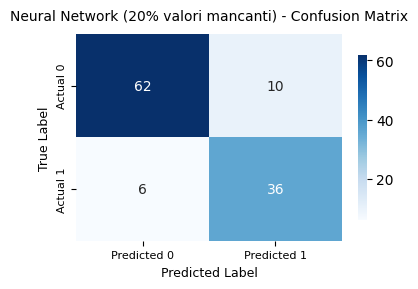


Addestramento SVM con 20% valori mancanti...

SVM (20% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92        72
           1       0.97      0.71      0.82        42

    accuracy                           0.89       114
   macro avg       0.91      0.85      0.87       114
weighted avg       0.90      0.89      0.88       114


SVM (20% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8860
Precision: 0.9677
Recall:    0.7143
F1 Score:  0.8219


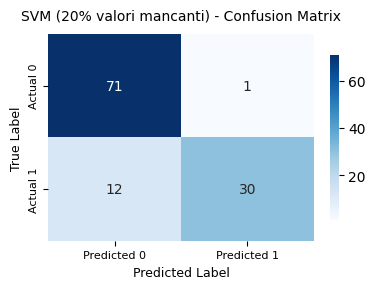


Addestramento Decision Tree con 20% valori mancanti...

Decision Tree (20% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94        72
           1       0.90      0.88      0.89        42

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114


Decision Tree (20% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.9211
Precision: 0.9024
Recall:    0.8810
F1 Score:  0.8916


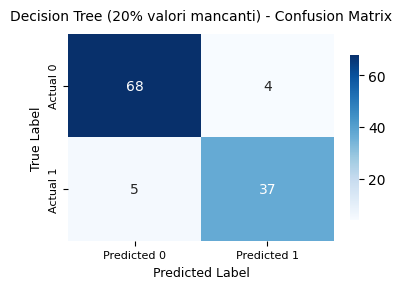


Visualizzazione performance con 20% valori mancanti:


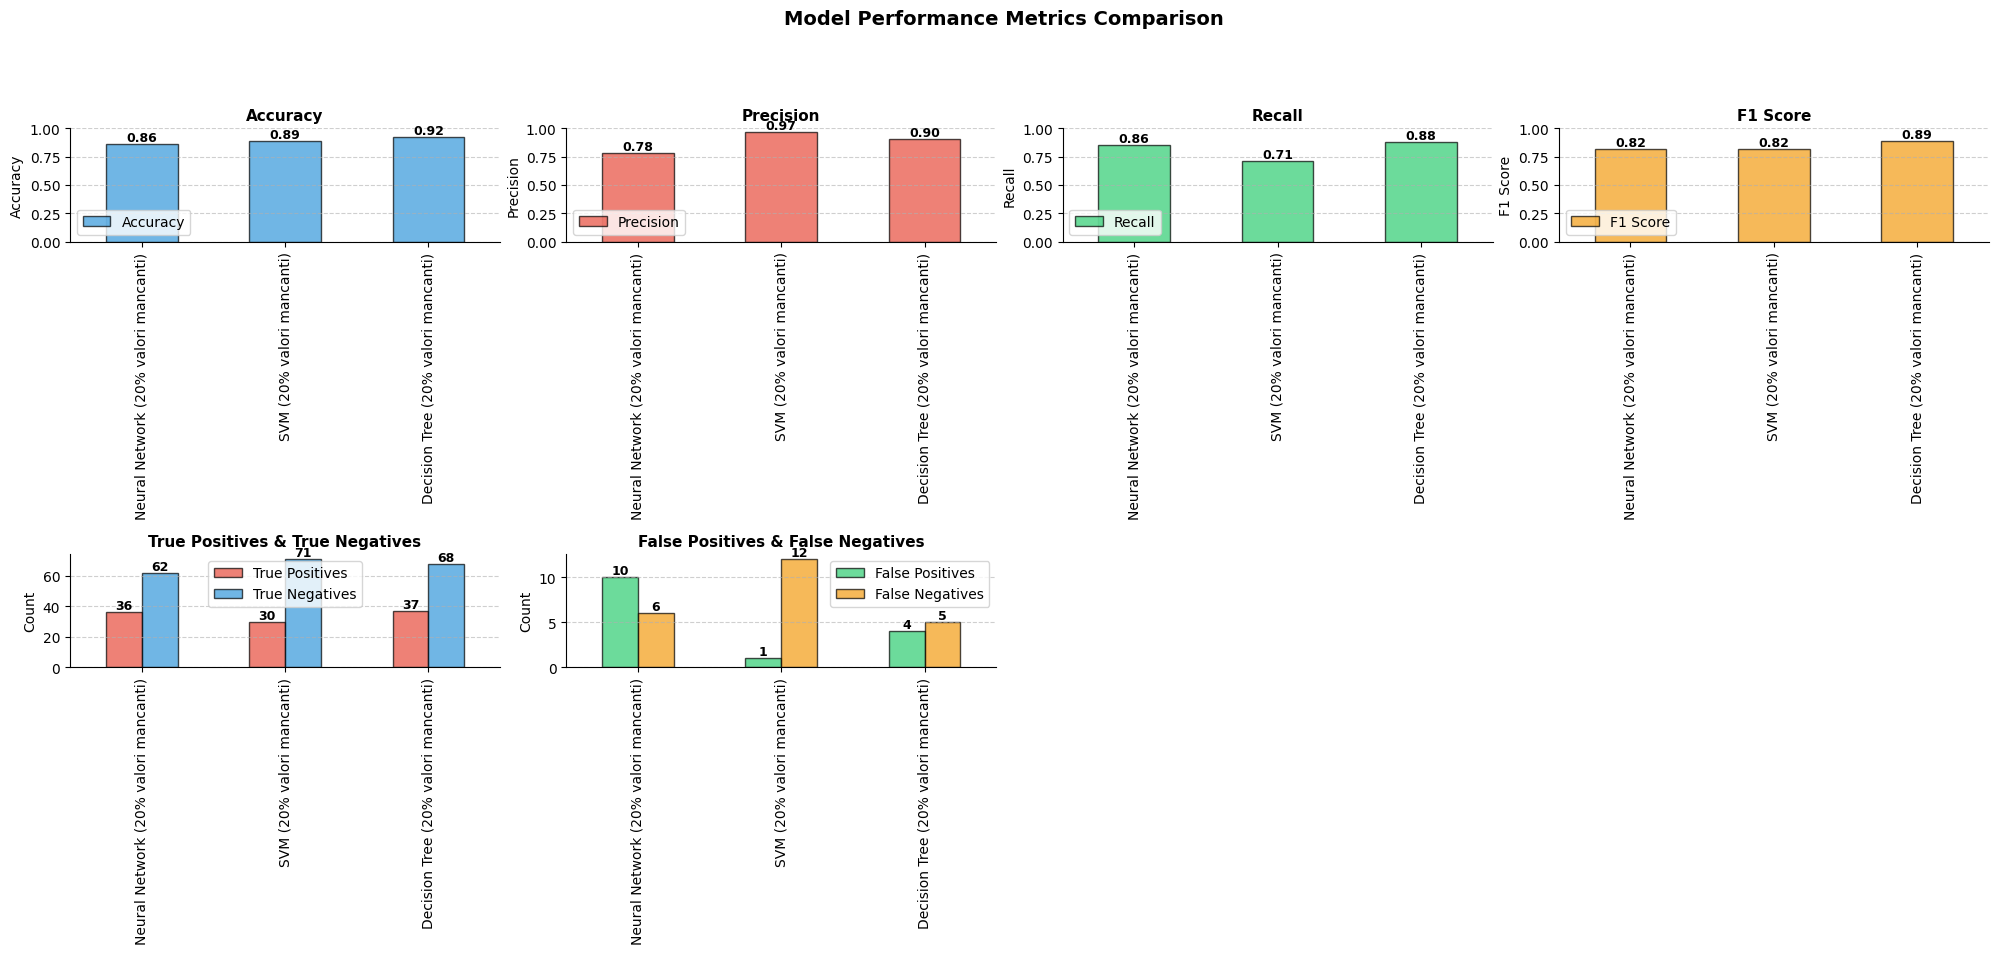


ANALISI CON 30% VALORI MANCANTI
Valori mancanti introdotti: 4444/17100 (26.0%)

Addestramento Neural Network con 30% valori mancanti...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Neural Network (30% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        72
           1       1.00      0.62      0.76        42

    accuracy                           0.86       114
   macro avg       0.91      0.81      0.83       114
weighted avg       0.89      0.86      0.85       114


Neural Network (30% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8596
Precision: 1.0000
Recall:    0.6190
F1 Score:  0.7647


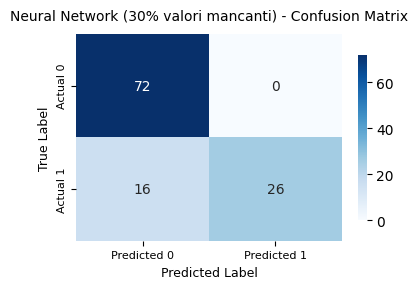


Addestramento SVM con 30% valori mancanti...

SVM (30% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92        72
           1       0.97      0.71      0.82        42

    accuracy                           0.89       114
   macro avg       0.91      0.85      0.87       114
weighted avg       0.90      0.89      0.88       114


SVM (30% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8860
Precision: 0.9677
Recall:    0.7143
F1 Score:  0.8219


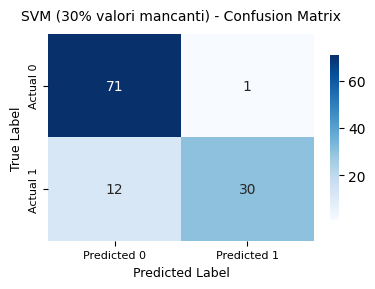


Addestramento Decision Tree con 30% valori mancanti...

Decision Tree (30% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94        72
           1       0.90      0.88      0.89        42

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114


Decision Tree (30% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.9211
Precision: 0.9024
Recall:    0.8810
F1 Score:  0.8916


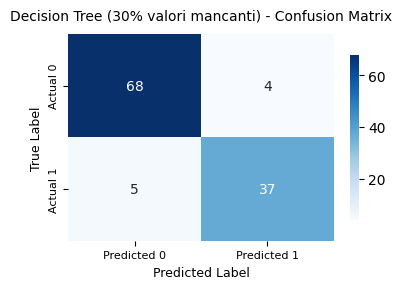


Visualizzazione performance con 30% valori mancanti:


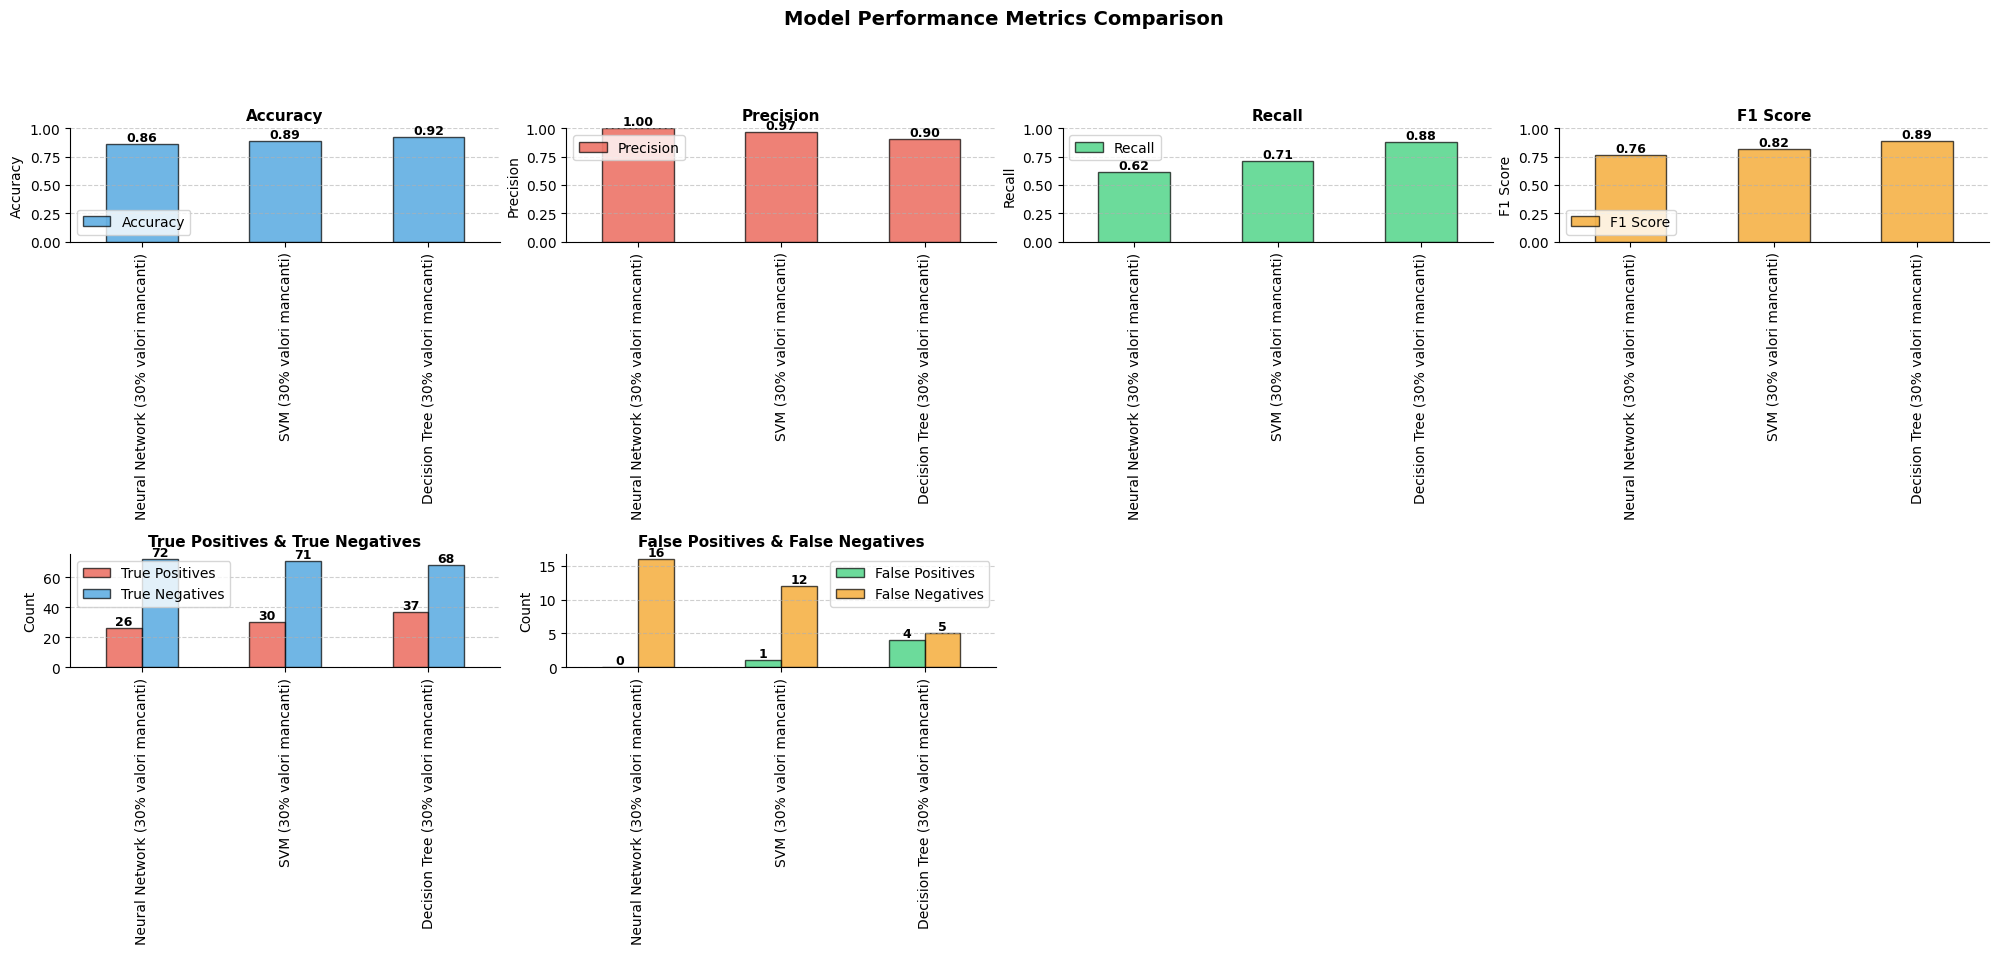


ANALISI CON 40% VALORI MANCANTI
Valori mancanti introdotti: 5618/17100 (32.9%)

Addestramento Neural Network con 40% valori mancanti...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Neural Network (40% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90        72
           1       0.96      0.64      0.77        42

    accuracy                           0.86       114
   macro avg       0.89      0.81      0.84       114
weighted avg       0.88      0.86      0.85       114


Neural Network (40% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8596
Precision: 0.9643
Recall:    0.6429
F1 Score:  0.7714


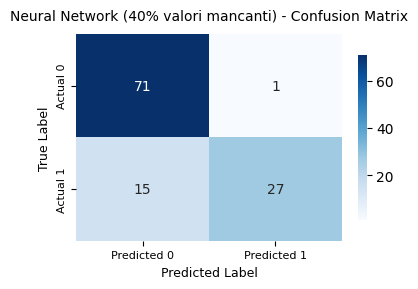


Addestramento SVM con 40% valori mancanti...

SVM (40% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92        72
           1       0.97      0.71      0.82        42

    accuracy                           0.89       114
   macro avg       0.91      0.85      0.87       114
weighted avg       0.90      0.89      0.88       114


SVM (40% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8860
Precision: 0.9677
Recall:    0.7143
F1 Score:  0.8219


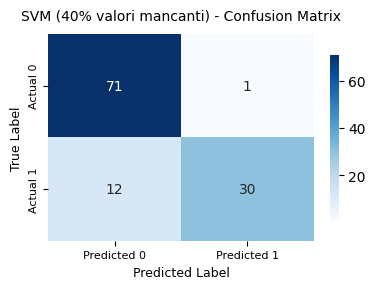


Addestramento Decision Tree con 40% valori mancanti...

Decision Tree (40% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        72
           1       0.88      0.88      0.88        42

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114


Decision Tree (40% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.8810
Recall:    0.8810
F1 Score:  0.8810


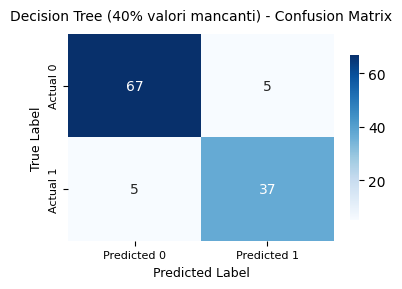


Visualizzazione performance con 40% valori mancanti:


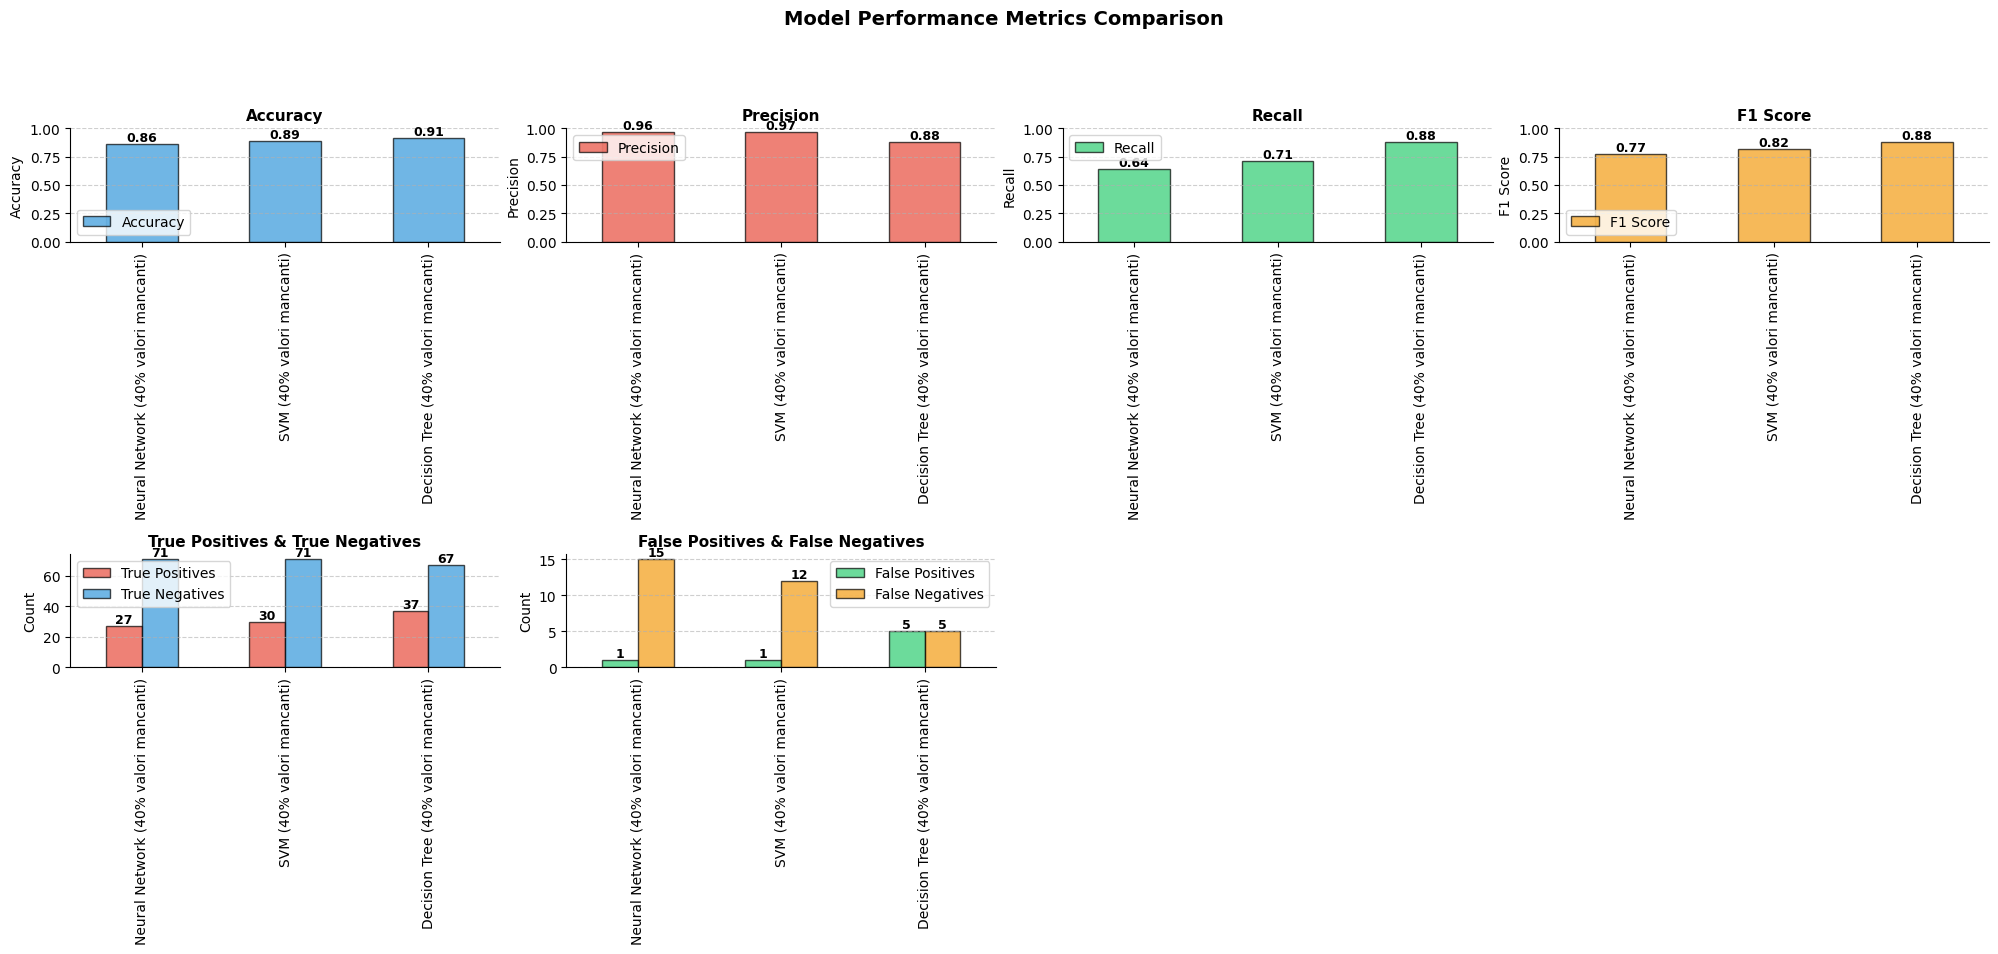


ANALISI CON 50% VALORI MANCANTI
Valori mancanti introdotti: 6677/17100 (39.0%)

Addestramento Neural Network con 50% valori mancanti...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Neural Network (50% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.14      0.24        72
           1       0.40      1.00      0.58        42

    accuracy                           0.46       114
   macro avg       0.70      0.57      0.41       114
weighted avg       0.78      0.46      0.37       114


Neural Network (50% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.4561
Precision: 0.4038
Recall:    1.0000
F1 Score:  0.5753


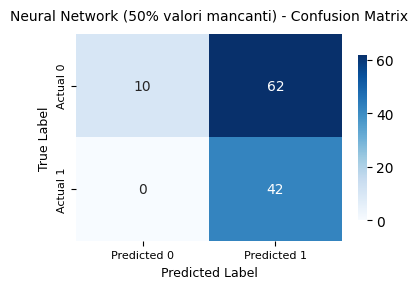


Addestramento SVM con 50% valori mancanti...

SVM (50% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92        72
           1       0.97      0.71      0.82        42

    accuracy                           0.89       114
   macro avg       0.91      0.85      0.87       114
weighted avg       0.90      0.89      0.88       114


SVM (50% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8860
Precision: 0.9677
Recall:    0.7143
F1 Score:  0.8219


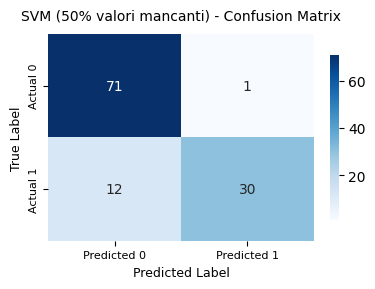


Addestramento Decision Tree con 50% valori mancanti...

Decision Tree (50% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        72
           1       0.84      0.88      0.86        42

    accuracy                           0.89       114
   macro avg       0.88      0.89      0.89       114
weighted avg       0.90      0.89      0.90       114


Decision Tree (50% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8947
Precision: 0.8409
Recall:    0.8810
F1 Score:  0.8605


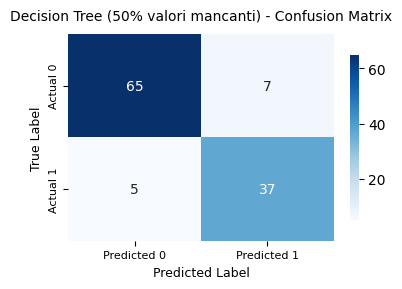


Visualizzazione performance con 50% valori mancanti:


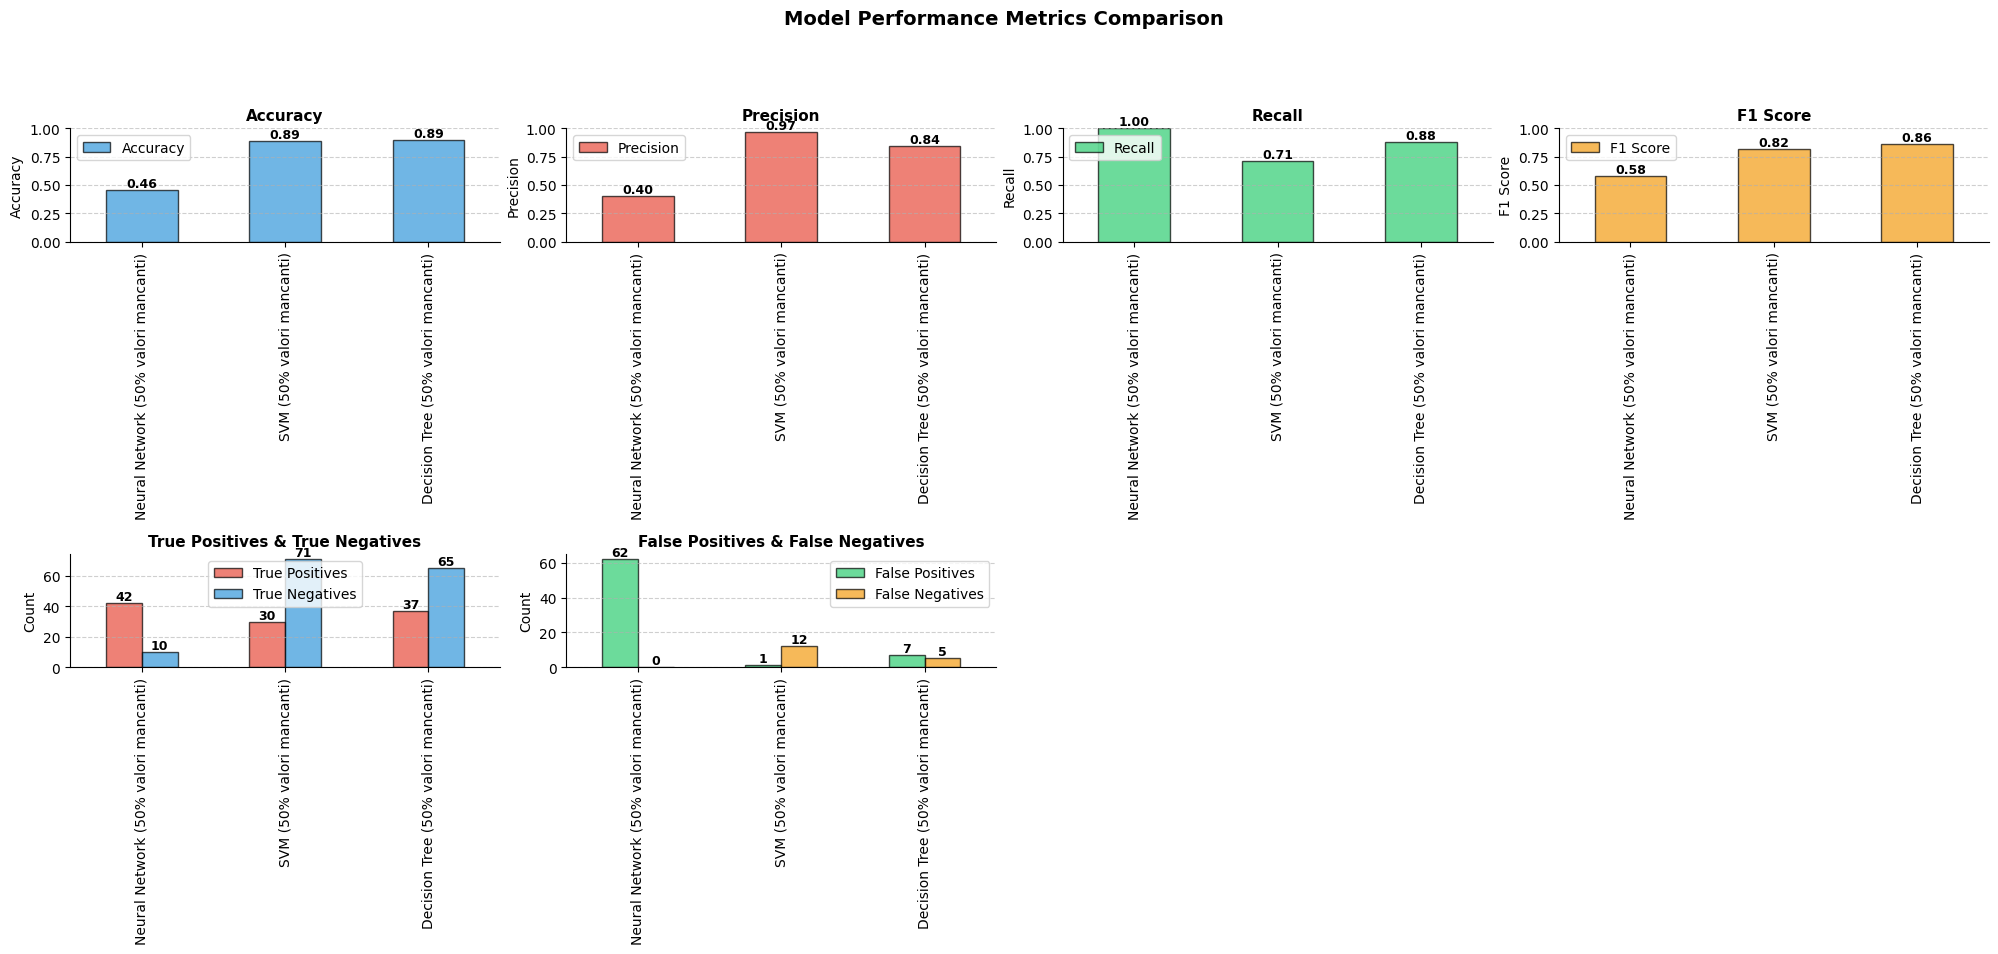


ANALISI CON 60% VALORI MANCANTI
Valori mancanti introdotti: 7692/17100 (45.0%)

Addestramento Neural Network con 60% valori mancanti...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Neural Network (60% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        72
           1       1.00      0.10      0.17        42

    accuracy                           0.67       114
   macro avg       0.83      0.55      0.48       114
weighted avg       0.78      0.67      0.56       114


Neural Network (60% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.6667
Precision: 1.0000
Recall:    0.0952
F1 Score:  0.1739


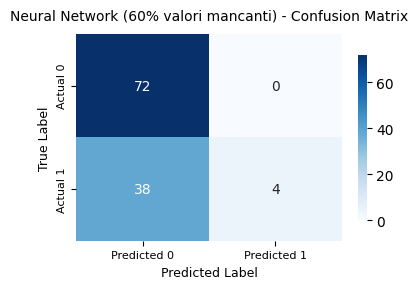


Addestramento SVM con 60% valori mancanti...

SVM (60% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92        72
           1       0.97      0.71      0.82        42

    accuracy                           0.89       114
   macro avg       0.91      0.85      0.87       114
weighted avg       0.90      0.89      0.88       114


SVM (60% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8860
Precision: 0.9677
Recall:    0.7143
F1 Score:  0.8219


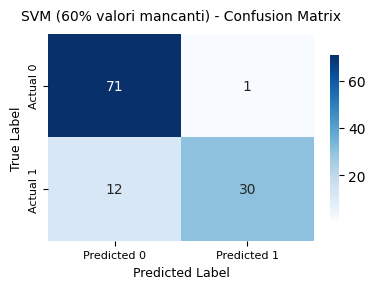


Addestramento Decision Tree con 60% valori mancanti...

Decision Tree (60% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        72
           1       0.80      0.83      0.81        42

    accuracy                           0.86       114
   macro avg       0.85      0.85      0.85       114
weighted avg       0.86      0.86      0.86       114


Decision Tree (60% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8596
Precision: 0.7955
Recall:    0.8333
F1 Score:  0.8140


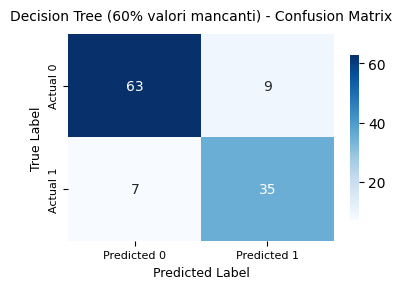


Visualizzazione performance con 60% valori mancanti:


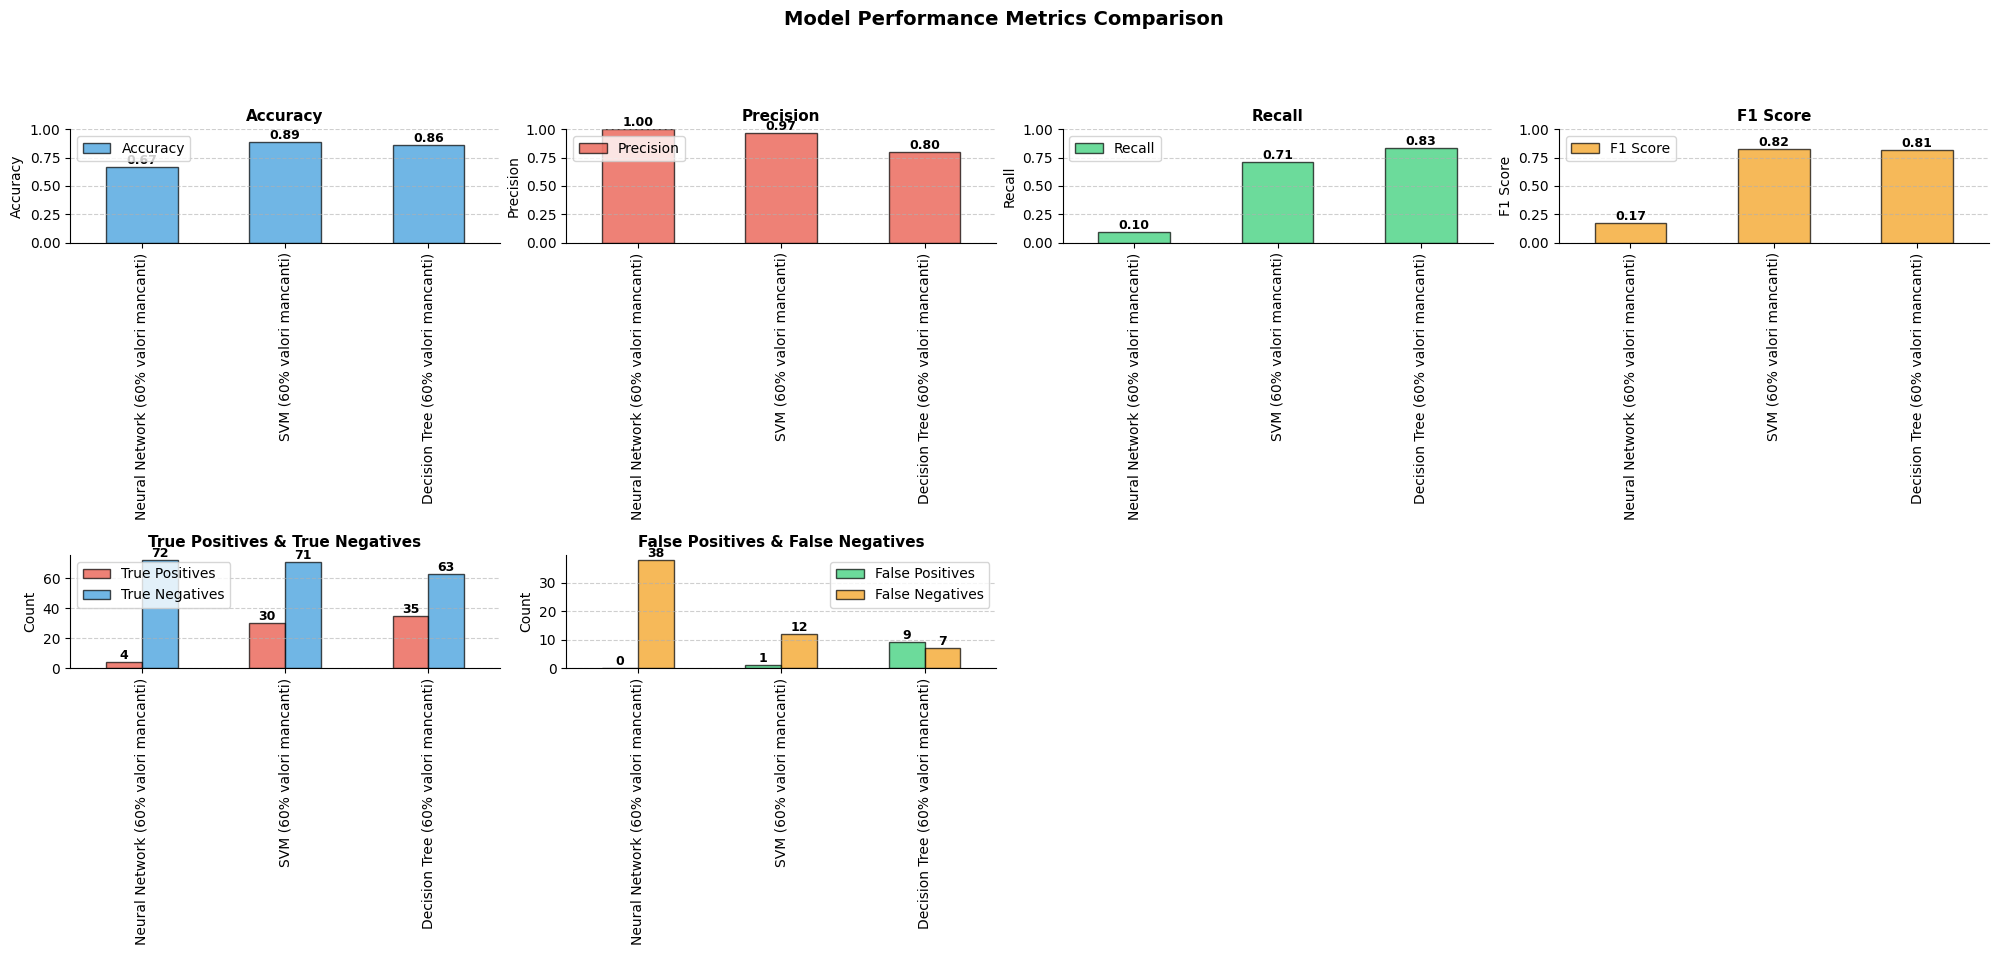


ANALISI CON 70% VALORI MANCANTI
Valori mancanti introdotti: 8629/17100 (50.5%)

Addestramento Neural Network con 70% valori mancanti...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Neural Network (70% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.89        72
           1       0.96      0.62      0.75        42

    accuracy                           0.85       114
   macro avg       0.89      0.80      0.82       114
weighted avg       0.87      0.85      0.84       114


Neural Network (70% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8509
Precision: 0.9630
Recall:    0.6190
F1 Score:  0.7536


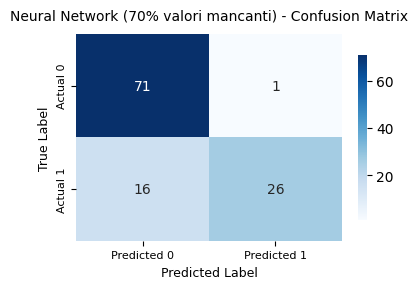


Addestramento SVM con 70% valori mancanti...

SVM (70% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        72
           1       1.00      0.71      0.83        42

    accuracy                           0.89       114
   macro avg       0.93      0.86      0.88       114
weighted avg       0.91      0.89      0.89       114


SVM (70% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8947
Precision: 1.0000
Recall:    0.7143
F1 Score:  0.8333


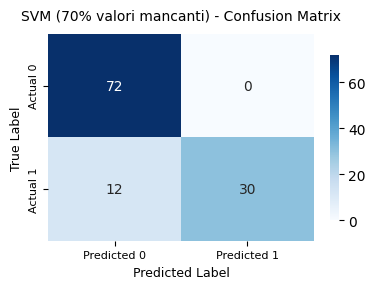


Addestramento Decision Tree con 70% valori mancanti...

Decision Tree (70% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        72
           1       0.78      1.00      0.88        42

    accuracy                           0.89       114
   macro avg       0.89      0.92      0.89       114
weighted avg       0.92      0.89      0.90       114


Decision Tree (70% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8947
Precision: 0.7778
Recall:    1.0000
F1 Score:  0.8750


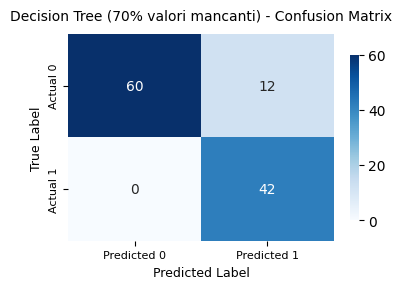


Visualizzazione performance con 70% valori mancanti:


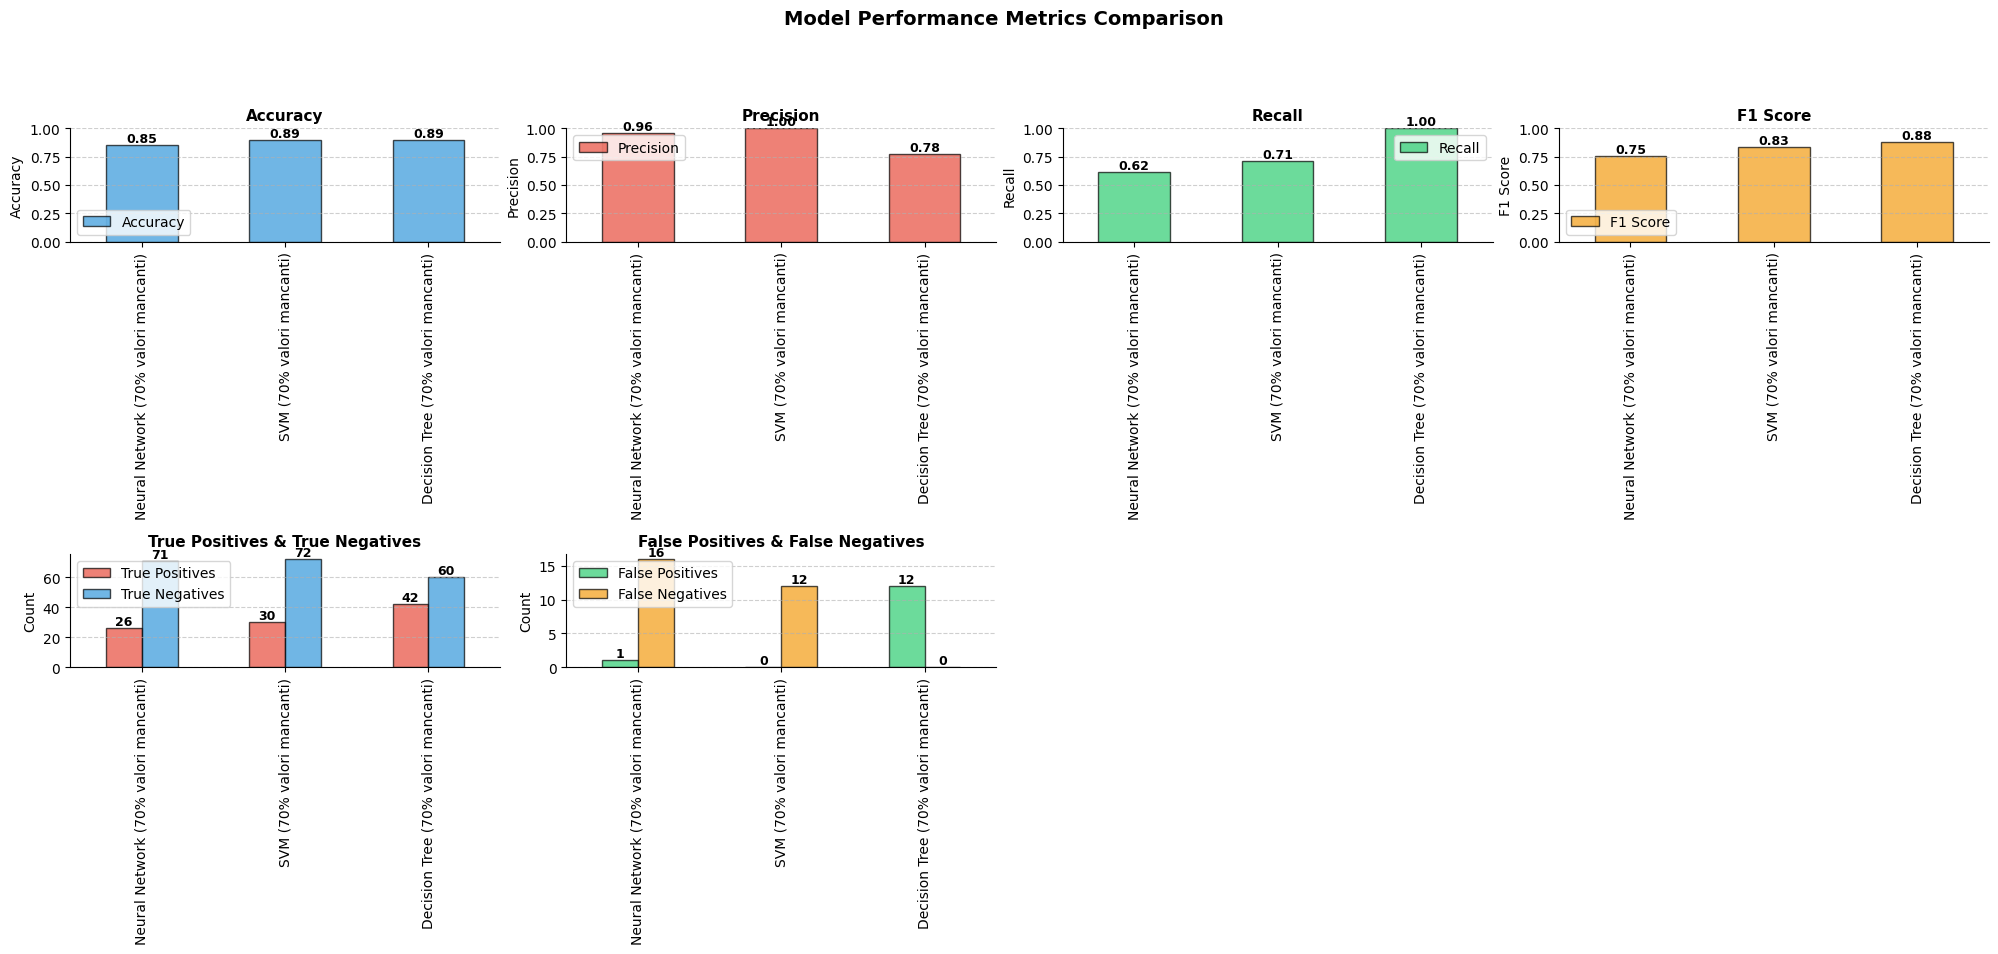


ANALISI CON 80% VALORI MANCANTI
Valori mancanti introdotti: 9418/17100 (55.1%)

Addestramento Neural Network con 80% valori mancanti...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Neural Network (80% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        72
           1       1.00      0.57      0.73        42

    accuracy                           0.84       114
   macro avg       0.90      0.79      0.81       114
weighted avg       0.87      0.84      0.83       114


Neural Network (80% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8421
Precision: 1.0000
Recall:    0.5714
F1 Score:  0.7273


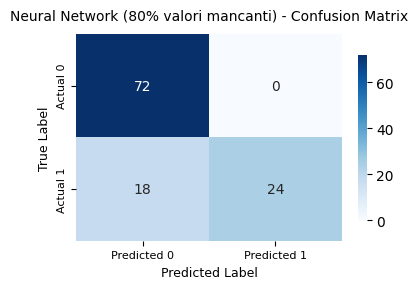


Addestramento SVM con 80% valori mancanti...

SVM (80% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        72
           1       1.00      0.71      0.83        42

    accuracy                           0.89       114
   macro avg       0.93      0.86      0.88       114
weighted avg       0.91      0.89      0.89       114


SVM (80% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8947
Precision: 1.0000
Recall:    0.7143
F1 Score:  0.8333


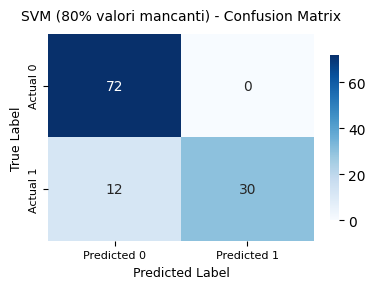


Addestramento Decision Tree con 80% valori mancanti...

Decision Tree (80% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        72
           1       0.79      0.90      0.84        42

    accuracy                           0.88       114
   macro avg       0.87      0.88      0.87       114
weighted avg       0.88      0.88      0.88       114


Decision Tree (80% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8772
Precision: 0.7917
Recall:    0.9048
F1 Score:  0.8444


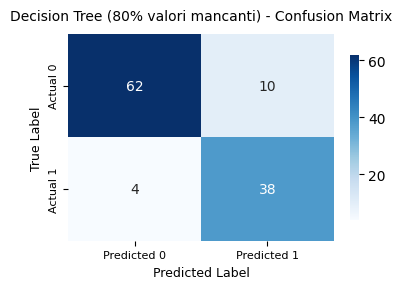


Visualizzazione performance con 80% valori mancanti:


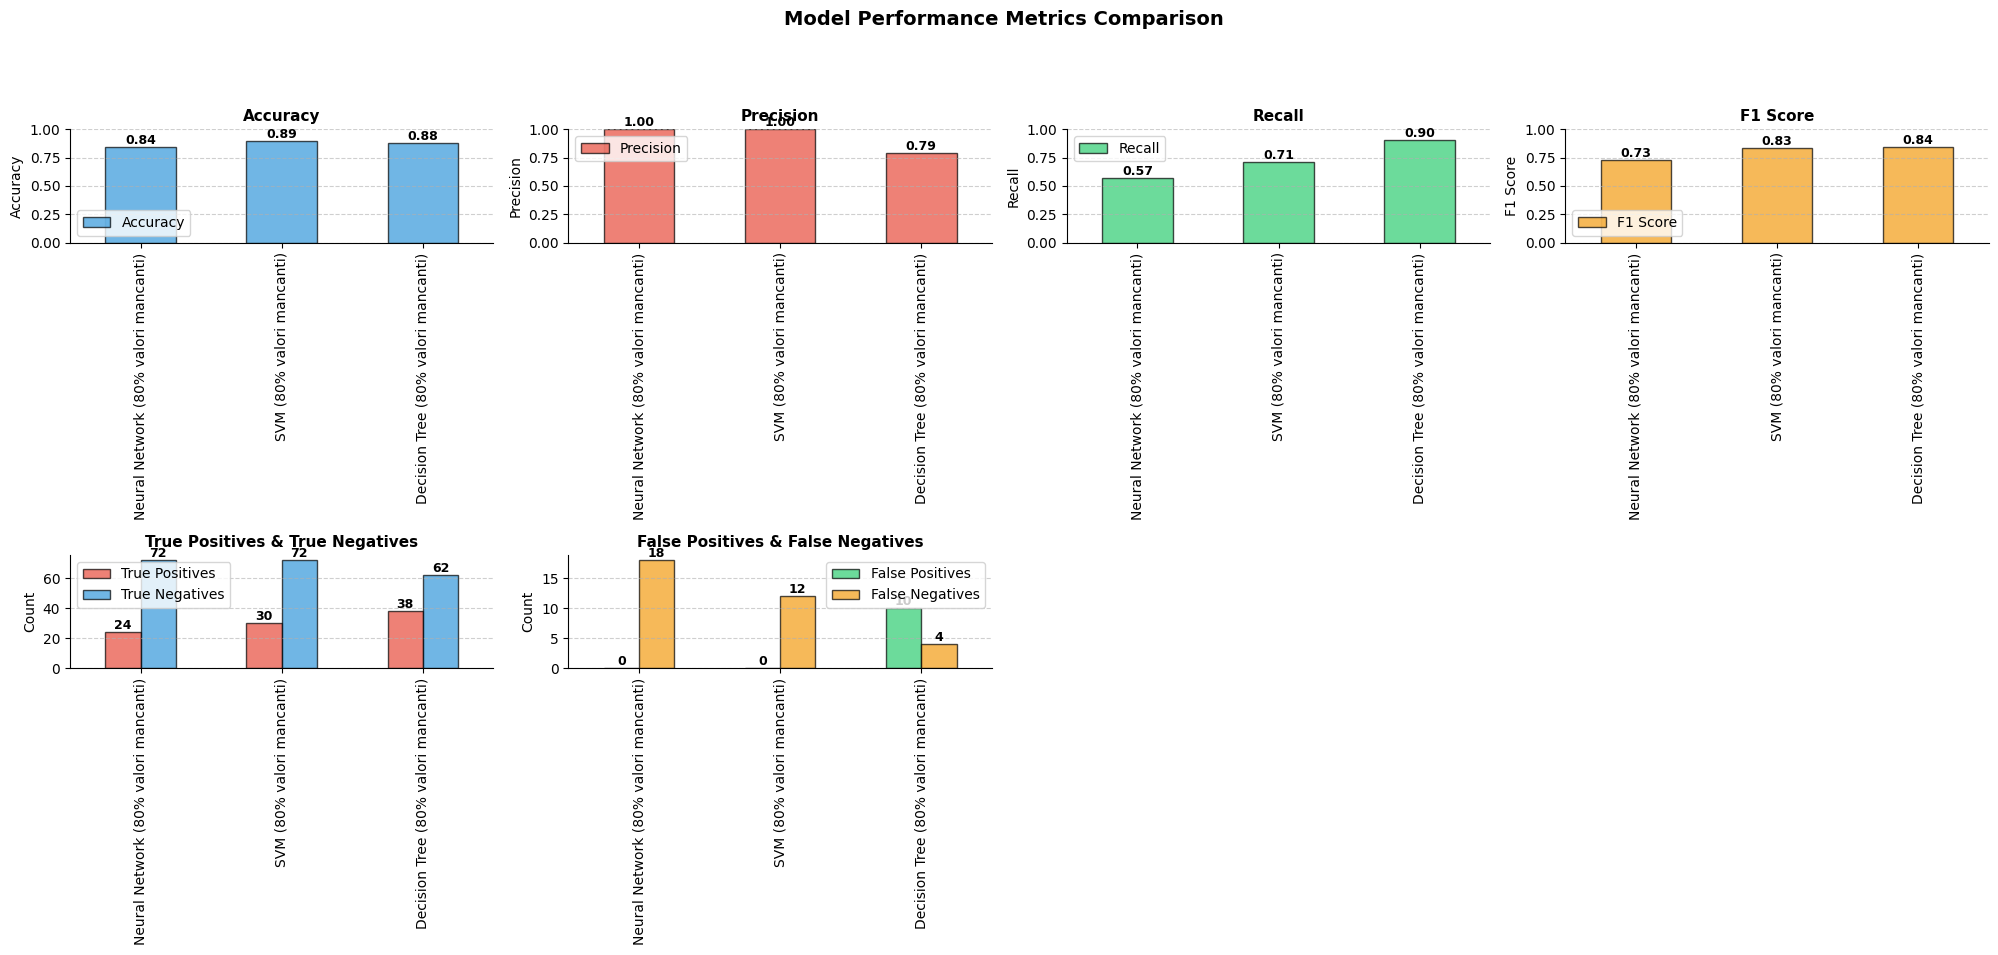


ANALISI CON 90% VALORI MANCANTI
Valori mancanti introdotti: 10099/17100 (59.1%)

Addestramento Neural Network con 90% valori mancanti...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Neural Network (90% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.26      0.41        72
           1       0.44      0.98      0.60        42

    accuracy                           0.53       114
   macro avg       0.69      0.62      0.51       114
weighted avg       0.76      0.53      0.48       114


Neural Network (90% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.5263
Precision: 0.4362
Recall:    0.9762
F1 Score:  0.6029


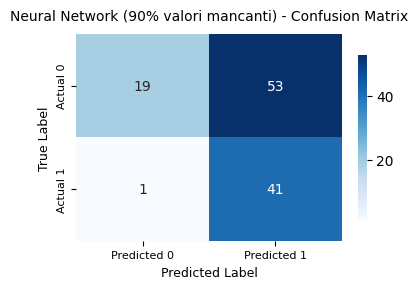


Addestramento SVM con 90% valori mancanti...

SVM (90% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92        72
           1       0.97      0.71      0.82        42

    accuracy                           0.89       114
   macro avg       0.91      0.85      0.87       114
weighted avg       0.90      0.89      0.88       114


SVM (90% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8860
Precision: 0.9677
Recall:    0.7143
F1 Score:  0.8219


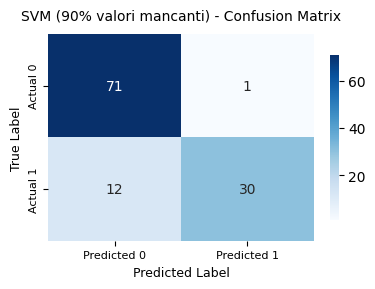


Addestramento Decision Tree con 90% valori mancanti...

Decision Tree (90% valori mancanti) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.88        72
           1       0.76      0.88      0.81        42

    accuracy                           0.85       114
   macro avg       0.84      0.86      0.84       114
weighted avg       0.86      0.85      0.85       114


Decision Tree (90% valori mancanti) - Performance Metrics Summary:
Accuracy:  0.8509
Precision: 0.7551
Recall:    0.8810
F1 Score:  0.8132


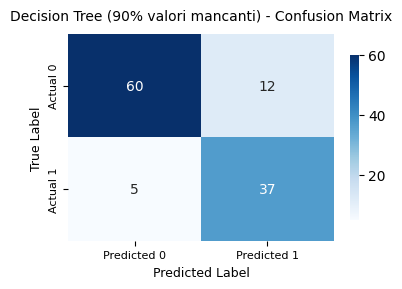


Visualizzazione performance con 90% valori mancanti:


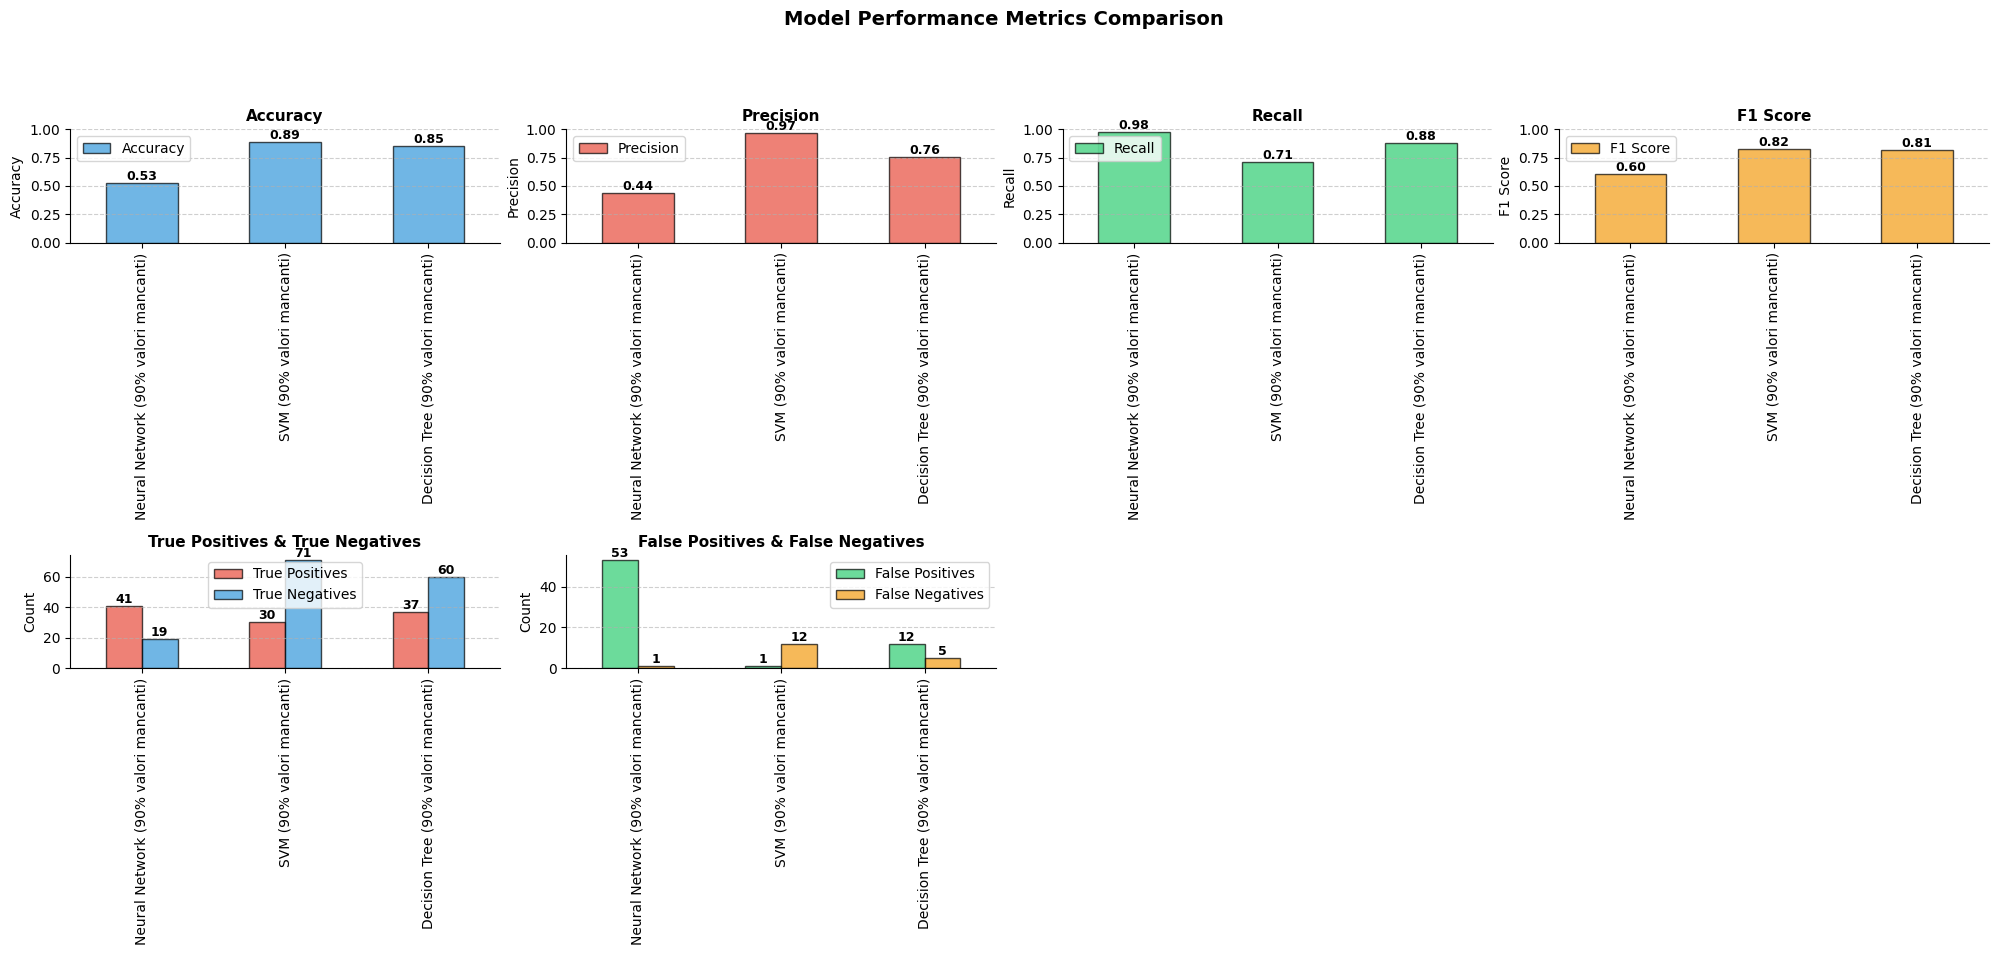

In [197]:
# ====================================================================
# ANALISI VALORI NULLI
# ====================================================================

print("="*60)
print("ANALISI DELL'IMPATTO DEI VALORI MANCANTI SULLE PERFORMANCE")
print("="*60)

missing_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
missing_results = []

for missing_pct in missing_percentages:
    print(f"\n{'='*50}")
    print(f"ANALISI CON {missing_pct:.0%} VALORI MANCANTI")
    print(f"{'='*50}")

    # Introduce valori mancanti
    X_train_missing = introduce_missing_data(X_train, missing_pct)
    missing_count = X_train_missing.isnull().sum().sum()
    total_values = X_train_missing.shape[0] * X_train_missing.shape[1]
    actual_missing_pct = missing_count / total_values

    print(f"Valori mancanti introdotti: {missing_count}/{total_values} ({actual_missing_pct:.1%})")

    # Gestisci valori mancanti
    X_train_clean, X_test_clean = handle_missing_values(X_train_missing, X_test, imputer_type='simple')

    # Addestra e valuta
    results = train_and_evaluate_models(X_train_clean, X_test_clean, y_train, y_test, 'valori mancanti', missing_pct)
    missing_results.append(results)

    # Visualizza le performance per questa percentuale
    print(f"\nVisualizzazione performance con {missing_pct:.0%} valori mancanti:")
    plot_model_performance_metrics(results)


VISUALIZZAZIONE EVOLUZIONE PERFORMANCE - VALORI MANCANTI


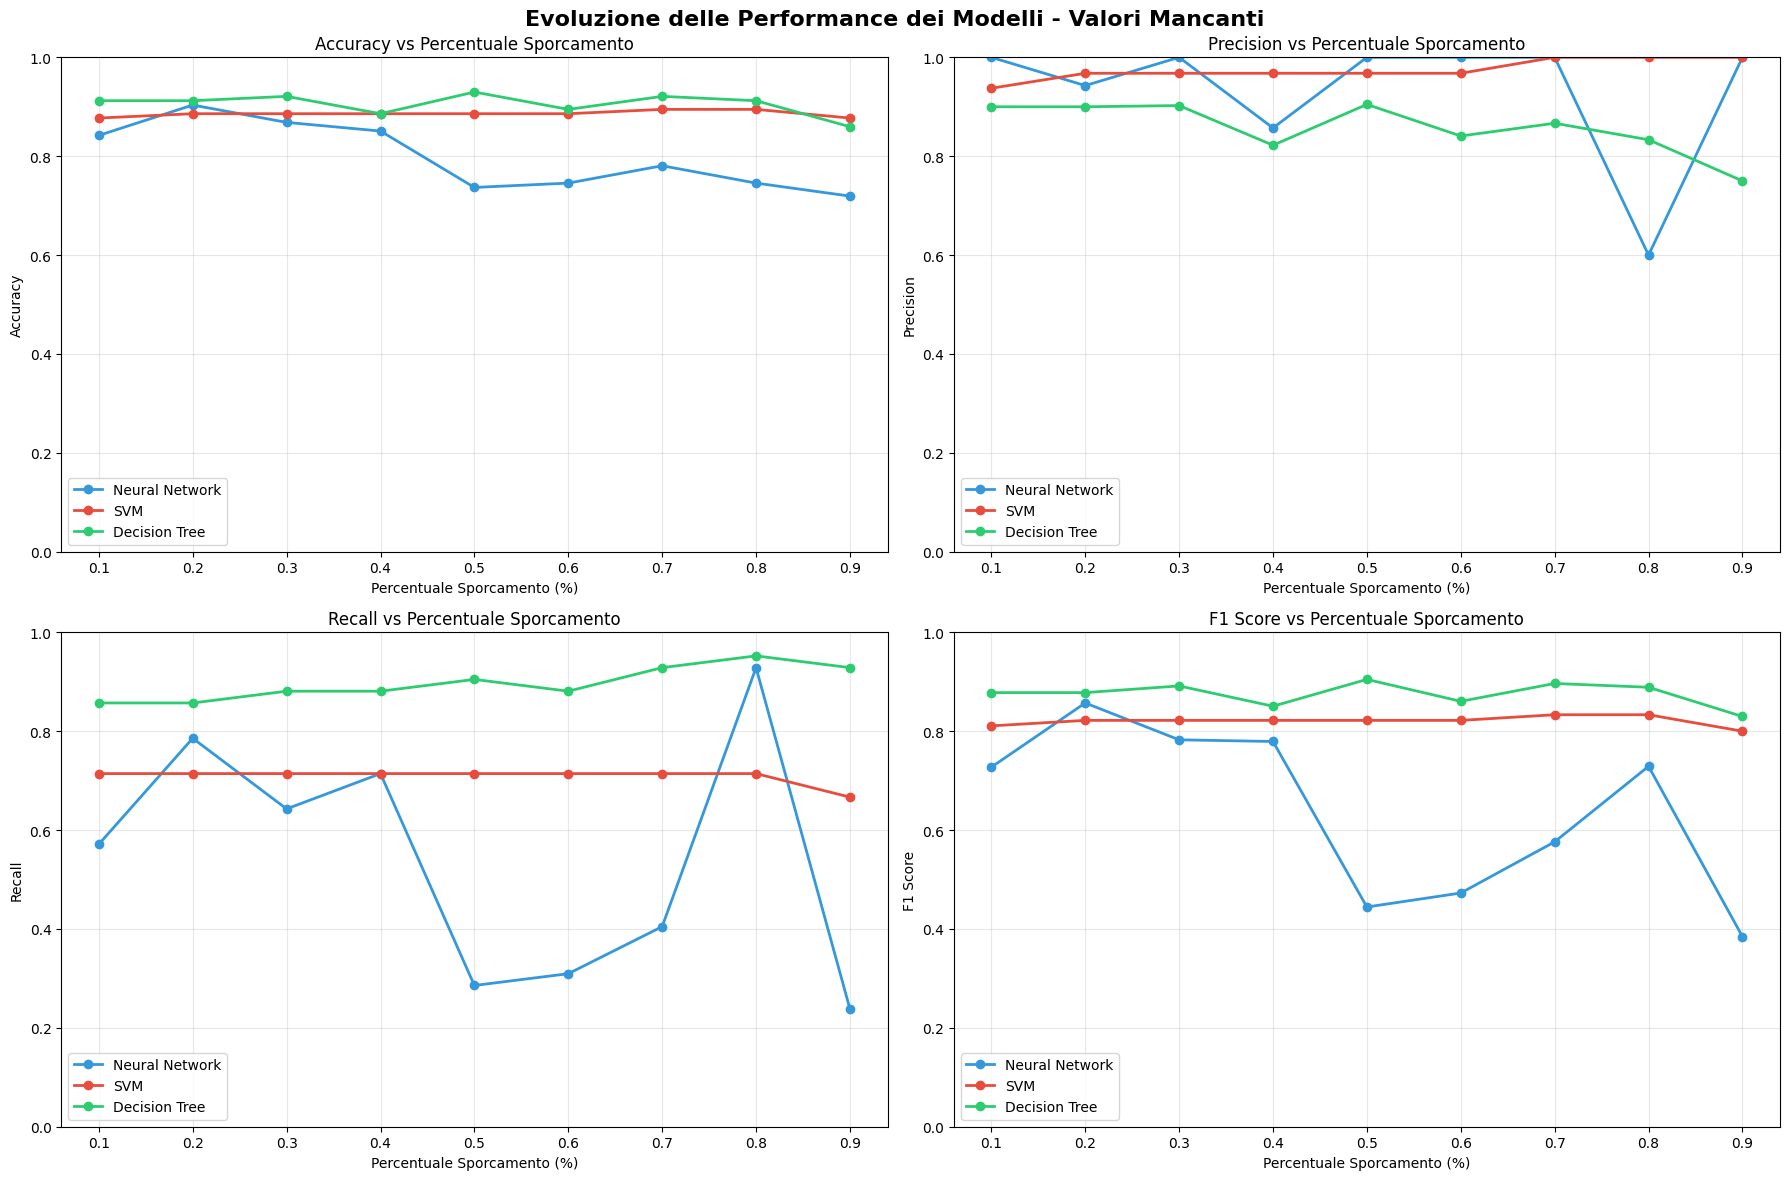

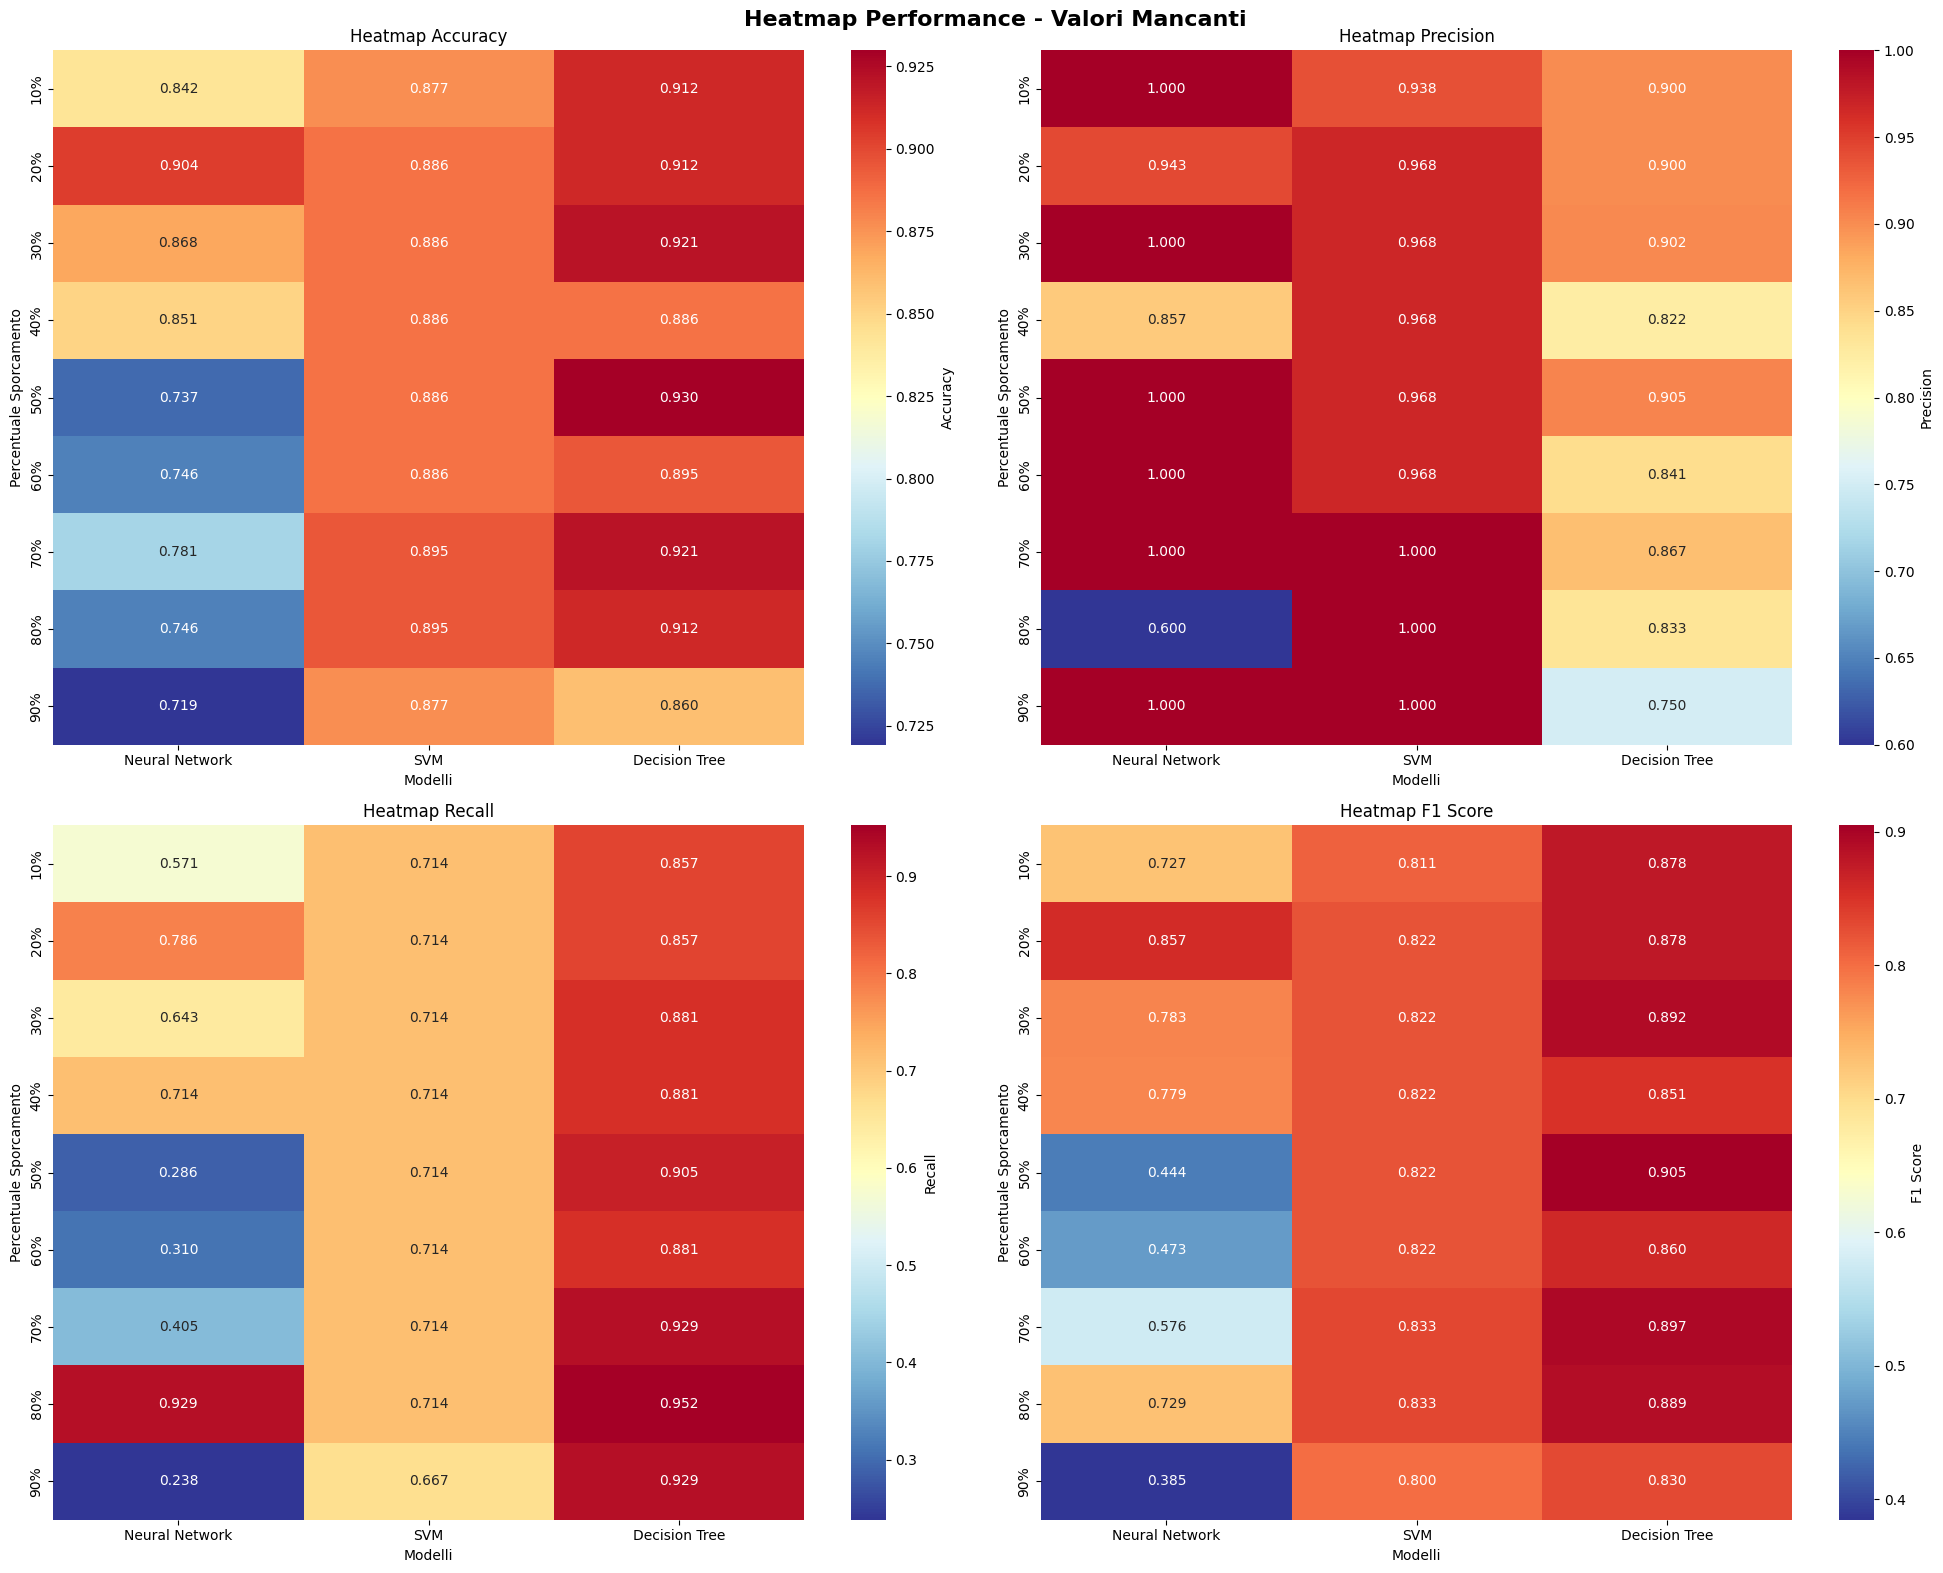


ANALISI STATISTICA FINALE - VALORI MANCANTI

NEURAL NETWORK:
----------------------------------------
Accuracy    : 0.842 → 0.719 (degrado: 0.123, 14.6%)
Precision   : 1.000 → 1.000 (degrado: 0.000, 0.0%)
Recall      : 0.571 → 0.238 (degrado: 0.333, 58.3%)
F1 Score    : 0.727 → 0.385 (degrado: 0.343, 47.1%)

SVM:
----------------------------------------
Accuracy    : 0.877 → 0.877 (degrado: 0.000, 0.0%)
Precision   : 0.938 → 1.000 (degrado: -0.062, -6.7%)
Recall      : 0.714 → 0.667 (degrado: 0.048, 6.7%)
F1 Score    : 0.811 → 0.800 (degrado: 0.011, 1.3%)

DECISION TREE:
----------------------------------------
Accuracy    : 0.912 → 0.860 (degrado: 0.053, 5.8%)
Precision   : 0.900 → 0.750 (degrado: 0.150, 16.7%)
Recall      : 0.857 → 0.929 (degrado: -0.071, -8.3%)
F1 Score    : 0.878 → 0.830 (degrado: 0.048, 5.5%)


In [195]:
# Visualizzazione finale
print("\n" + "="*60)
print("VISUALIZZAZIONE EVOLUZIONE PERFORMANCE - VALORI MANCANTI")
print("="*60)

plot_performance_evolution(missing_results, missing_percentages, "- Valori Mancanti")
create_corruption_heatmap(missing_results, missing_percentages, "- Valori Mancanti")
print_statistical_analysis(missing_results, "valori mancanti")

# Valori duplicati

In [198]:
# ====================================================================
# FUNZIONI SPORCAMENTO VALORI DUPLICATI
# ====================================================================

def introduce_duplicate_data(dataset, percentage):
    """
    Introduce valori duplicati in modo casuale nel dataset.
    """
    dataset_with_duplicates = dataset.copy()
    num_duplicates = int(len(dataset_with_duplicates) * percentage)

    rows_to_duplicate = np.random.choice(
        range(len(dataset_with_duplicates)),
        size=num_duplicates,
        replace=True
    )

    duplicated_rows = dataset_with_duplicates.iloc[rows_to_duplicate].copy()
    dataset_with_duplicates = pd.concat([dataset_with_duplicates, duplicated_rows], ignore_index=True)

    return dataset_with_duplicates, rows_to_duplicate

ANALISI DELL'IMPATTO DEI VALORI DUPLICATI SULLE PERFORMANCE

ANALISI CON 10% VALORI DUPLICATI
Righe duplicate aggiunte: 57 (da 570 a 627 righe)

Addestramento Neural Network con 10% valori duplicati...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Neural Network (10% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        72
           1       0.94      0.81      0.87        42

    accuracy                           0.91       114
   macro avg       0.92      0.89      0.90       114
weighted avg       0.91      0.91      0.91       114


Neural Network (10% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.9444
Recall:    0.8095
F1 Score:  0.8718


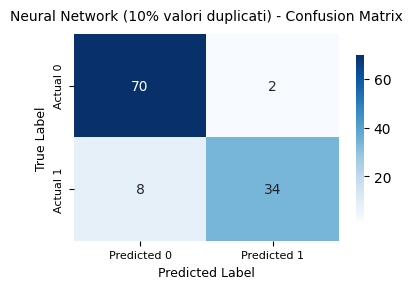


Addestramento SVM con 10% valori duplicati...

SVM (10% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93        72
           1       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114


SVM (10% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.9706
Recall:    0.7857
F1 Score:  0.8684


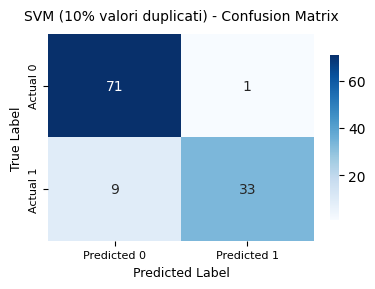


Addestramento Decision Tree con 10% valori duplicati...

Decision Tree (10% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        72
           1       0.95      0.88      0.91        42

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114


Decision Tree (10% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9386
Precision: 0.9487
Recall:    0.8810
F1 Score:  0.9136


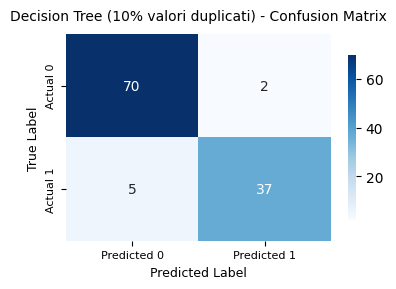


Visualizzazione performance con 10% valori duplicati:


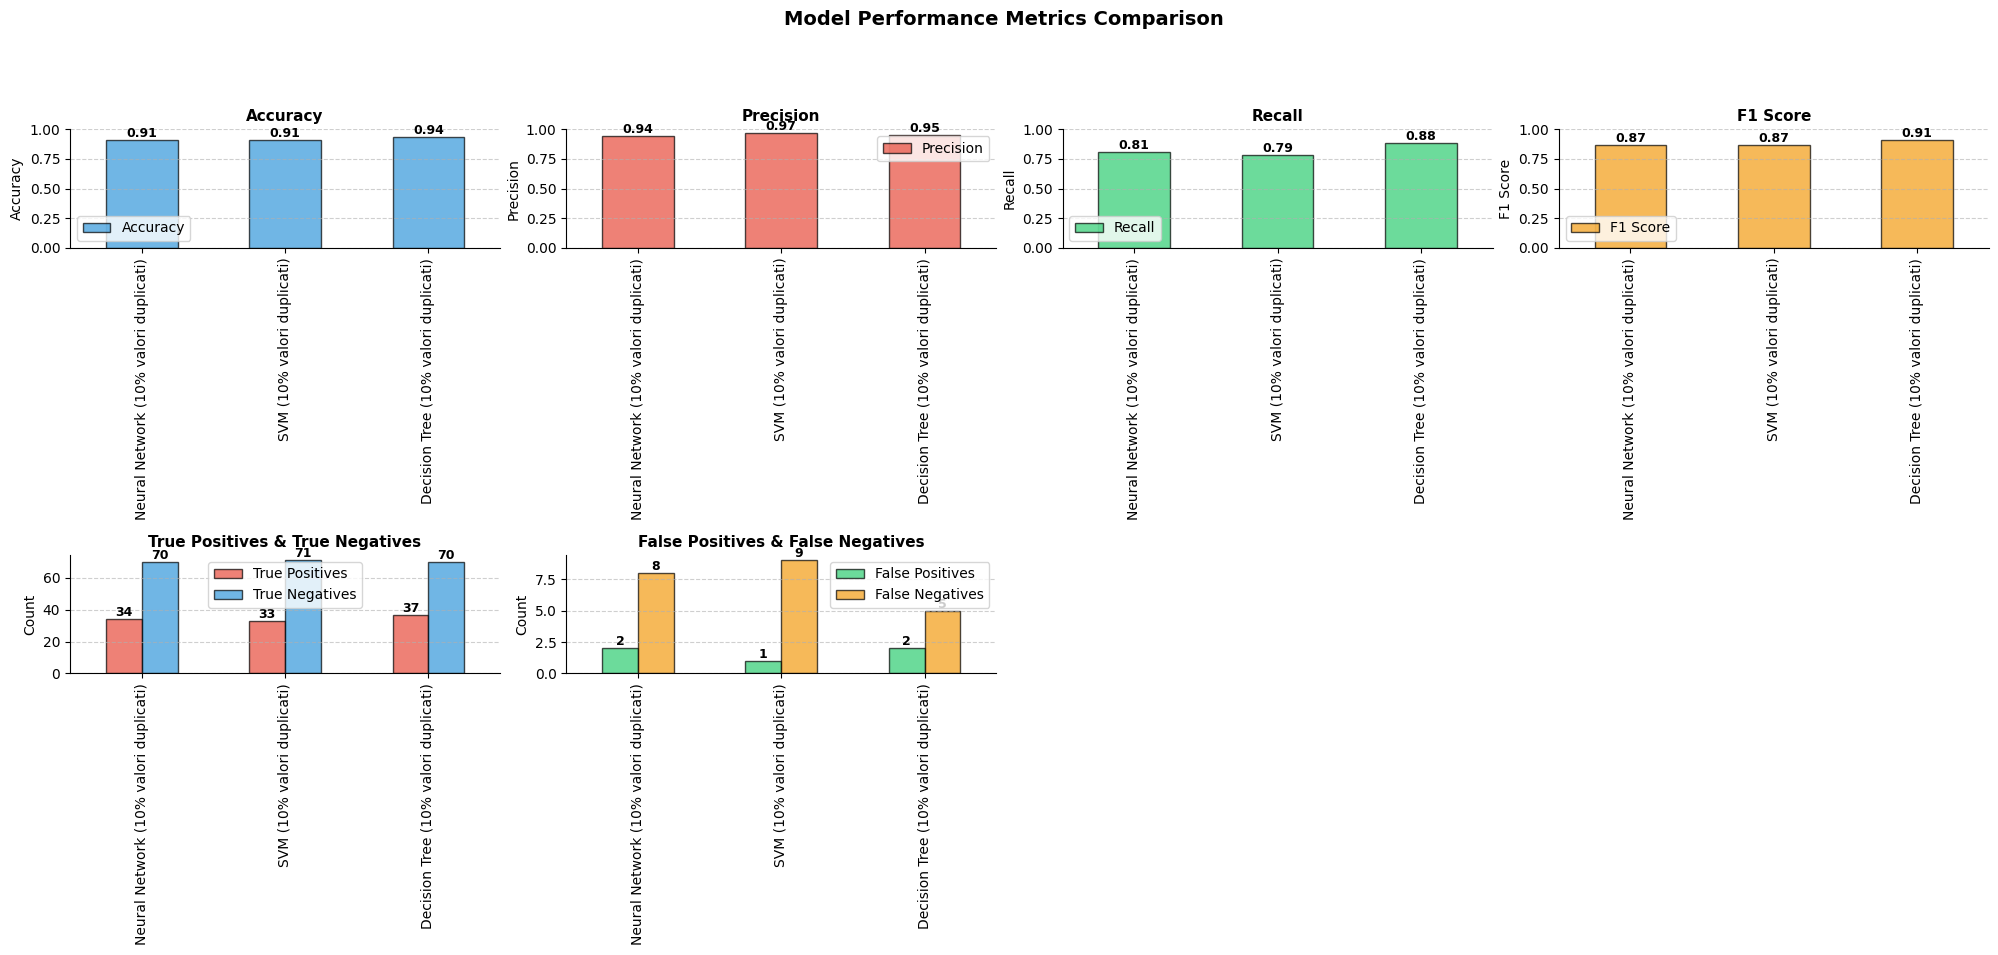


ANALISI CON 20% VALORI DUPLICATI
Righe duplicate aggiunte: 114 (da 570 a 684 righe)

Addestramento Neural Network con 20% valori duplicati...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Neural Network (20% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114


Neural Network (20% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9474
Precision: 0.9500
Recall:    0.9048
F1 Score:  0.9268


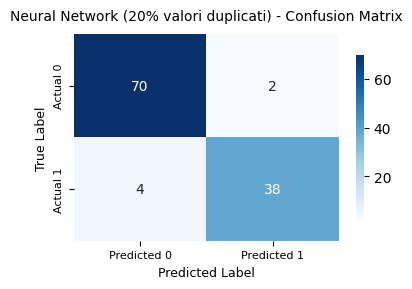


Addestramento SVM con 20% valori duplicati...

SVM (20% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        72
           1       0.94      0.79      0.86        42

    accuracy                           0.90       114
   macro avg       0.91      0.88      0.89       114
weighted avg       0.91      0.90      0.90       114


SVM (20% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9035
Precision: 0.9429
Recall:    0.7857
F1 Score:  0.8571


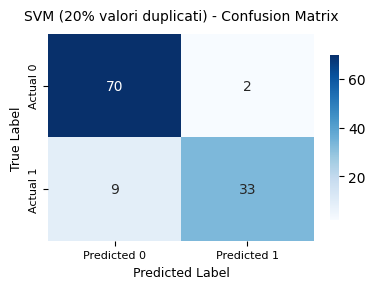


Addestramento Decision Tree con 20% valori duplicati...

Decision Tree (20% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        72
           1       0.88      0.88      0.88        42

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114


Decision Tree (20% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.8810
Recall:    0.8810
F1 Score:  0.8810


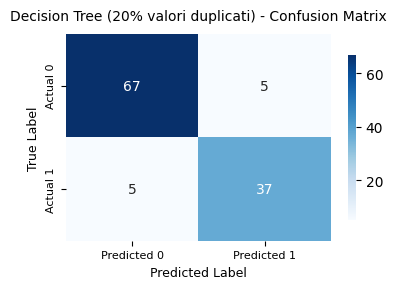


Visualizzazione performance con 20% valori duplicati:


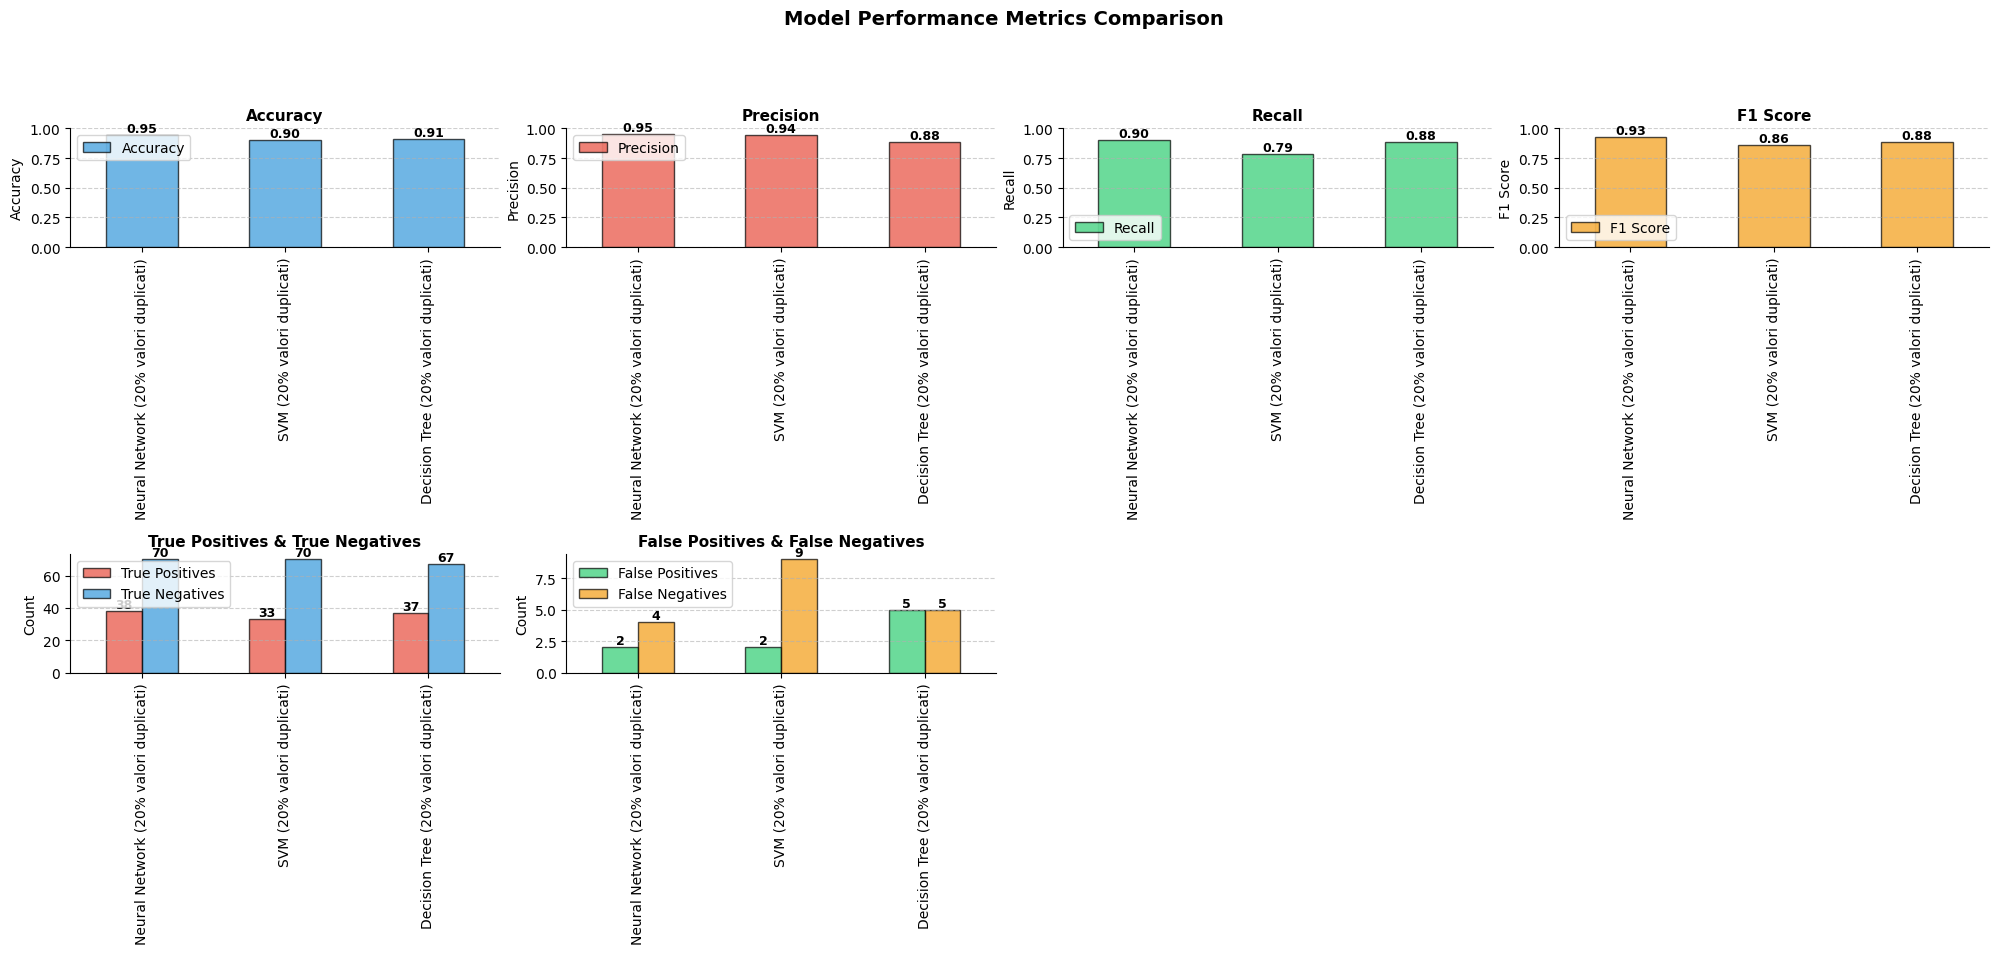


ANALISI CON 30% VALORI DUPLICATI
Righe duplicate aggiunte: 171 (da 570 a 741 righe)

Addestramento Neural Network con 30% valori duplicati...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Neural Network (30% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        72
           1       1.00      0.76      0.86        42

    accuracy                           0.91       114
   macro avg       0.94      0.88      0.90       114
weighted avg       0.92      0.91      0.91       114


Neural Network (30% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 1.0000
Recall:    0.7619
F1 Score:  0.8649


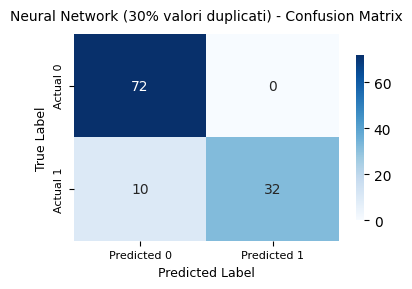


Addestramento SVM con 30% valori duplicati...

SVM (30% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        72
           1       0.94      0.79      0.86        42

    accuracy                           0.90       114
   macro avg       0.91      0.88      0.89       114
weighted avg       0.91      0.90      0.90       114


SVM (30% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9035
Precision: 0.9429
Recall:    0.7857
F1 Score:  0.8571


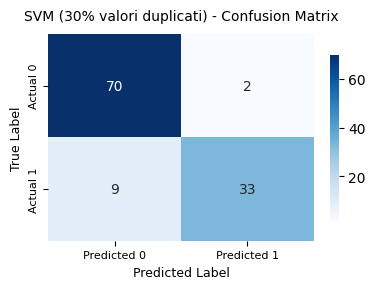


Addestramento Decision Tree con 30% valori duplicati...

Decision Tree (30% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        72
           1       0.92      0.83      0.88        42

    accuracy                           0.91       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114


Decision Tree (30% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.9211
Recall:    0.8333
F1 Score:  0.8750


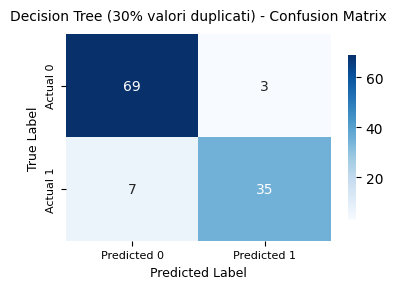


Visualizzazione performance con 30% valori duplicati:


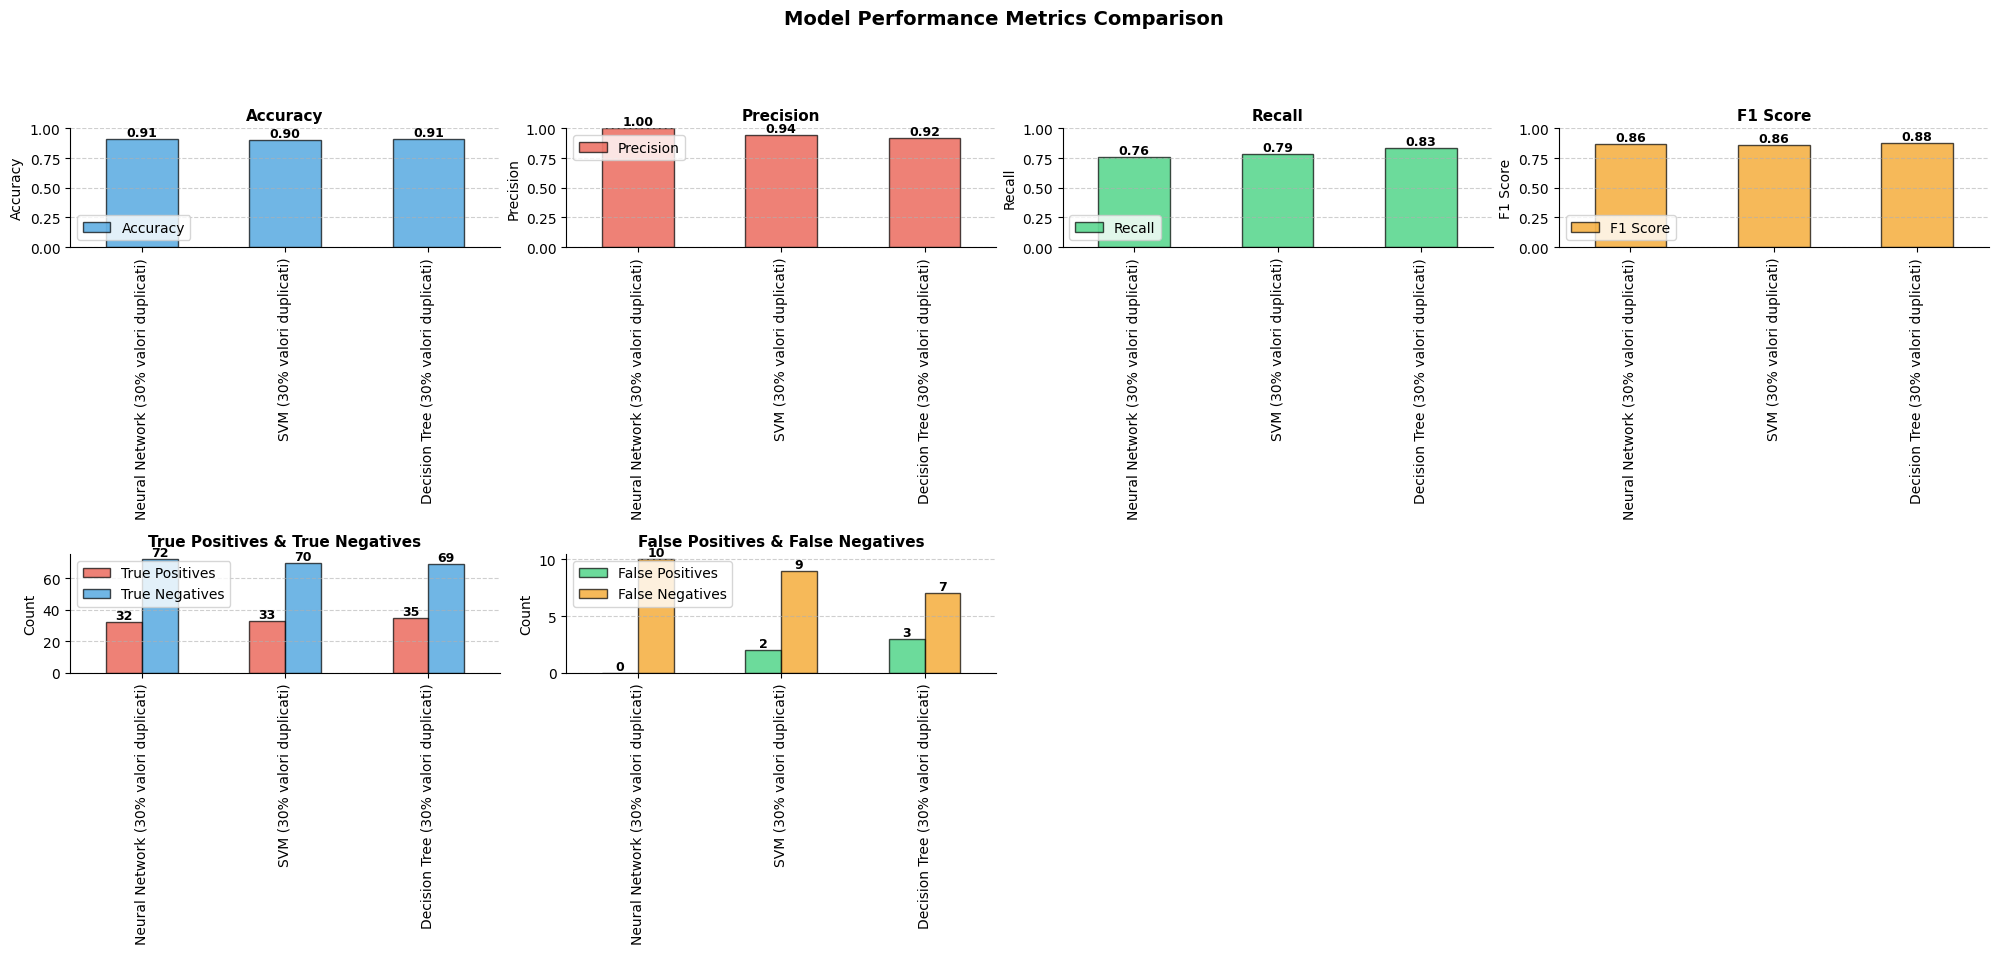


ANALISI CON 40% VALORI DUPLICATI
Righe duplicate aggiunte: 228 (da 570 a 798 righe)

Addestramento Neural Network con 40% valori duplicati...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Neural Network (40% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        72
           1       0.86      0.90      0.88        42

    accuracy                           0.91       114
   macro avg       0.90      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114


Neural Network (40% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.8636
Recall:    0.9048
F1 Score:  0.8837


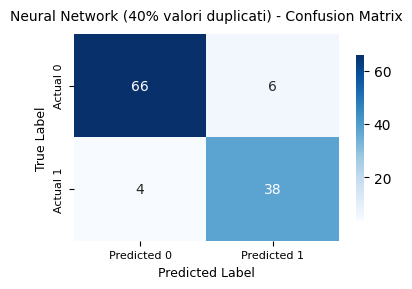


Addestramento SVM con 40% valori duplicati...

SVM (40% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93        72
           1       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114


SVM (40% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.9706
Recall:    0.7857
F1 Score:  0.8684


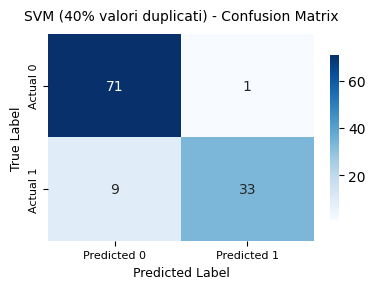


Addestramento Decision Tree con 40% valori duplicati...

Decision Tree (40% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        72
           1       0.89      0.79      0.84        42

    accuracy                           0.89       114
   macro avg       0.89      0.87      0.87       114
weighted avg       0.89      0.89      0.88       114


Decision Tree (40% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.8860
Precision: 0.8919
Recall:    0.7857
F1 Score:  0.8354


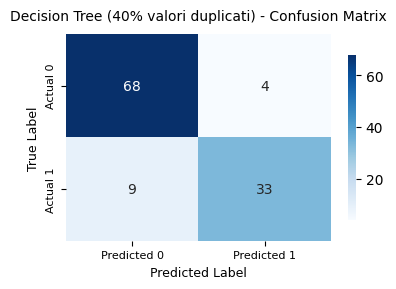


Visualizzazione performance con 40% valori duplicati:


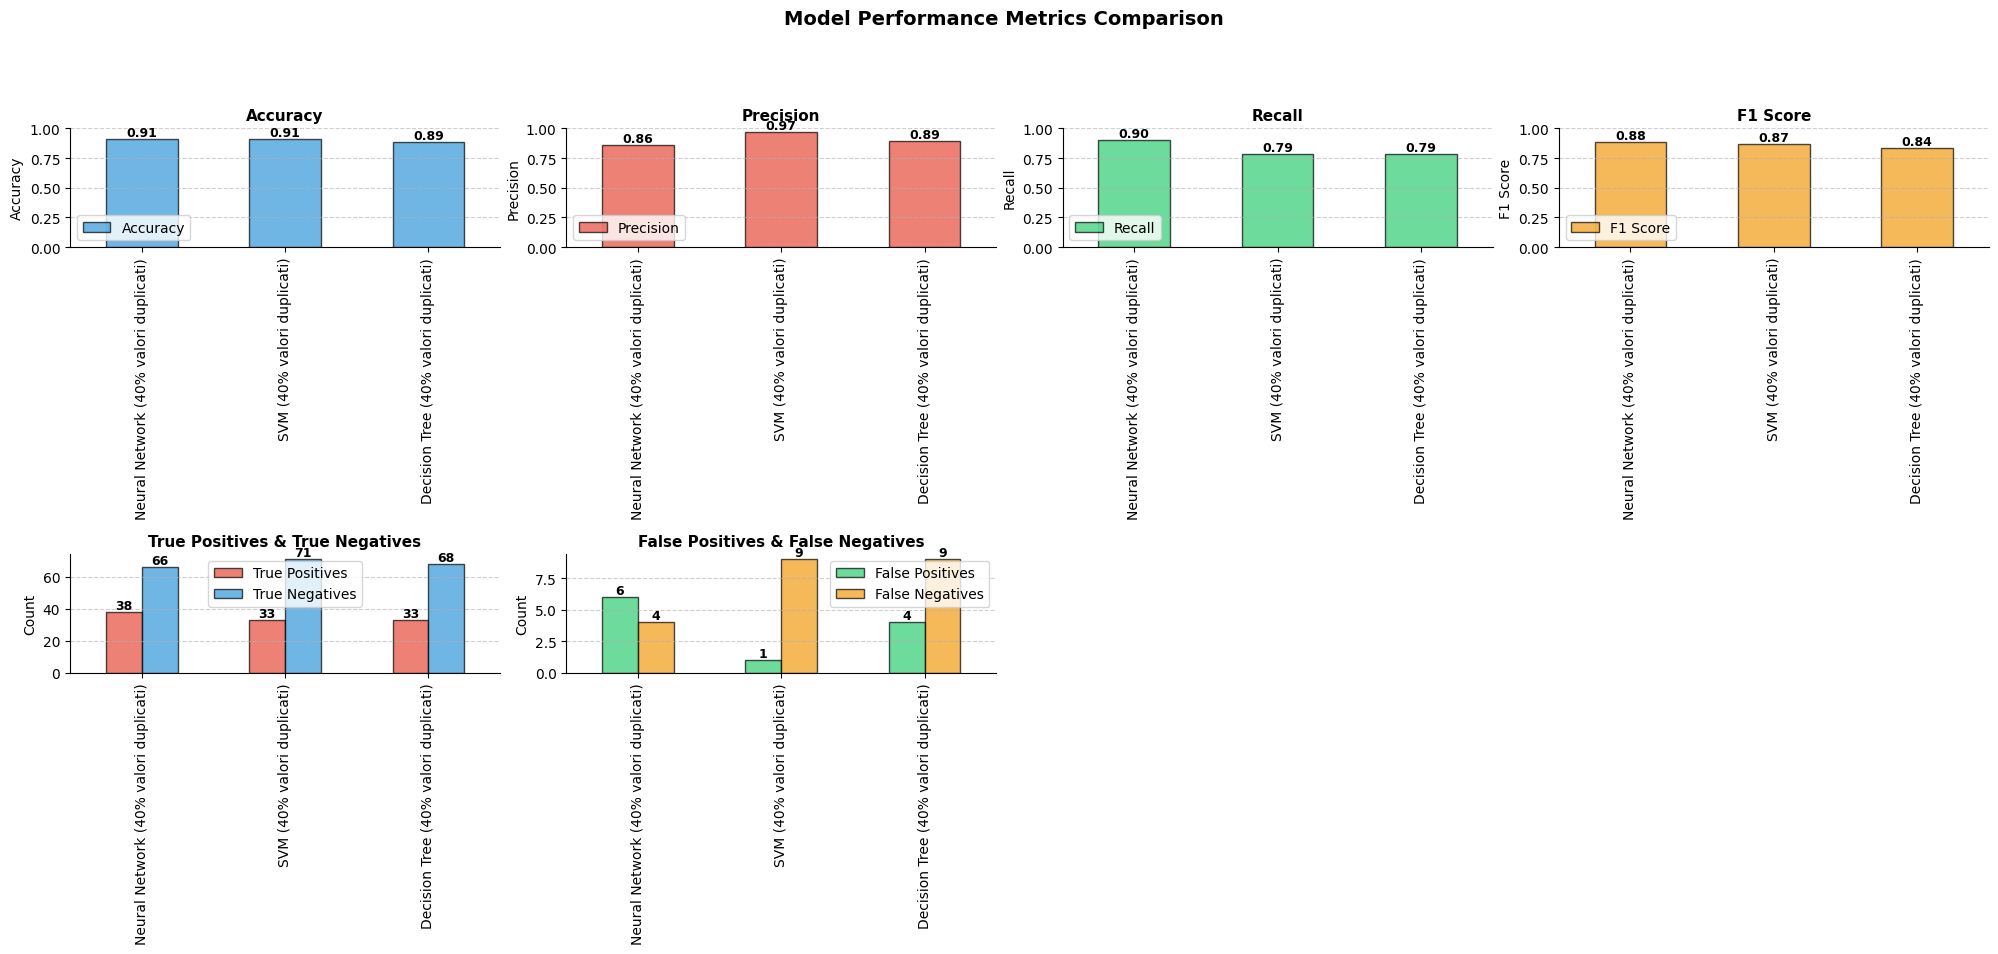


ANALISI CON 50% VALORI DUPLICATI
Righe duplicate aggiunte: 285 (da 570 a 855 righe)

Addestramento Neural Network con 50% valori duplicati...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Neural Network (50% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        72
           1       0.86      0.90      0.88        42

    accuracy                           0.91       114
   macro avg       0.90      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114


Neural Network (50% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.8636
Recall:    0.9048
F1 Score:  0.8837


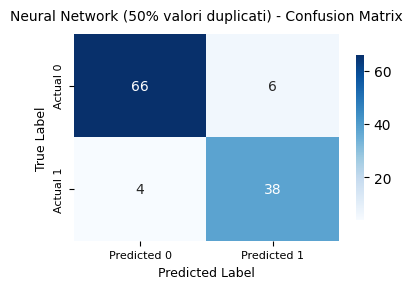


Addestramento SVM con 50% valori duplicati...

SVM (50% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93        72
           1       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114


SVM (50% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.9706
Recall:    0.7857
F1 Score:  0.8684


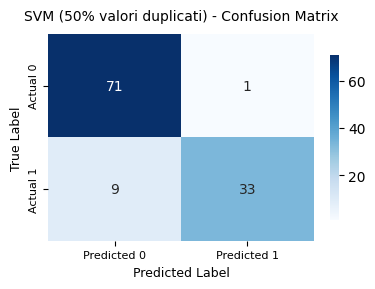


Addestramento Decision Tree con 50% valori duplicati...

Decision Tree (50% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        72
           1       0.90      0.86      0.88        42

    accuracy                           0.91       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114


Decision Tree (50% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.9000
Recall:    0.8571
F1 Score:  0.8780


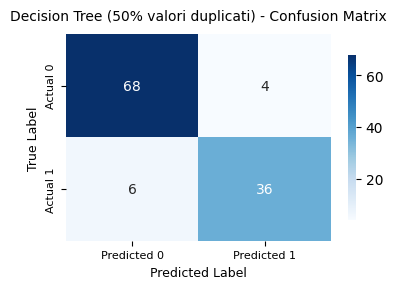


Visualizzazione performance con 50% valori duplicati:


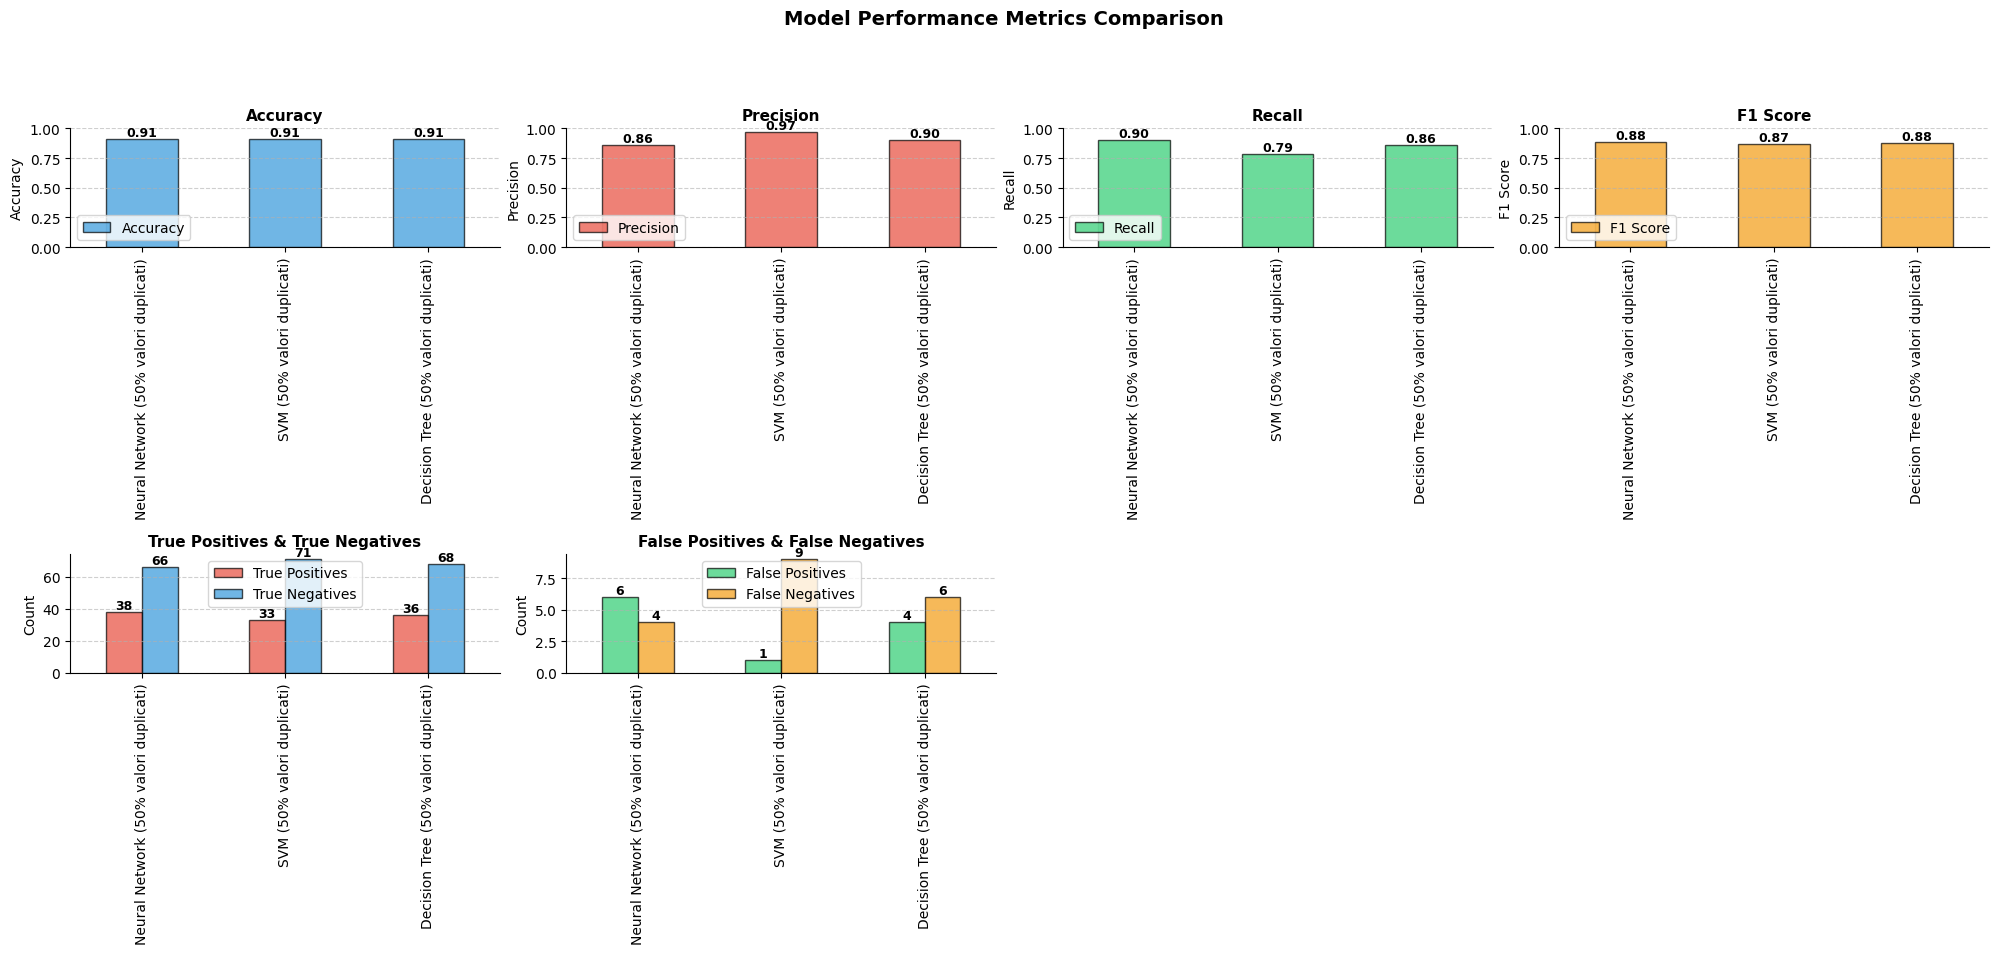


ANALISI CON 60% VALORI DUPLICATI
Righe duplicate aggiunte: 342 (da 570 a 912 righe)

Addestramento Neural Network con 60% valori duplicati...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Neural Network (60% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        72
           1       1.00      0.79      0.88        42

    accuracy                           0.92       114
   macro avg       0.94      0.89      0.91       114
weighted avg       0.93      0.92      0.92       114


Neural Network (60% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9211
Precision: 1.0000
Recall:    0.7857
F1 Score:  0.8800


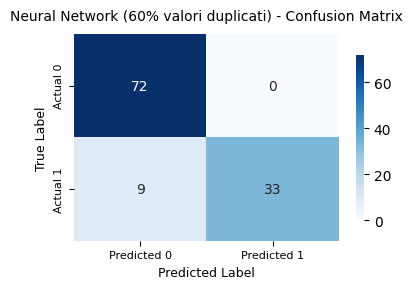


Addestramento SVM con 60% valori duplicati...

SVM (60% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93        72
           1       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114


SVM (60% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.9706
Recall:    0.7857
F1 Score:  0.8684


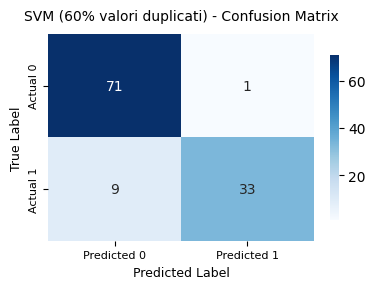


Addestramento Decision Tree con 60% valori duplicati...

Decision Tree (60% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        72
           1       0.90      0.90      0.90        42

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114


Decision Tree (60% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9298
Precision: 0.9048
Recall:    0.9048
F1 Score:  0.9048


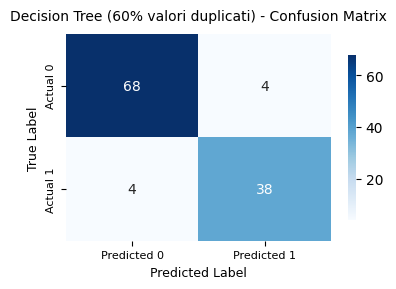


Visualizzazione performance con 60% valori duplicati:


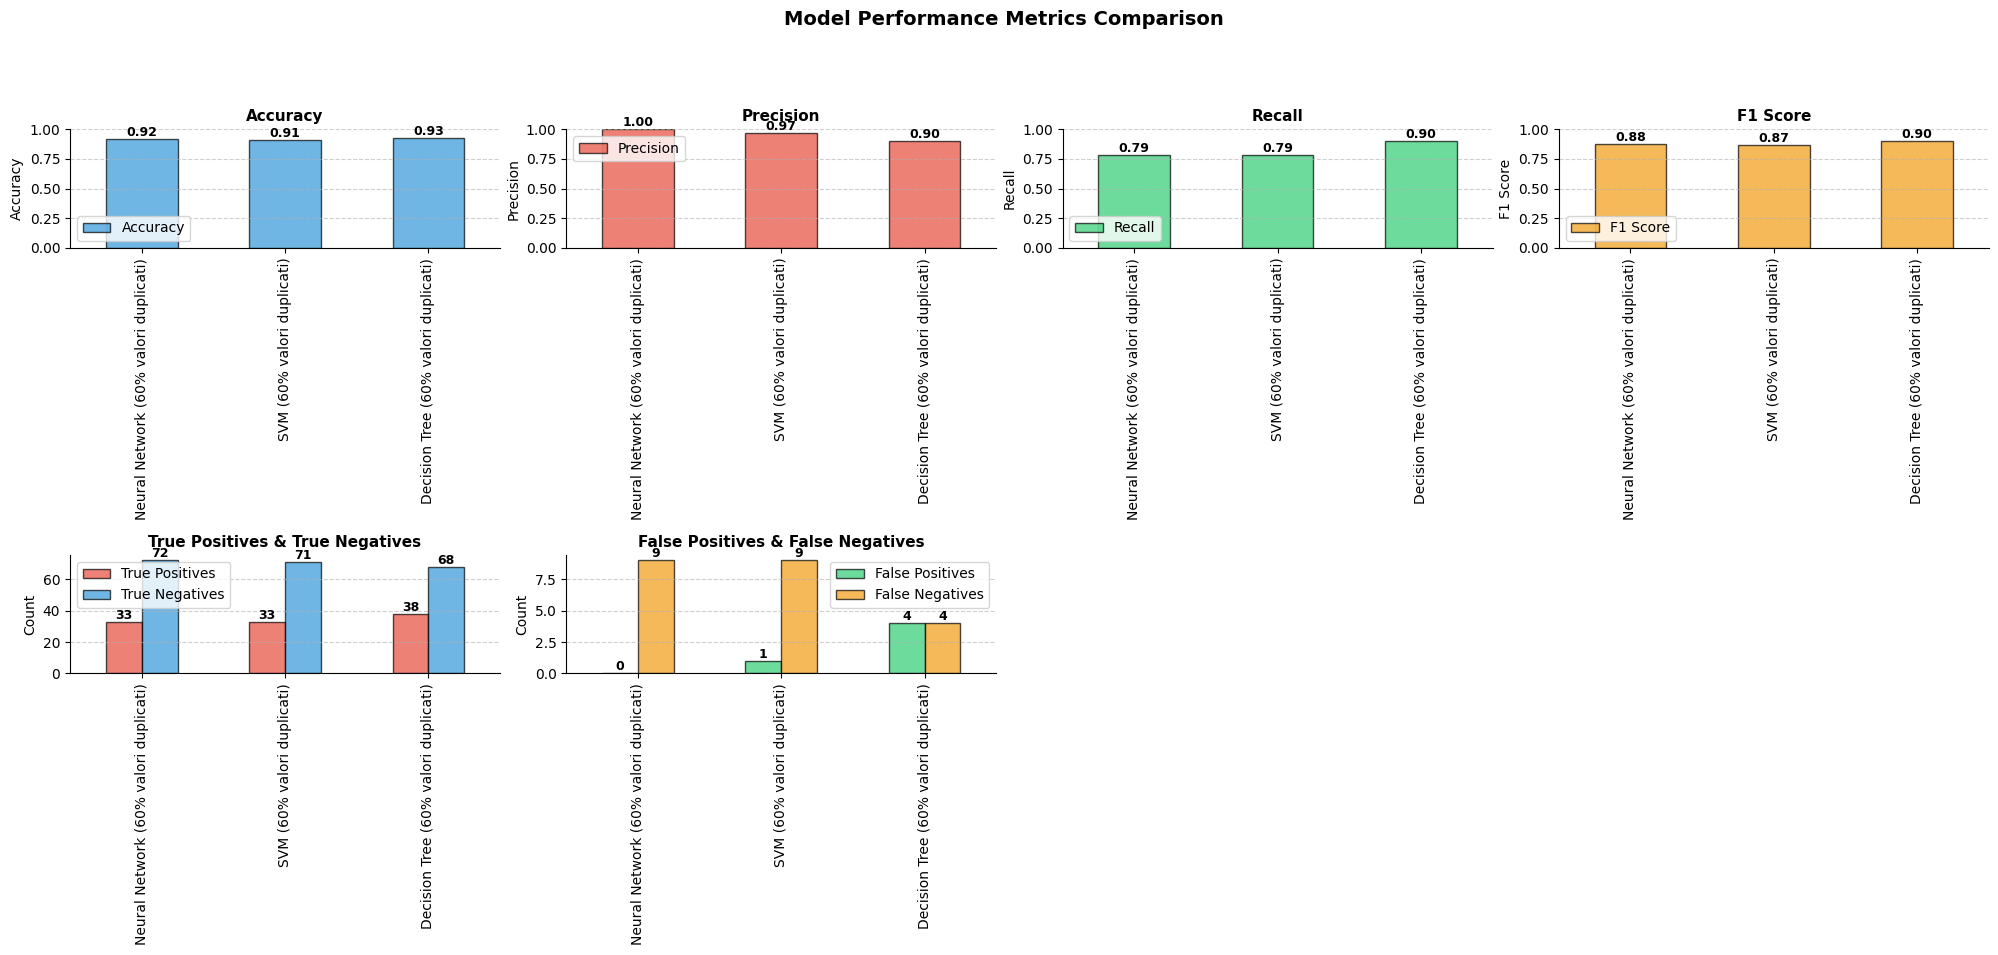


ANALISI CON 70% VALORI DUPLICATI
Righe duplicate aggiunte: 399 (da 570 a 969 righe)

Addestramento Neural Network con 70% valori duplicati...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Neural Network (70% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        72
           1       1.00      0.69      0.82        42

    accuracy                           0.89       114
   macro avg       0.92      0.85      0.87       114
weighted avg       0.90      0.89      0.88       114


Neural Network (70% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.8860
Precision: 1.0000
Recall:    0.6905
F1 Score:  0.8169


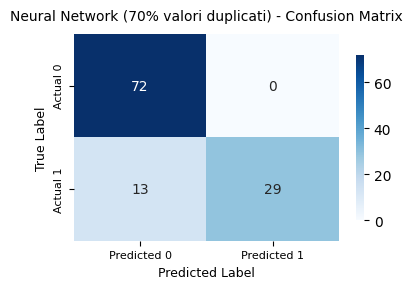


Addestramento SVM con 70% valori duplicati...

SVM (70% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93        72
           1       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114


SVM (70% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.9706
Recall:    0.7857
F1 Score:  0.8684


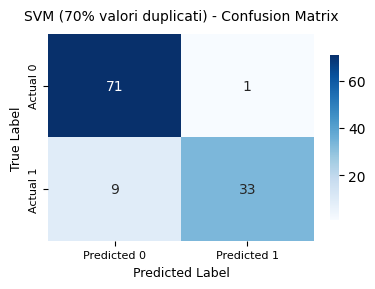


Addestramento Decision Tree con 70% valori duplicati...

Decision Tree (70% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


Decision Tree (70% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9561
Precision: 0.9512
Recall:    0.9286
F1 Score:  0.9398


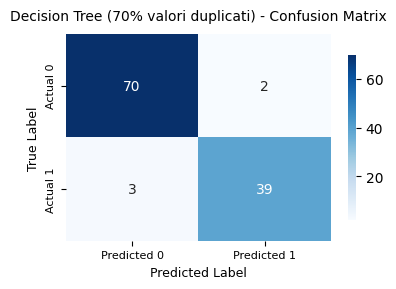


Visualizzazione performance con 70% valori duplicati:


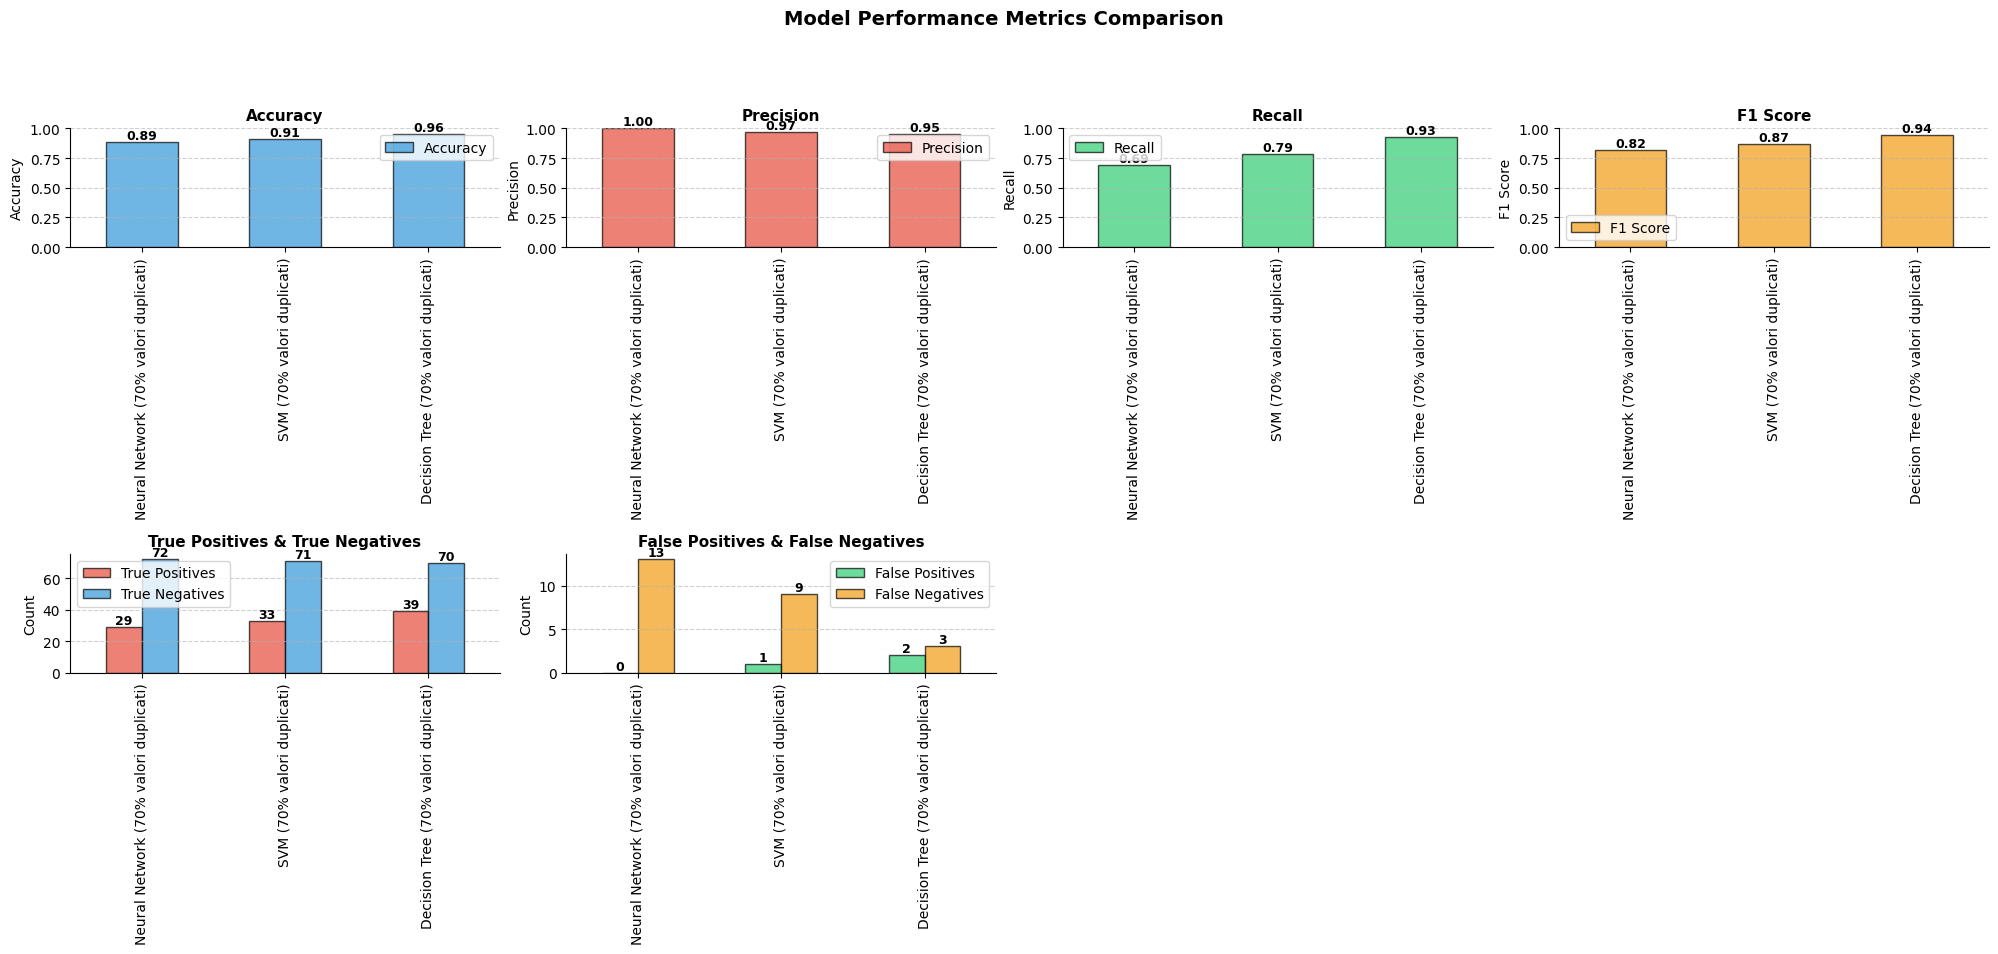


ANALISI CON 80% VALORI DUPLICATI
Righe duplicate aggiunte: 456 (da 570 a 1026 righe)

Addestramento Neural Network con 80% valori duplicati...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Neural Network (80% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        72
           1       1.00      0.74      0.85        42

    accuracy                           0.90       114
   macro avg       0.93      0.87      0.89       114
weighted avg       0.92      0.90      0.90       114


Neural Network (80% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9035
Precision: 1.0000
Recall:    0.7381
F1 Score:  0.8493


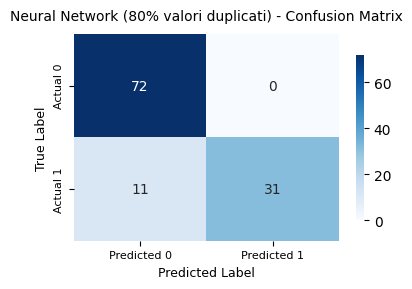


Addestramento SVM con 80% valori duplicati...

SVM (80% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93        72
           1       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114


SVM (80% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.9706
Recall:    0.7857
F1 Score:  0.8684


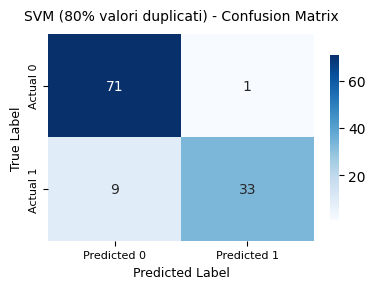


Addestramento Decision Tree con 80% valori duplicati...

Decision Tree (80% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94        72
           1       0.88      0.90      0.89        42

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114


Decision Tree (80% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9211
Precision: 0.8837
Recall:    0.9048
F1 Score:  0.8941


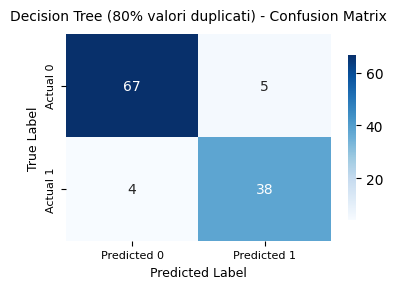


Visualizzazione performance con 80% valori duplicati:


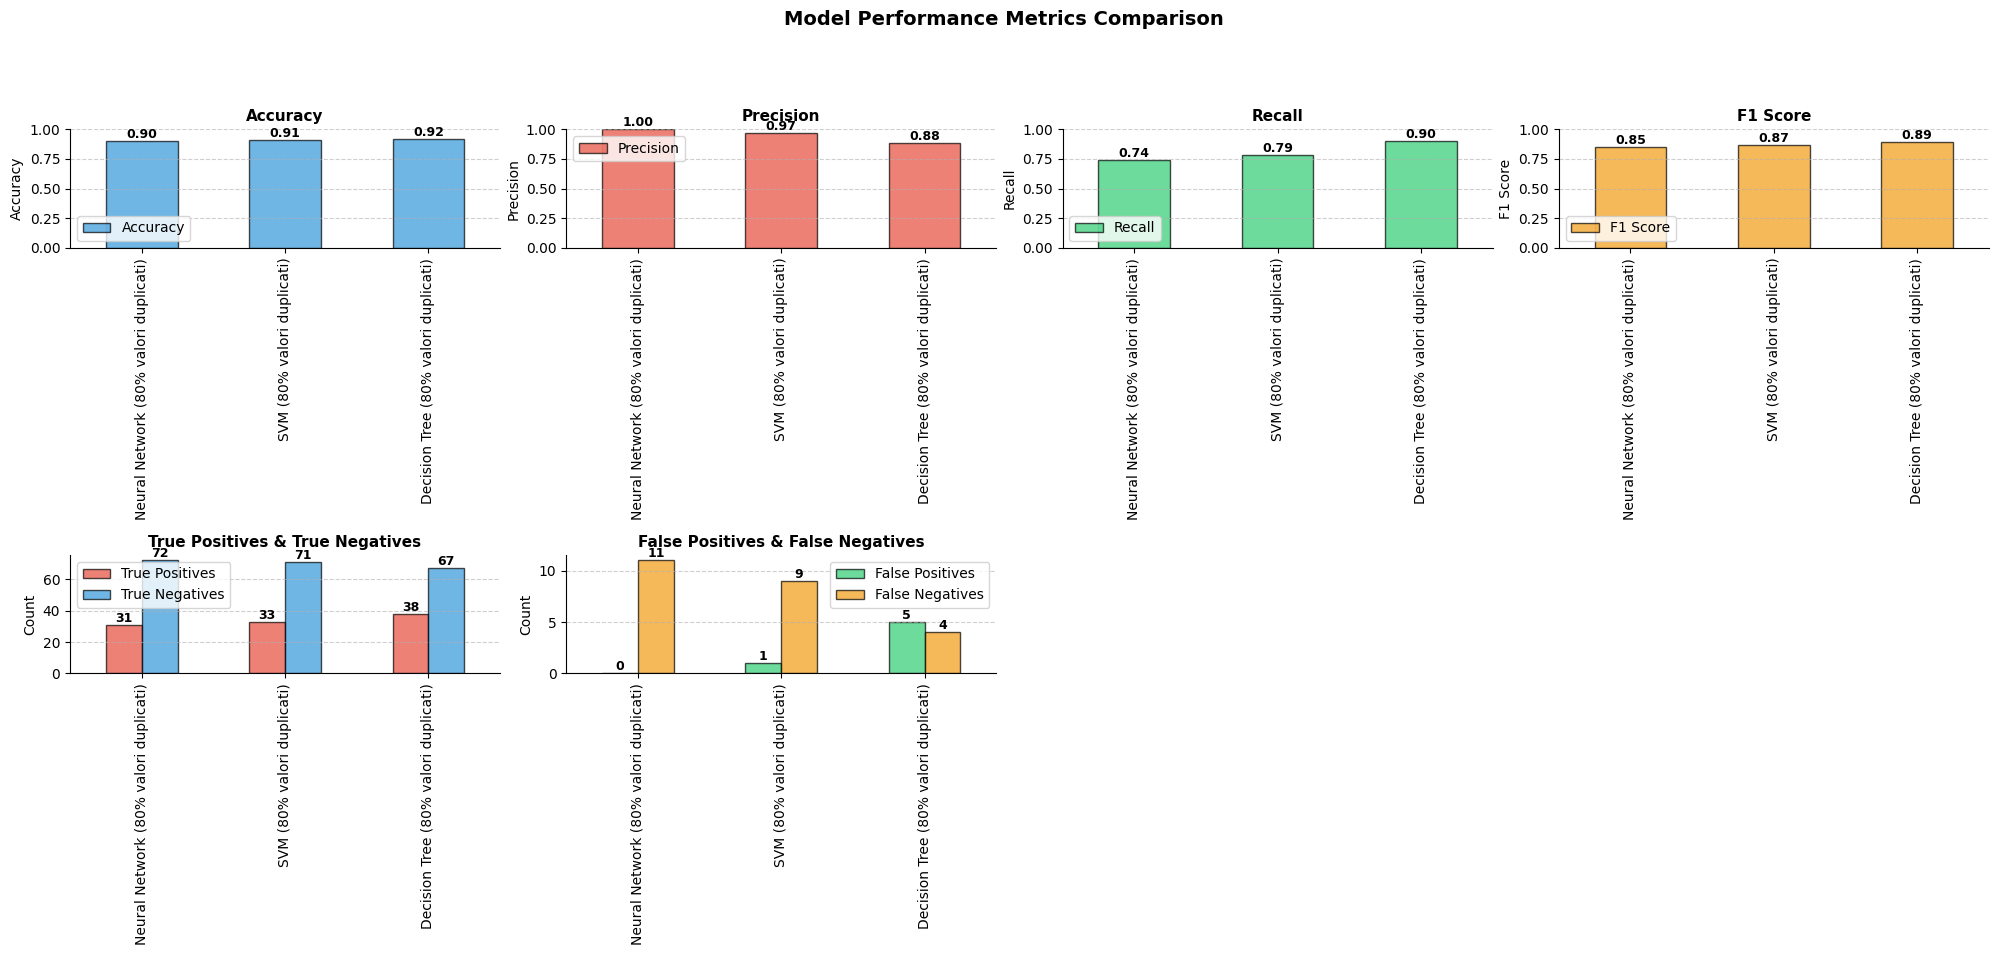


ANALISI CON 90% VALORI DUPLICATI
Righe duplicate aggiunte: 513 (da 570 a 1083 righe)

Addestramento Neural Network con 90% valori duplicati...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Neural Network (90% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        72
           1       1.00      0.67      0.80        42

    accuracy                           0.88       114
   macro avg       0.92      0.83      0.86       114
weighted avg       0.90      0.88      0.87       114


Neural Network (90% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.8772
Precision: 1.0000
Recall:    0.6667
F1 Score:  0.8000


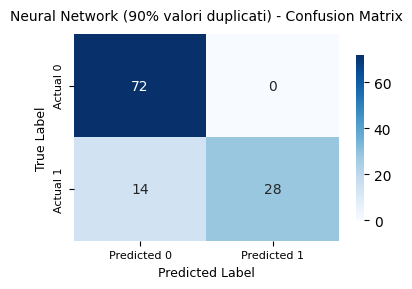


Addestramento SVM con 90% valori duplicati...

SVM (90% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93        72
           1       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114


SVM (90% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.9123
Precision: 0.9706
Recall:    0.7857
F1 Score:  0.8684


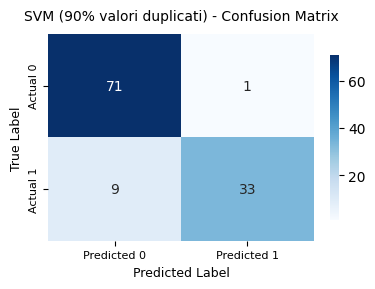


Addestramento Decision Tree con 90% valori duplicati...

Decision Tree (90% valori duplicati) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        72
           1       0.83      0.81      0.82        42

    accuracy                           0.87       114
   macro avg       0.86      0.86      0.86       114
weighted avg       0.87      0.87      0.87       114


Decision Tree (90% valori duplicati) - Performance Metrics Summary:
Accuracy:  0.8684
Precision: 0.8293
Recall:    0.8095
F1 Score:  0.8193


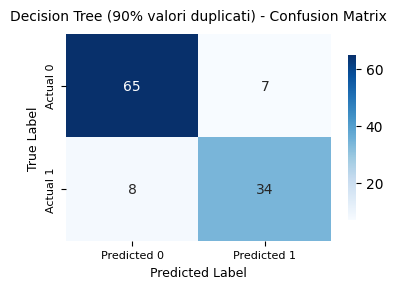


Visualizzazione performance con 90% valori duplicati:


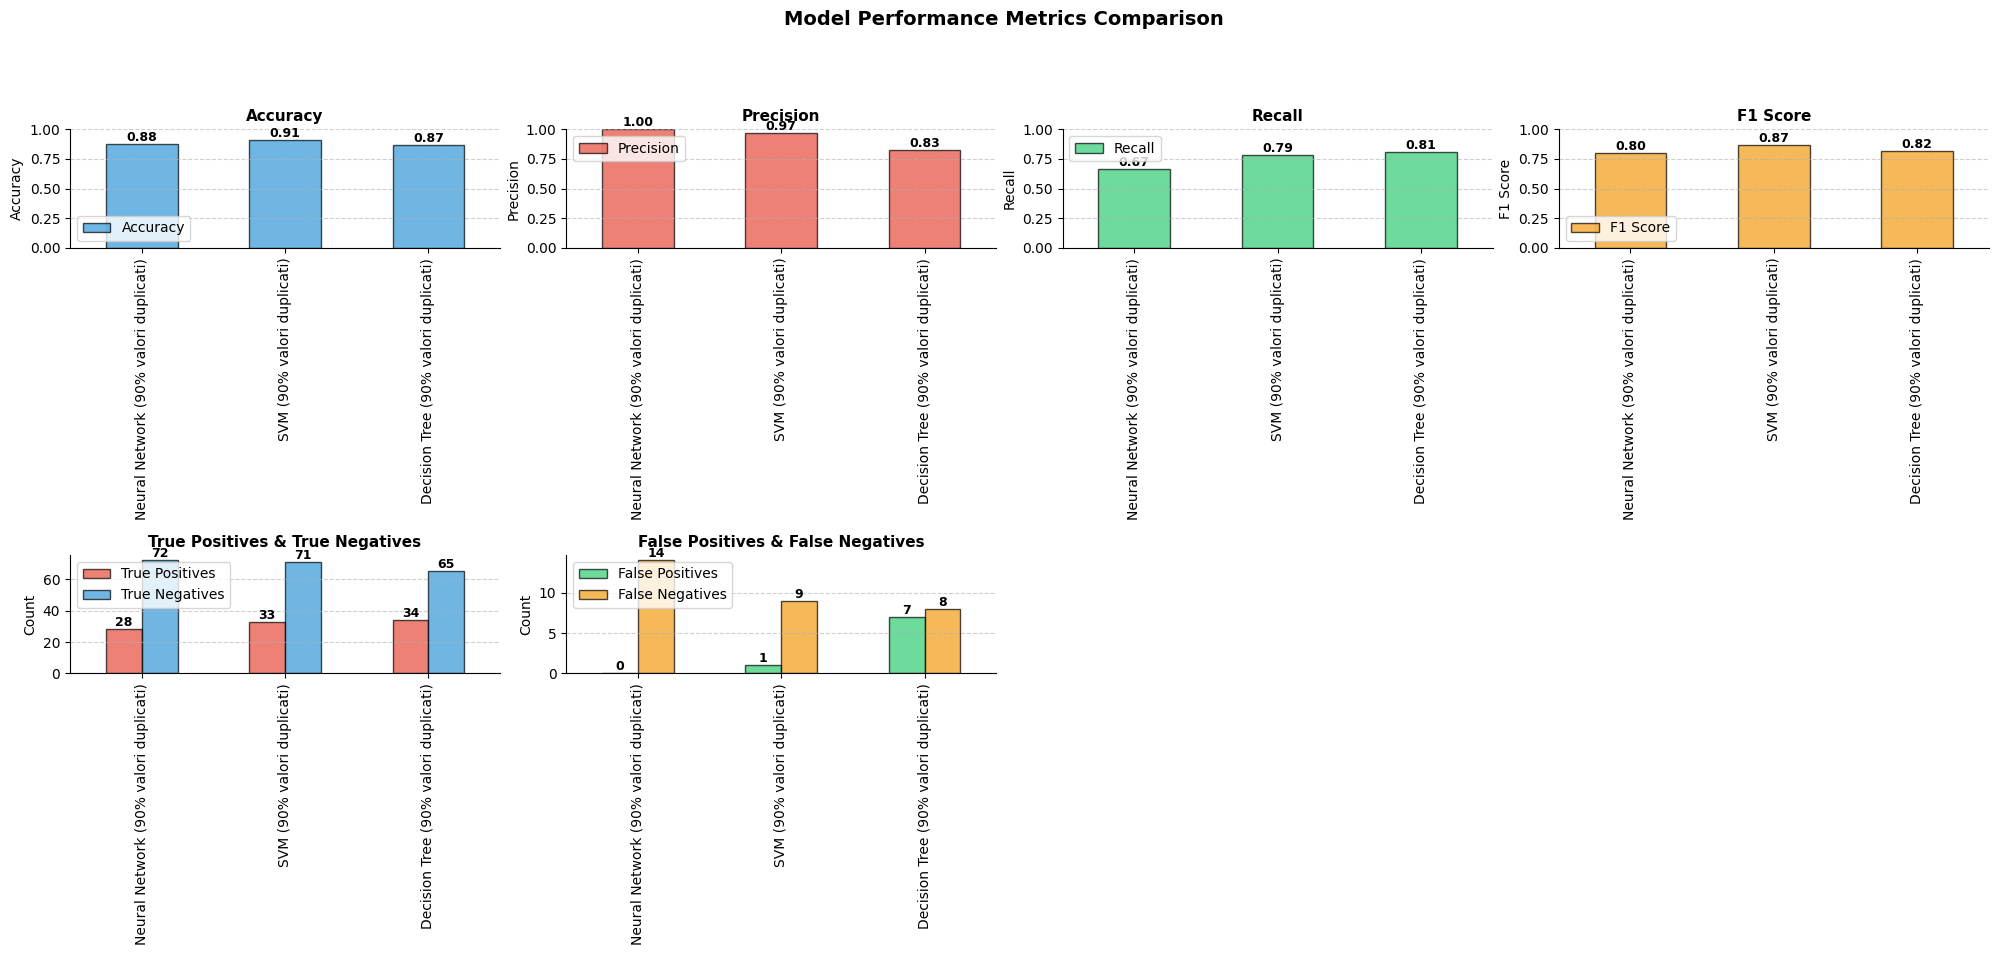

In [199]:
# ====================================================================
# ANALISI VALORI DUPLICATI
# ====================================================================

print("="*60)
print("ANALISI DELL'IMPATTO DEI VALORI DUPLICATI SULLE PERFORMANCE")
print("="*60)

duplicate_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
duplicate_results = []

for duplicate_pct in duplicate_percentages:
    print(f"\n{'='*50}")
    print(f"ANALISI CON {duplicate_pct:.0%} VALORI DUPLICATI")
    print(f"{'='*50}")

    # Introduce valori duplicati
    X_train_duplicates, duplicated_indices = introduce_duplicate_data(X_train, duplicate_pct)
    original_size = len(X_train)
    new_size = len(X_train_duplicates)
    duplicates_added = new_size - original_size

    print(f"Righe duplicate aggiunte: {duplicates_added} (da {original_size} a {new_size} righe)")

    # Crea i target corrispondenti
    y_train_duplicates = y_train.copy()
    if len(duplicated_indices) > 0:
        y_train_additional = y_train.iloc[duplicated_indices]
        y_train_duplicates = pd.concat([y_train_duplicates, y_train_additional], ignore_index=True)

    # Addestra e valuta
    results = train_and_evaluate_models(X_train_duplicates, X_test, y_train_duplicates, y_test, 'valori duplicati', duplicate_pct)
    duplicate_results.append(results)

    # Visualizza le performance per questa percentuale
    print(f"\nVisualizzazione performance con {duplicate_pct:.0%} valori duplicati:")
    plot_model_performance_metrics(results)


VISUALIZZAZIONE EVOLUZIONE PERFORMANCE - VALORI DUPLICATI


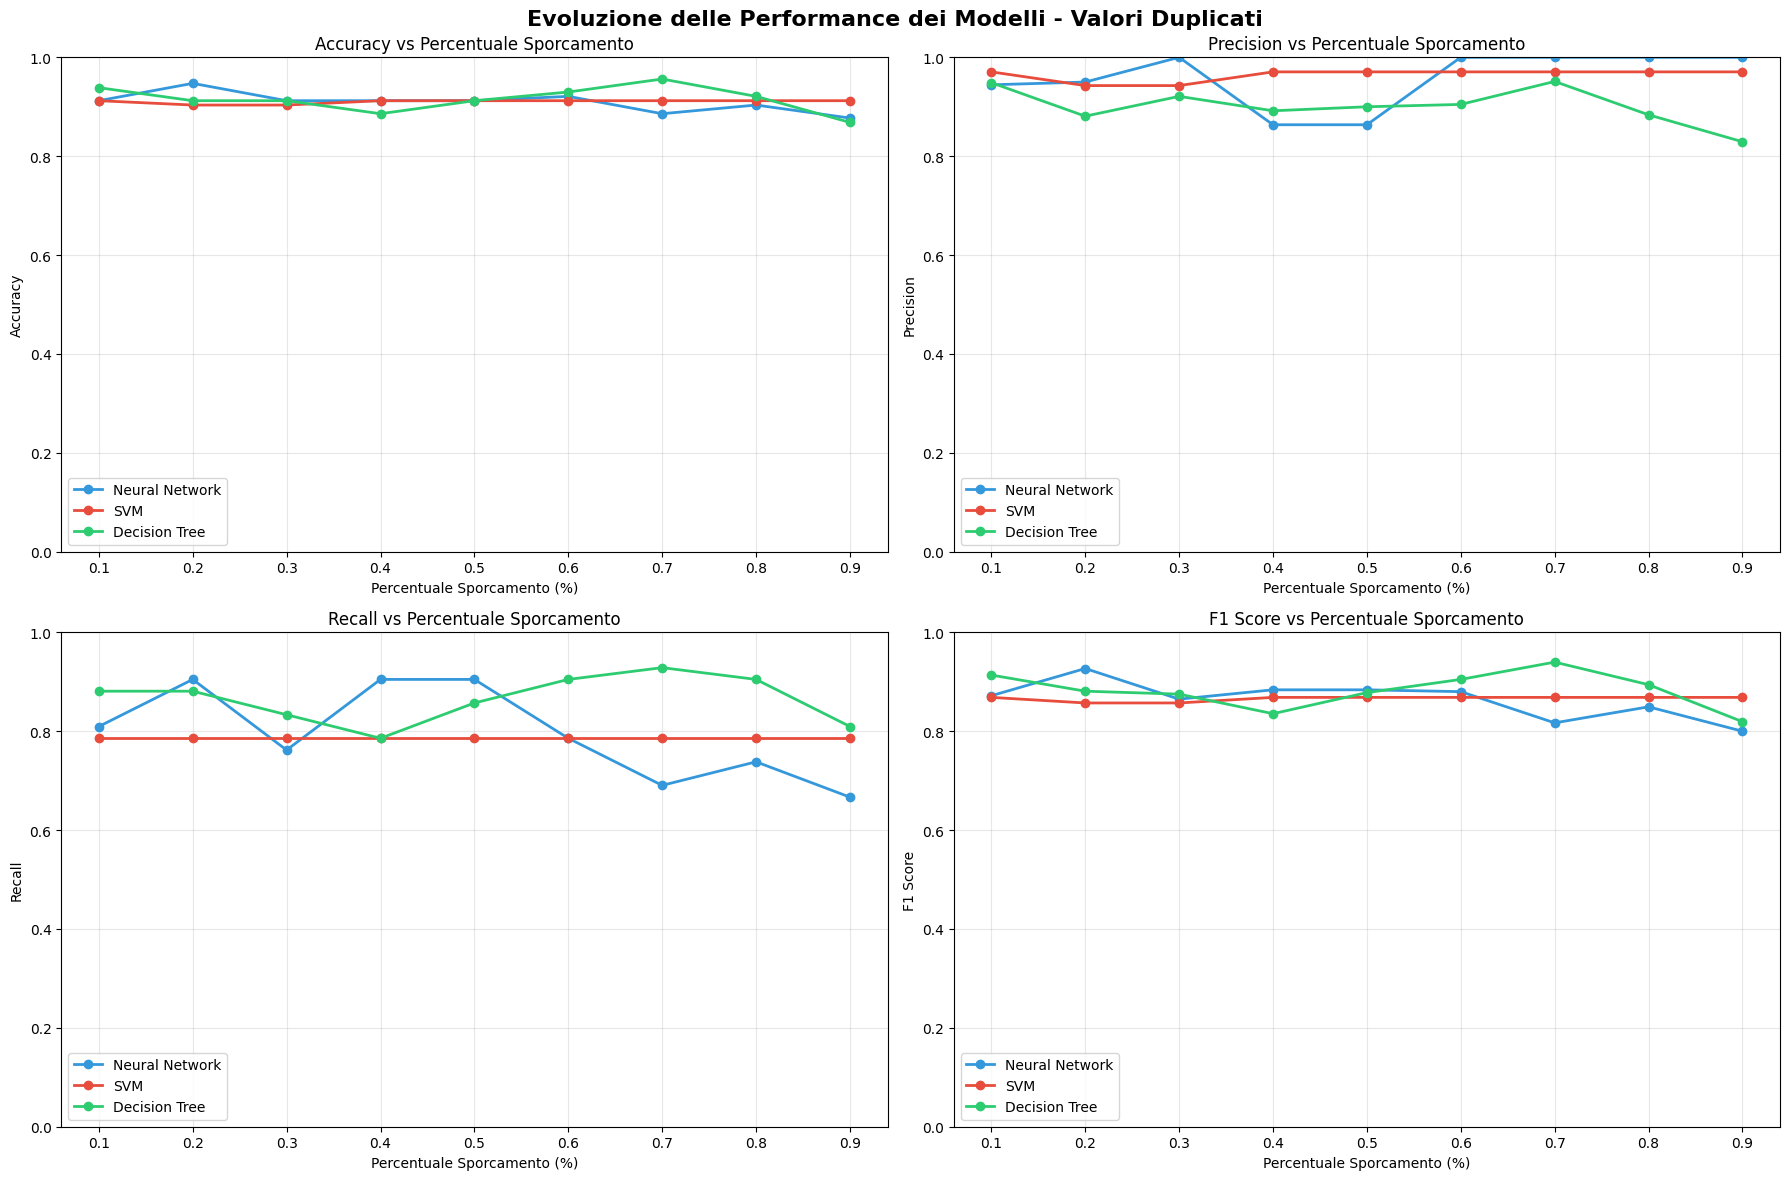

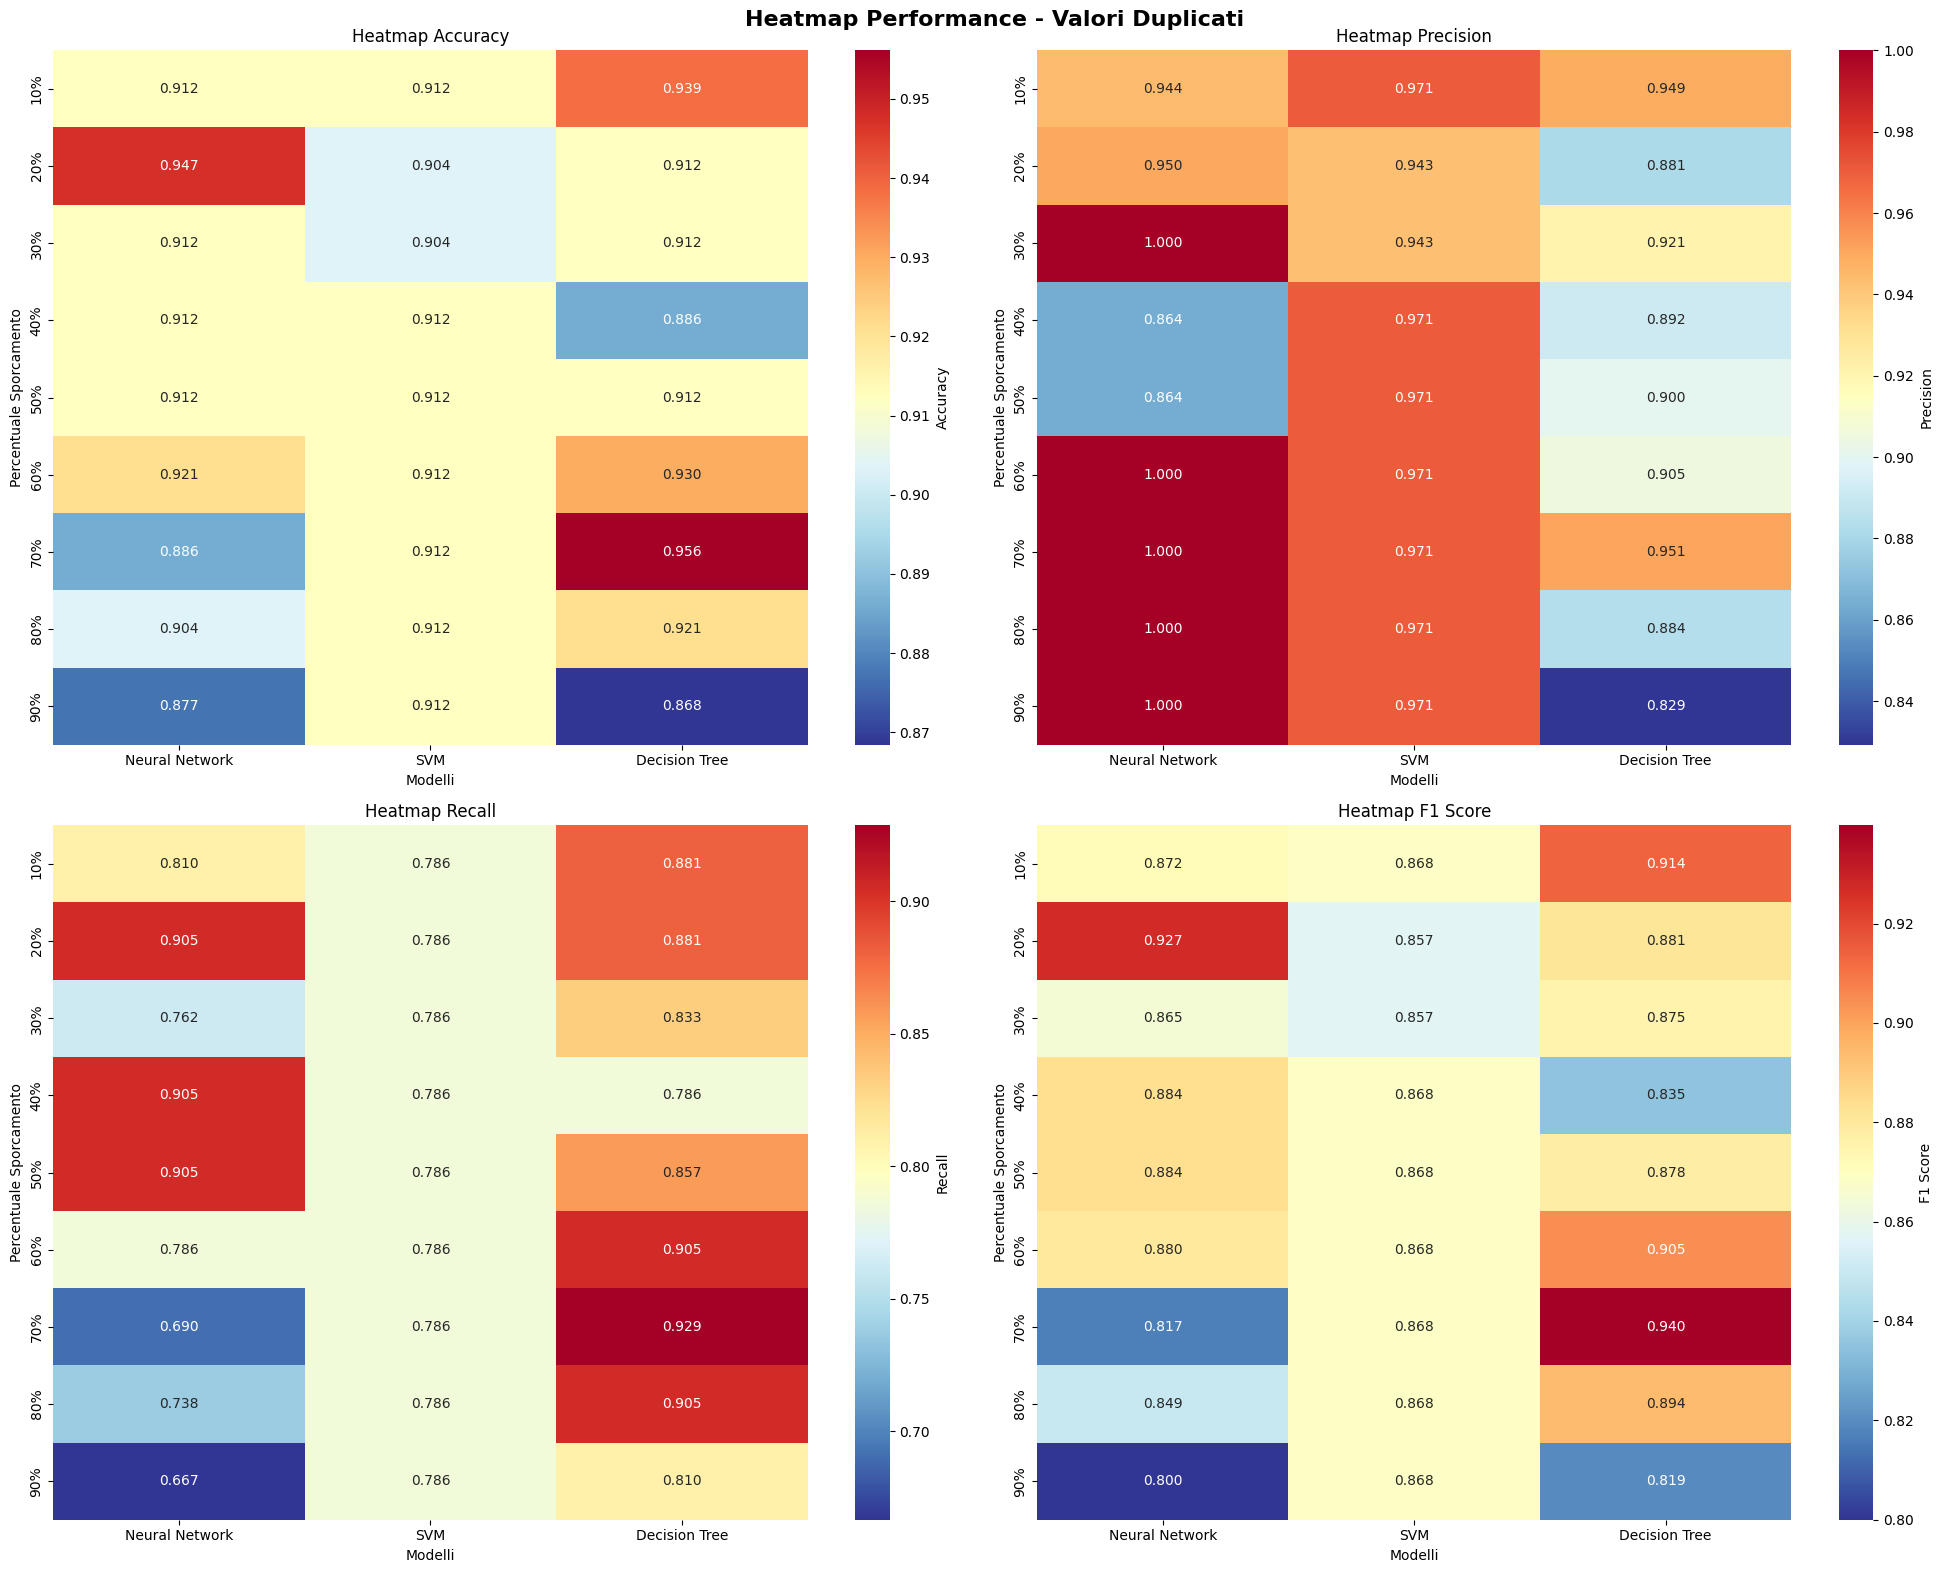


ANALISI STATISTICA FINALE - VALORI DUPLICATI

NEURAL NETWORK:
----------------------------------------
Accuracy    : 0.912 → 0.877 (degrado: 0.035, 3.8%)
Precision   : 0.944 → 1.000 (degrado: -0.056, -5.9%)
Recall      : 0.810 → 0.667 (degrado: 0.143, 17.6%)
F1 Score    : 0.872 → 0.800 (degrado: 0.072, 8.2%)

SVM:
----------------------------------------
Accuracy    : 0.912 → 0.912 (degrado: 0.000, 0.0%)
Precision   : 0.971 → 0.971 (degrado: 0.000, 0.0%)
Recall      : 0.786 → 0.786 (degrado: 0.000, 0.0%)
F1 Score    : 0.868 → 0.868 (degrado: 0.000, 0.0%)

DECISION TREE:
----------------------------------------
Accuracy    : 0.939 → 0.868 (degrado: 0.070, 7.5%)
Precision   : 0.949 → 0.829 (degrado: 0.119, 12.6%)
Recall      : 0.881 → 0.810 (degrado: 0.071, 8.1%)
F1 Score    : 0.914 → 0.819 (degrado: 0.094, 10.3%)


In [200]:
# Visualizzazione finale
print("\n" + "="*60)
print("VISUALIZZAZIONE EVOLUZIONE PERFORMANCE - VALORI DUPLICATI")
print("="*60)

plot_performance_evolution(duplicate_results, duplicate_percentages, "- Valori Duplicati")
create_corruption_heatmap(duplicate_results, duplicate_percentages, "- Valori Duplicati")
print_statistical_analysis(duplicate_results, "valori duplicati")

# Valori outliers

In [201]:
# ====================================================================
# FUNZIONI SPORCAMENTO OUTLIERS
# ====================================================================

def introduce_outliers(dataset, percentage, outlier_type='mixed'):
    """
    Introduce outliers in modo casuale nel dataset.
    """
    dataset_with_outliers = dataset.copy()
    outlier_indices = []

    total_cells = dataset_with_outliers.shape[0] * dataset_with_outliers.shape[1]
    num_outliers = int(total_cells * percentage)

    numeric_columns = dataset_with_outliers.select_dtypes(include=[np.number]).columns

    for col in numeric_columns:
        col_outliers = int(num_outliers / len(numeric_columns))

        if col_outliers > 0:
            mean = dataset_with_outliers[col].mean()
            std = dataset_with_outliers[col].std()
            q1 = dataset_with_outliers[col].quantile(0.25)
            q3 = dataset_with_outliers[col].quantile(0.75)
            iqr = q3 - q1

            indices_to_modify = np.random.choice(
                dataset_with_outliers.index,
                size=min(col_outliers, len(dataset_with_outliers)),
                replace=False
            )

            outlier_values = []
            for idx in indices_to_modify:
                if outlier_type == 'extreme':
                    if np.random.random() < 0.5:
                        outlier_val = mean + np.random.uniform(3, 5) * std
                    else:
                        outlier_val = mean - np.random.uniform(3, 5) * std
                else:  # mixed
                    if np.random.random() < 0.5:
                        if np.random.random() < 0.5:
                            outlier_val = mean + np.random.uniform(3, 5) * std
                        else:
                            outlier_val = mean - np.random.uniform(3, 5) * std
                    else:
                        if np.random.random() < 0.5:
                            outlier_val = q3 + np.random.uniform(1.5, 3) * iqr
                        else:
                            outlier_val = q1 - np.random.uniform(1.5, 3) * iqr

                outlier_values.append(outlier_val)
                outlier_indices.append((idx, col))

            dataset_with_outliers.loc[indices_to_modify, col] = outlier_values

    return dataset_with_outliers, outlier_indices

In [ ]:
# ====================================================================
# ANALISI OUTLIERS
# ====================================================================

print("="*60)
print("ANALISI DELL'IMPATTO DEGLI OUTLIERS SULLE PERFORMANCE")
print("="*60)

outlier_percentages = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
outlier_results = []

for outlier_pct in outlier_percentages:
    print(f"\n{'='*50}")
    print(f"ANALISI CON {outlier_pct:.0%} OUTLIERS")
    print(f"{'='*50}")

    # Introduce outliers
    X_train_outliers, outlier_indices = introduce_outliers(X_train, outlier_pct, outlier_type='mixed')
    outliers_introduced = len(outlier_indices)
    total_cells = X_train.shape[0] * X_train.shape[1]
    actual_outlier_pct = outliers_introduced / total_cells

    print(f"Outliers introdotti: {outliers_introduced} su {total_cells} celle ({actual_outlier_pct:.2%})")

    # Addestra e valuta
    results = train_and_evaluate_models(X_train_outliers, X_test, y_train, y_test, 'outliers', outlier_pct)
    outlier_results.append(results)

    # Visualizza le performance per questa percentuale
    print(f"\nVisualizzazione performance con {outlier_pct:.0%} outliers:")
    plot_model_performance_metrics(results)

In [ ]:
# Visualizzazione finale
print("\n" + "="*60)
print("VISUALIZZAZIONE EVOLUZIONE PERFORMANCE - OUTLIERS")
print("="*60)

plot_performance_evolution(outlier_results, outlier_percentages, "- Outliers")
create_corruption_heatmap(outlier_results, outlier_percentages, "- Outliers")
print_statistical_analysis(outlier_results, "outliers")

# Confronto finale

In [ ]:
# ====================================================================
# CONFRONTO FINALE TRA TIPI DI SPORCAMENTO
# ====================================================================

def compare_corruption_types():
    """
    Confronta le performance dei modelli con diversi tipi di sporcamento.
    """
    print("\n" + "="*80)
    print("CONFRONTO FINALE TRA TIPI DI SPORCAMENTO")
    print("="*80)

    models = ['Neural Network', 'SVM', 'Decision Tree']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    # Prende i risultati a percentuali comparabili (30% per missing e duplicati, 0.3 per outliers)
    missing_30_idx = missing_percentages.index(0.3)
    duplicate_30_idx = duplicate_percentages.index(0.3)
    outlier_30_idx = outlier_percentages.index(0.3)

    missing_30_results = missing_results[missing_30_idx]
    duplicate_30_results = duplicate_results[duplicate_30_idx]
    outlier_30_results = outlier_results[outlier_30_idx]

    corruption_types = ['Valori Mancanti', 'Valori Duplicati', 'Outliers']
    results_30 = [missing_30_results, duplicate_30_results, outlier_30_results]

    # Crea grafici di confronto
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Confronto Performance tra Tipi di Sporcamento (30%)', fontsize=16, fontweight='bold')

    colors = ['#3498db', '#e74c3c', '#2ecc71']

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        x = np.arange(len(models))
        width = 0.25

        for j, corruption_type in enumerate(corruption_types):
            values = [results_30[j][k][metric] for k in range(len(models))]
            ax.bar(x + j*width, values, width, label=corruption_type, color=colors[j], alpha=0.8)

        ax.set_xlabel('Modelli')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} - Confronto Sporcamenti')
        ax.set_xticks(x + width)
        ax.set_xticklabels(models)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Tabella di confronto
    print("\nTABELLA DI CONFRONTO (30% SPORCAMENTO):")
    print("="*80)

    for i, model in enumerate(models):
        print(f"\n{model.upper()}:")
        print("-" * 60)
        print(f"{'Metrica':<12} {'Mancanti':<10} {'Duplicati':<11} {'Outliers':<10} {'Migliore':<10}")
        print("-" * 60)

        for metric in metrics:
            missing_val = missing_30_results[i][metric]
            duplicate_val = duplicate_30_results[i][metric]
            outlier_val = outlier_30_results[i][metric]

            best_val = max(missing_val, duplicate_val, outlier_val)

            if best_val == missing_val:
                best_type = "Mancanti"
            elif best_val == duplicate_val:
                best_type = "Duplicati"
            else:
                best_type = "Outliers"

            print(f"{metric:<12} {missing_val:<10.3f} {duplicate_val:<11.3f} {outlier_val:<10.3f} {best_type:<10}")

    # Analisi degradazione media
    print("\n" + "="*80)
    print("ANALISI DEGRADAZIONE MEDIA PER TIPO DI SPORCAMENTO")
    print("="*80)

    for corruption_type, results, percentages in [
        ("Valori Mancanti", missing_results, missing_percentages),
        ("Valori Duplicati", duplicate_results, duplicate_percentages),
        ("Outliers", outlier_results, outlier_percentages)
    ]:
        print(f"\n{corruption_type.upper()}:")
        print("-" * 50)

        total_degradation = 0
        count = 0

        for i, model in enumerate(models):
            for metric in metrics:
                values = [result[i][metric] for result in results]
                initial_value = values[0]
                final_value = values[-1]
                degradation_pct = ((initial_value - final_value) / initial_value) * 100
                total_degradation += degradation_pct
                count += 1

        avg_degradation = total_degradation / count
        print(f"Degradazione media: {avg_degradation:.1f}%")

# Esegui il confronto finale
compare_corruption_types()

print("\nAnalisi completa di tutti i tipi di sporcamento completata!")